## Project: vRES integration

#### Estimating balancing and storage needs by analysing the residual load curve under a variety of scenarios. 

1. History of renewables in generation mix
2. Influence of growing vRES shares on electricity spot prices

#### Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import groupby
from scipy import stats

import warnings
from matplotlib.ticker import StrMethodFormatter

#### Set visual display styles

In [2]:
palette="Blues"

sns.set(style="whitegrid", palette=palette, font_scale = 1.8)
sns.set_style("whitegrid", {'axes.grid' : False})

plt.rc("figure", figsize=(16,8))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=20)

my_colors = sns.color_palette(palette, 2)

plt.rcParams.update({'figure.max_open_warning': 0})
warnings.filterwarnings('ignore')
plt.close('all')
figpath = "Images/"

#### User-defined input paths and parameters

In [3]:
fpath = '../../../Data/TS_DK/'
fname = 'danish_system_data.csv'

parse_time = 'HourUTC'
price_areas = 'PriceArea'
price_col = 'SpotPriceEUR'

col_excep = ['HourUTC', 'PriceArea', 'weekday_name', 'is_leap_year', 'seasons', 'day_ids', 'time_of_day']
rem_end = 'MWh'

special_cols = [price_col, 'GrossConsumptionMWh']

m2t = 1/(1000*1000)
m2g = 1/1000

solar_start_year = 2014

opacity = 0.8
bar_width = 0.35

L = 'GrossConsumptionMWh'
S = 'SolarPowerProdMWh'
W = 'WindPowerProdMWh'
l = 'scaled_consumption' 
up_s = 'upscaled_solar'
up_w = 'upscaled_wind'

#### Define useful functions

In [4]:
def check_null_neg_vals(df, col_excep, rem_end):
    '''
    This function sequentially checks for null values and negative values, 
    wherever rendered inappropriate. First we select all columns to be 
    investigated. That means, for the current case, we include all columns 
    except the columns with time-stamps and price areas. All selected columns 
    are then checked for any null value, and if present, the number of null 
    values is reported back on the screen for each column. Next we select only 
    the columns that represent data from certain generation facilities or the 
    consumption needs. This means we are purposefully leaving out the 
    electricity spot prices, which can often have negative values. If any 
    negative value is encountered from any generation/consumption column, they 
    are considered as 'bad' values and are replaced with nan values. 
    
    Note: We are not replacing the NaN values, but are being aware of the share
    of NaN values in each column.

    Inputs
    ----------
    df: input dataframe
    col_excep: columns to leave out, because it contains either string or time-stamp
    rem_end : part of string used to identify production and consumption 

    Outputs
    -------
    df : updated dataframe

    '''
    
    cols = [col for col in df.columns if col not in col_excep]
    
    # checking for null values
    for col in cols:
        
        n = len(df[df[col].isnull()])
        
        if (n!=0):
            print('Analysing %s: %d null values' % (col, n))
    
    # checking for negative values
    cols = list(filter(lambda x: x.endswith(rem_end), cols));
    
    for col in cols:
        
        n = len(df[col].loc[df[col]<0])
        
        if (n!=0):
            print('Analysing %s: %d neg. values' % (col, n))
            df.loc[(df[col] < 0), col]=np.nan
            
    return df

###################################################################

def calculate_replacement(group):
    '''
    For the price column, let's remove the extreme outliers. 
    '''
    mask = (group > 100) | (group < -25)
    max_value = group[~mask].max()
    
    return group.where(~mask, max_value)

###################################################################

def get_upscaled_gen(df, S, W, L):
    
    df[l] = df[L]/np.mean(df[L])
    
    df[up_s] = df[S] * ((np.mean(df[l]))/(np.mean(df[S])))
    df[up_w] = df[W] * ((np.mean(df[l]))/(np.mean(df[W])))

    return df

###################################################################

def is_leap_year(year):
    if (year % 4 == 0) and (year % 100 != 0 or year % 400 == 0):
        return True
    else:
        return False

#### Load the data

Extreme outliers from the price column should be replaced by reasonable high/low values

In [5]:
df = pd.read_csv(fpath + fname, parse_dates=[parse_time])
df = check_null_neg_vals(df, col_excep, rem_end)

df = df.set_index(parse_time)
df[price_col] = df.groupby(price_areas)[price_col].transform(calculate_replacement)

#print(df)

Analysing OnshoreWindGe50kW_MWh: 1 null values
Analysing HydroPowerMWh: 1 null values


### Section:1 - History of renewables in generation mix

#### Check how different generation sources have changed over the years. 

###### Note that we are looking into total generations, and not into evolving installed capacities.

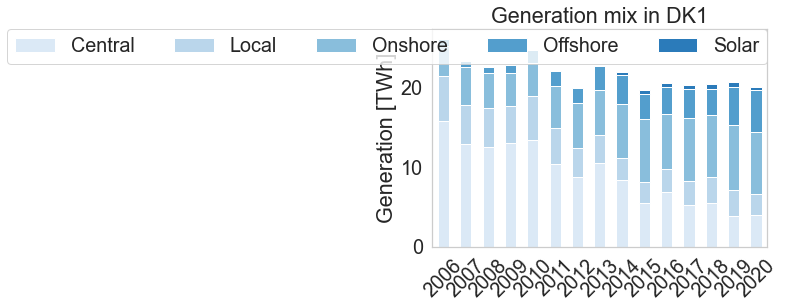

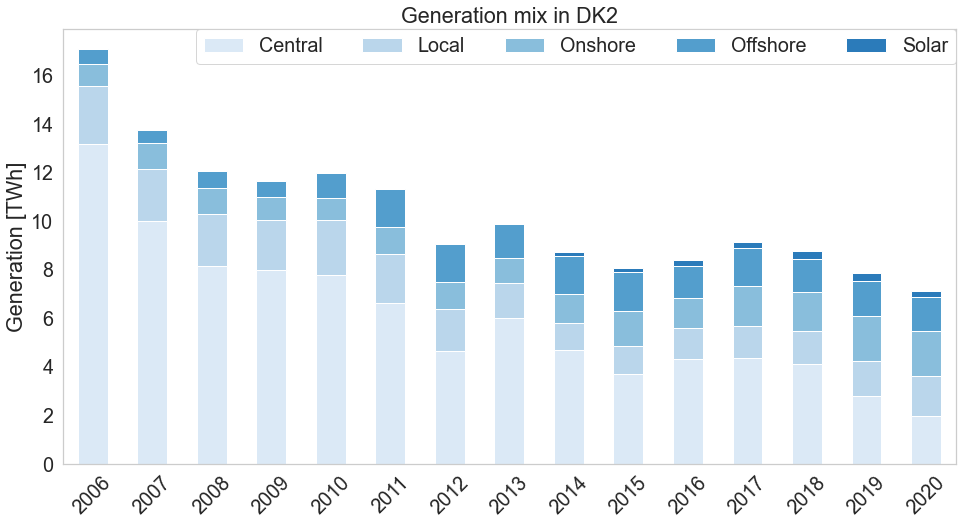

In [6]:
for area in df[price_areas].unique():
    
    get_years = []
    get_central, get_local = [], []
    get_solar, get_onshore, get_offshore = [], [], []
    
    for year in df['year'].unique():
        el = df.loc[(df[price_areas]==area) & (df['year']==year)]
        
        get_years.append(year)
        
        get_central.append(m2t * el['CentralPowerMWh'].sum())
        get_local.append(m2t * el['LocalPowerProdMWh'].sum())
        
        get_solar.append(m2t * el['SolarPowerProdMWh'].sum())
        get_onshore.append(m2t * el['OnshorePowerProdMWh'].sum())
        get_offshore.append(m2t * el['OffshorePowerProdMWh'].sum())
    
    gen_mix = pd.DataFrame()
    
    gen_mix = pd.DataFrame(list(zip(get_central, get_local, get_onshore, get_offshore, get_solar)), 
                           index = get_years, 
                           columns =['Central', 'Local', 'Onshore', 'Offshore', 'Solar'])

    plt.rc("figure", figsize=(16,8))
    ax = gen_mix.plot(kind="bar", stacked=True)
    plt.title('Generation mix in ' + area)
    plt.xlabel("")
    plt.ylabel("Generation [TWh]")
    plt.legend(loc="upper right", borderaxespad=0., ncol=5)
    ax.set_xticklabels(get_years, rotation = 45)
    plt.savefig(figpath + "genmix_twh_" + area + ".png", bbox_inches="tight", pad_inches=0.3)

#### Let's look into the relative changes - visually more appealing when discussing synergies

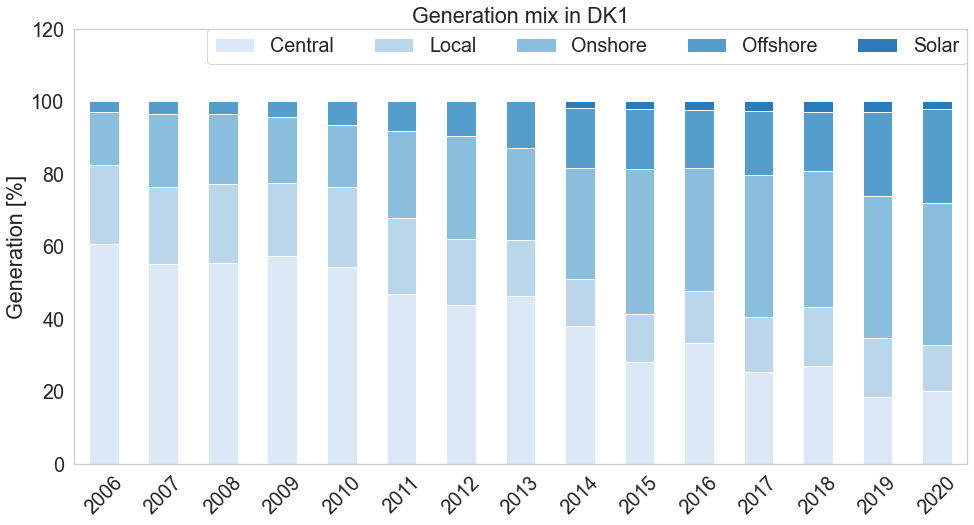

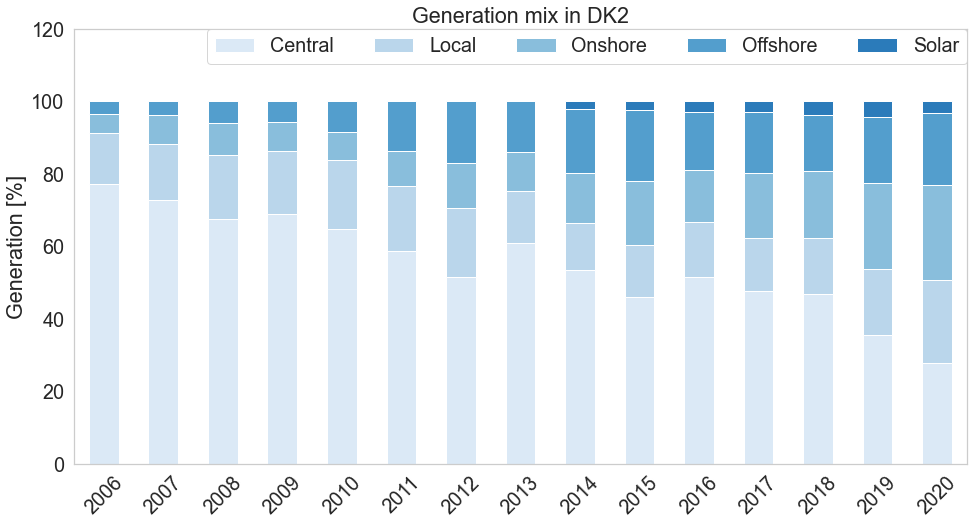

In [7]:
for area in df[price_areas].unique():
    
    get_years = []
    get_central, get_local = [], []
    get_solar, get_onshore, get_offshore = [], [], []
    
    for year in df['year'].unique():
        el = df.loc[(df[price_areas]==area) & (df['year']==year)]
        
        get_years.append(year)
        
        central = el['CentralPowerMWh'].sum()
        local = el['LocalPowerProdMWh'].sum()
        
        solar = el['SolarPowerProdMWh'].sum()
        onshore = el['OnshorePowerProdMWh'].sum()
        offshore = el['OffshorePowerProdMWh'].sum()
        
        total = central + local + solar + onshore + offshore
        
        get_central.append((central/total)*100)
        get_local.append((local/total)*100)
        
        get_solar.append((solar/total)*100)
        get_onshore.append((onshore/total)*100)
        get_offshore.append((offshore/total)*100)
    
    gen_mix = pd.DataFrame()
    
    gen_mix = pd.DataFrame(list(zip(get_central, get_local, get_onshore, get_offshore, get_solar)), 
                           index = get_years, 
                           columns =['Central', 'Local', 'Onshore', 'Offshore', 'Solar'])

    ax = gen_mix.plot(kind="bar", stacked=True)
    plt.title('Generation mix in ' + area)
    plt.xlabel("")
    plt.ylabel("Generation [%]")
    plt.legend(loc="upper right", borderaxespad=0., ncol=gen_mix.shape[1])
    plt.ylim([0, 120])
    ax.set_xticklabels(get_years, rotation = 45)
    plt.savefig(figpath + "genmix_percent_" + area + ".png", bbox_inches="tight", pad_inches=0.3)

#### On an annual level, a pie plot is often more comprehensible

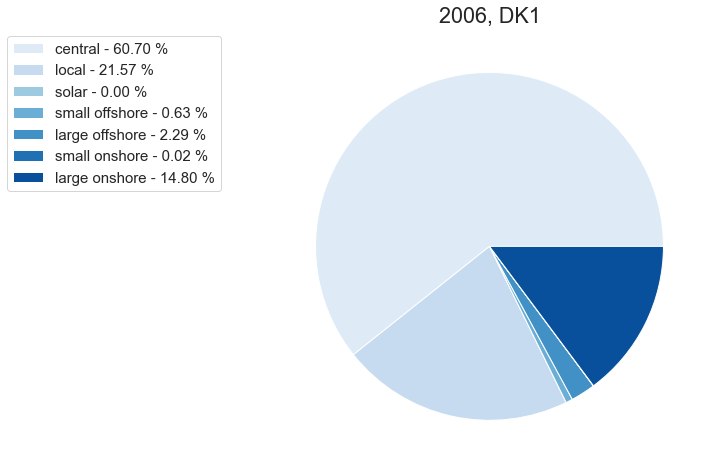

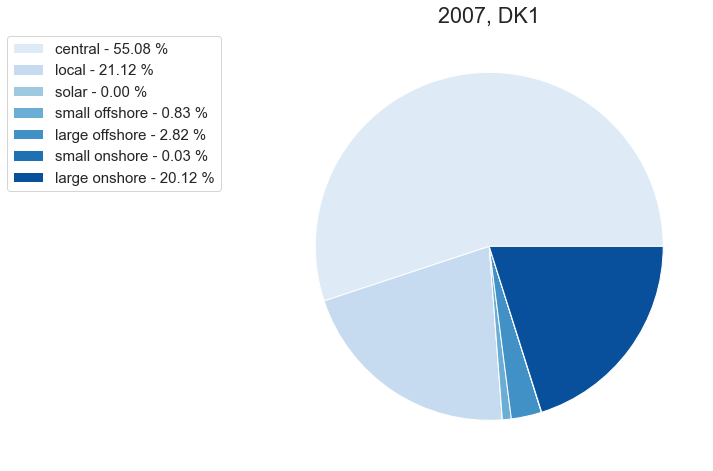

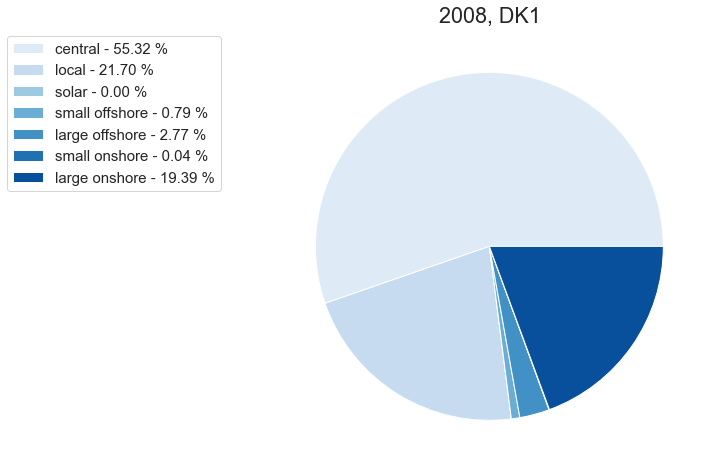

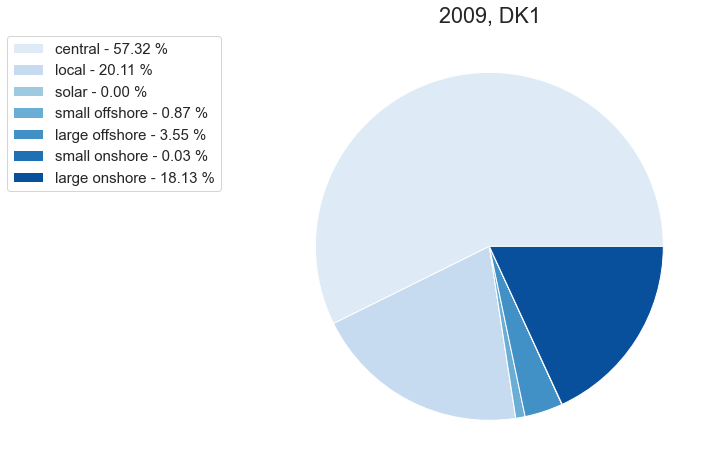

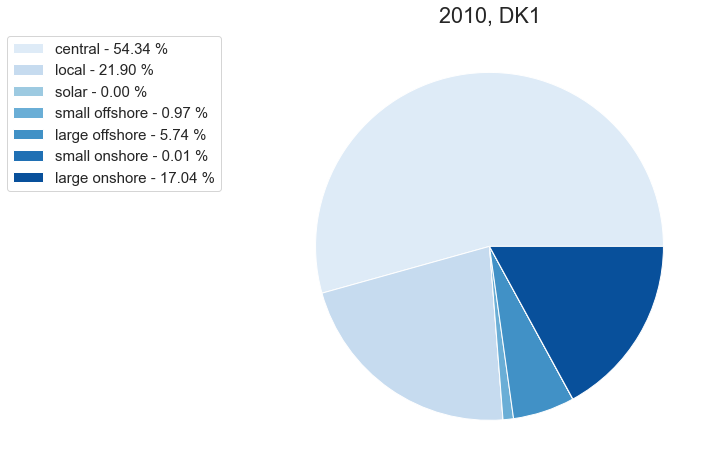

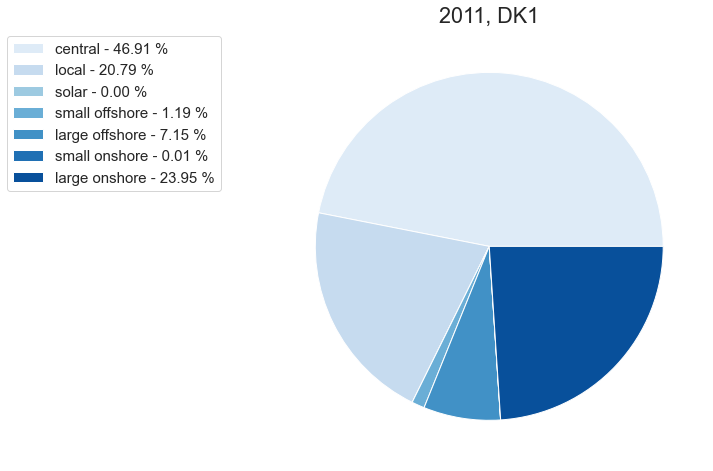

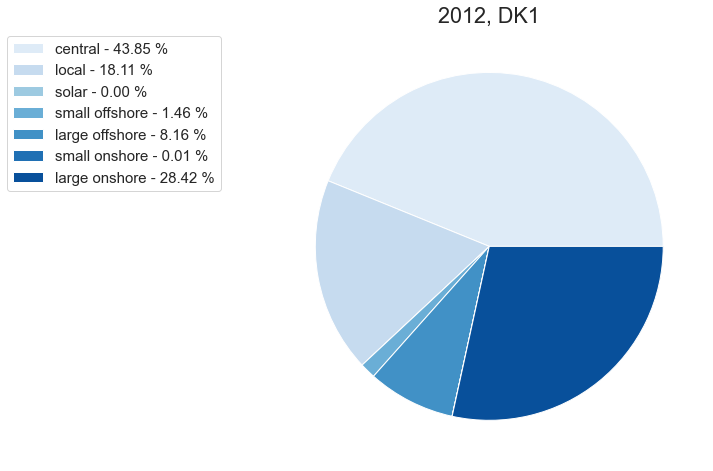

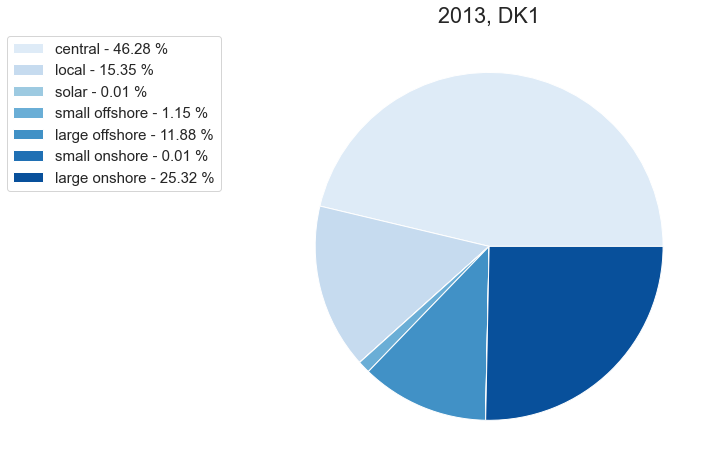

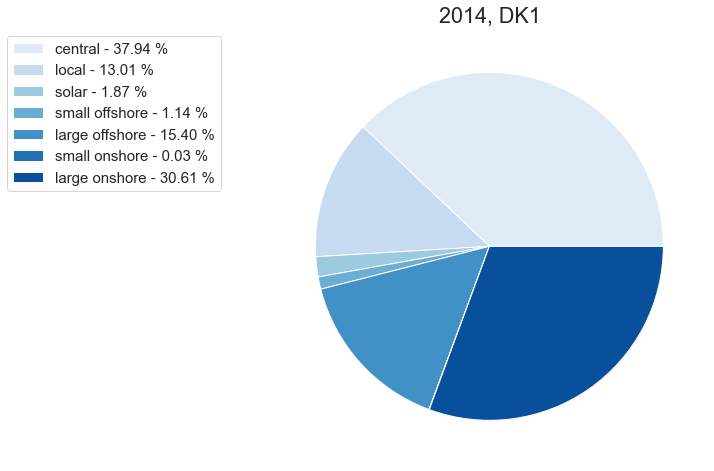

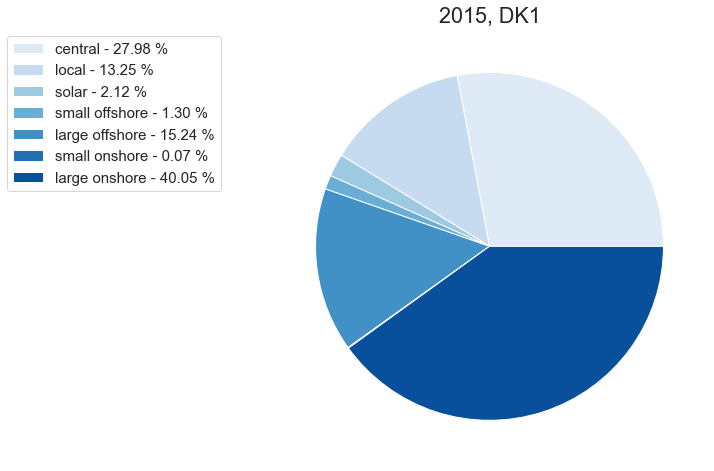

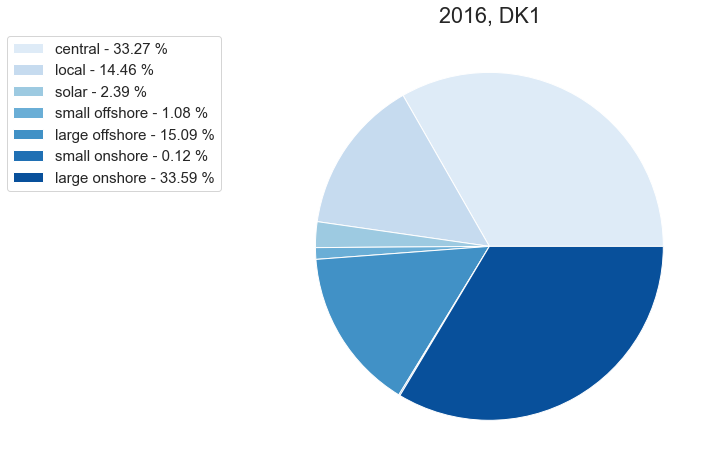

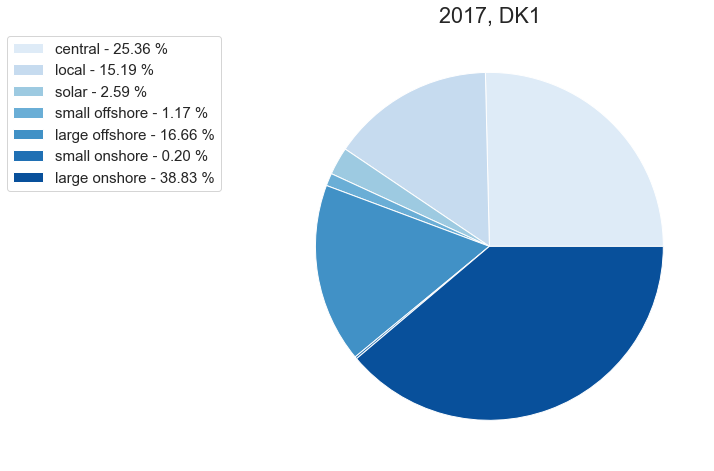

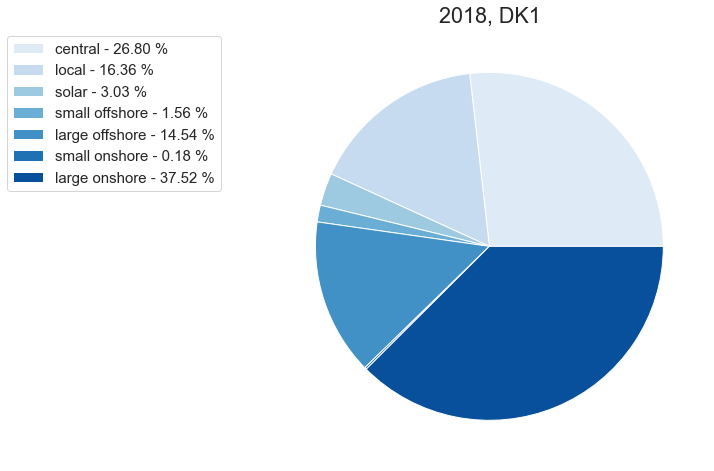

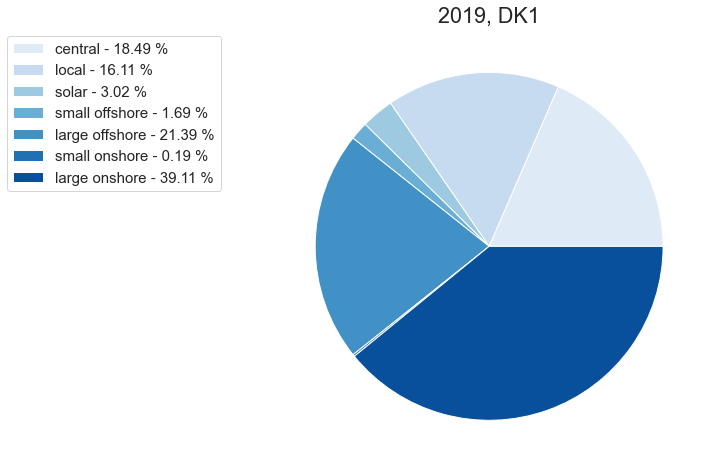

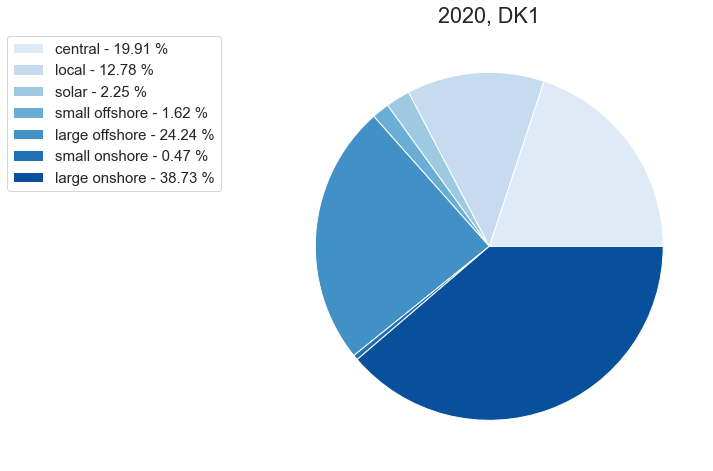

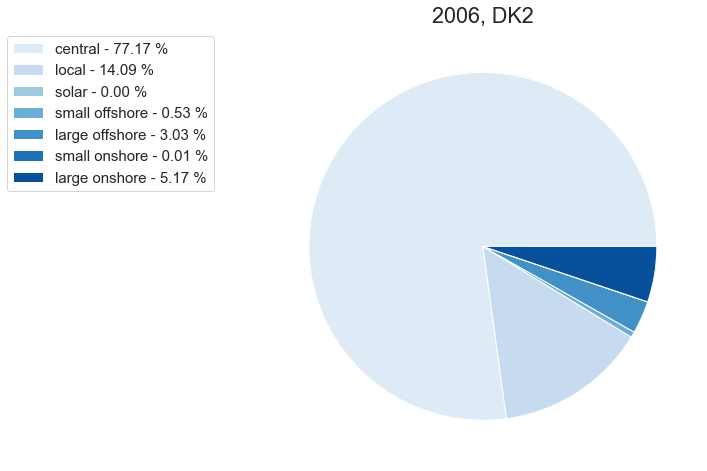

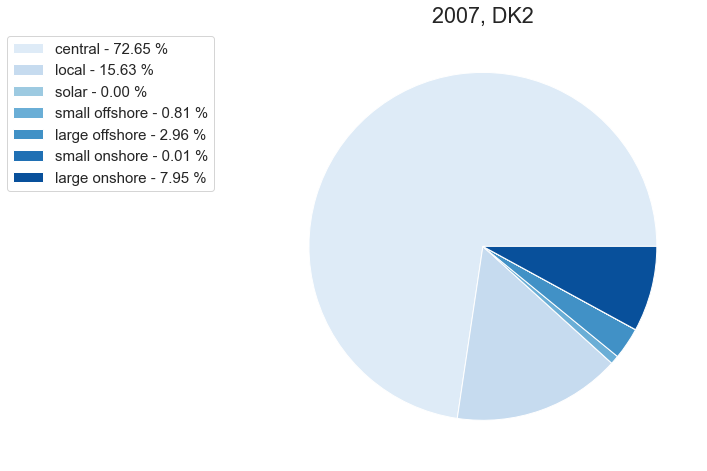

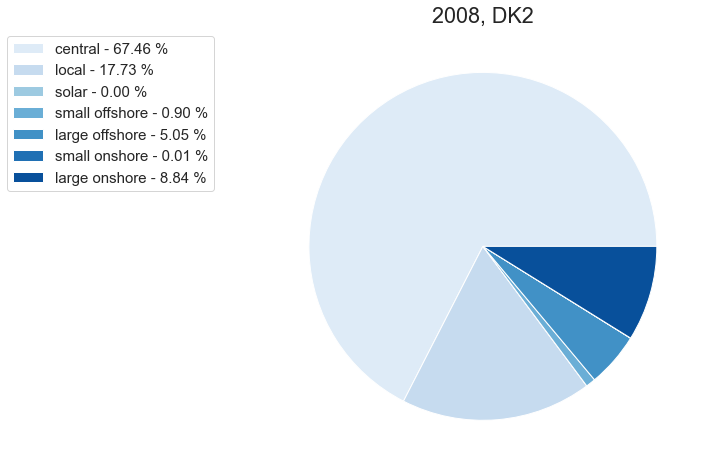

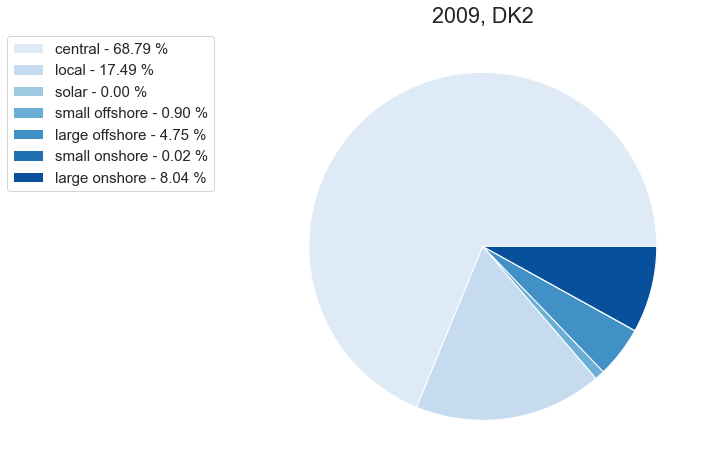

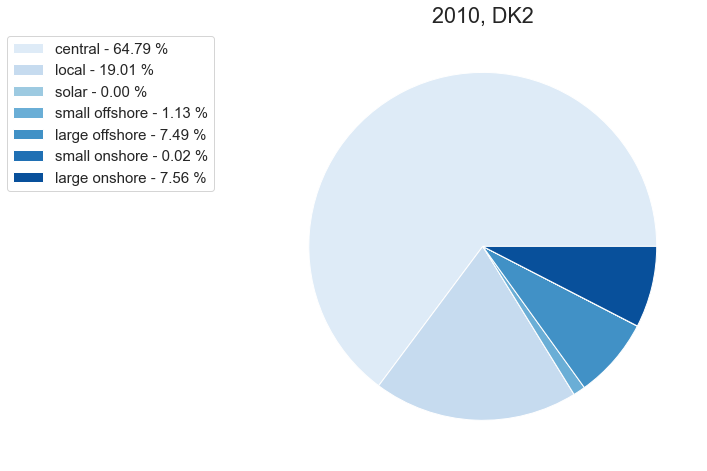

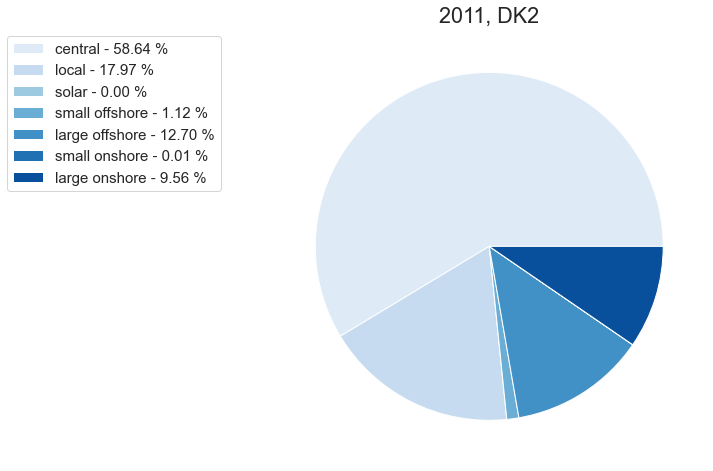

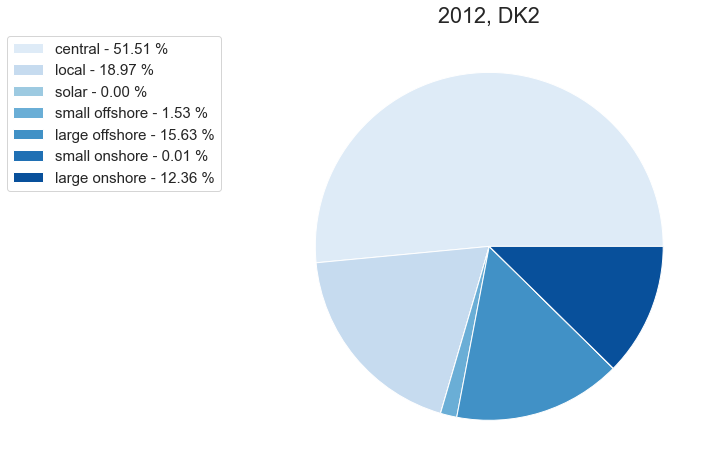

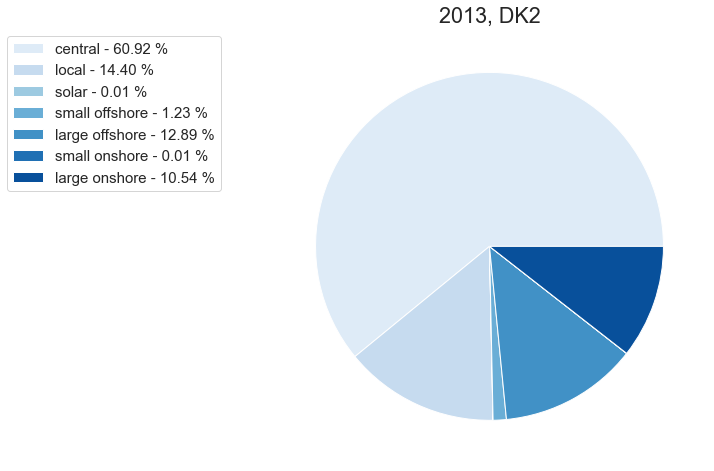

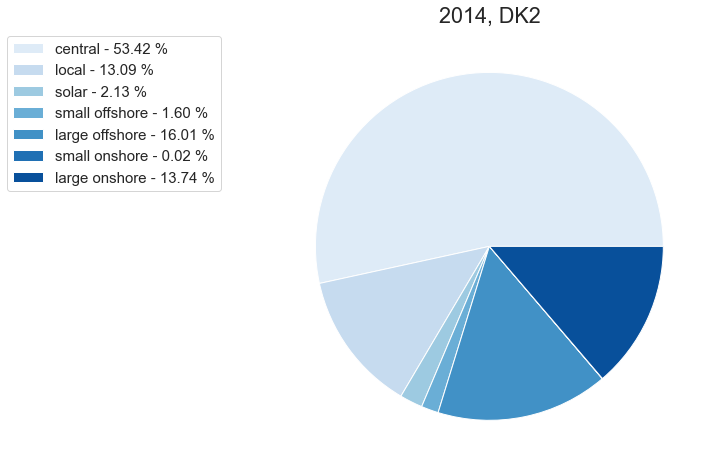

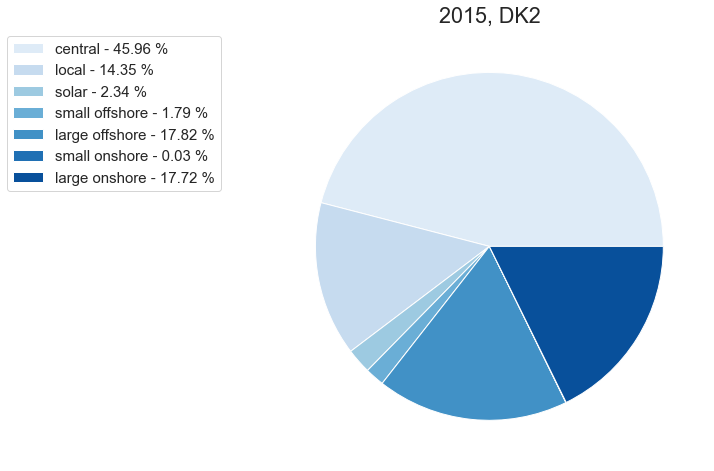

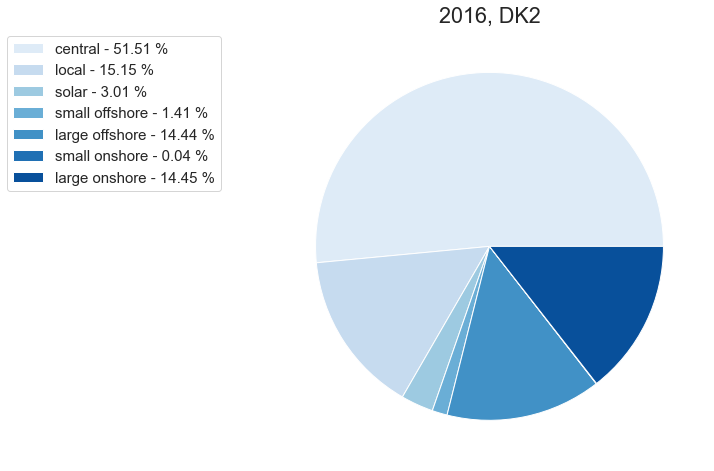

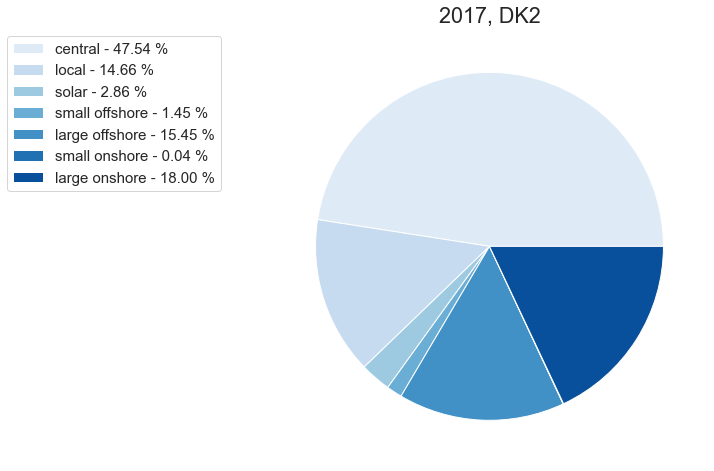

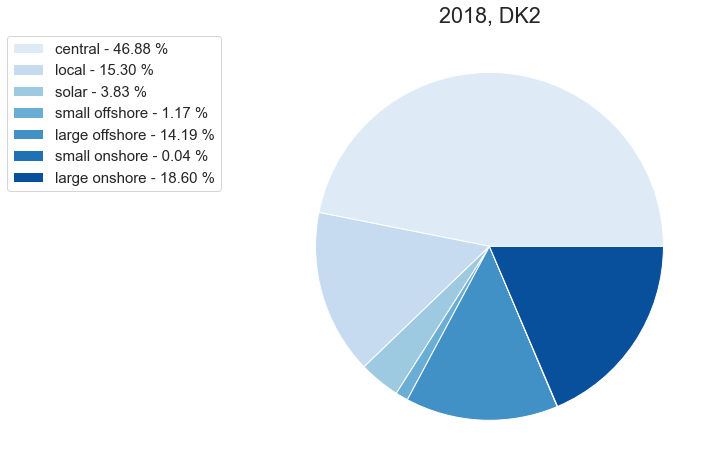

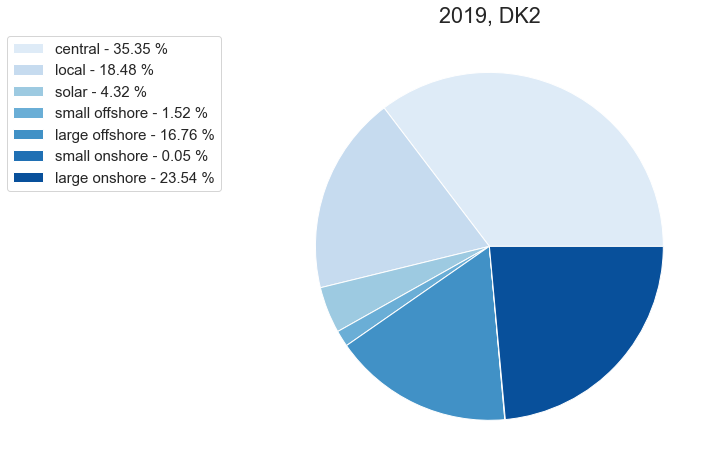

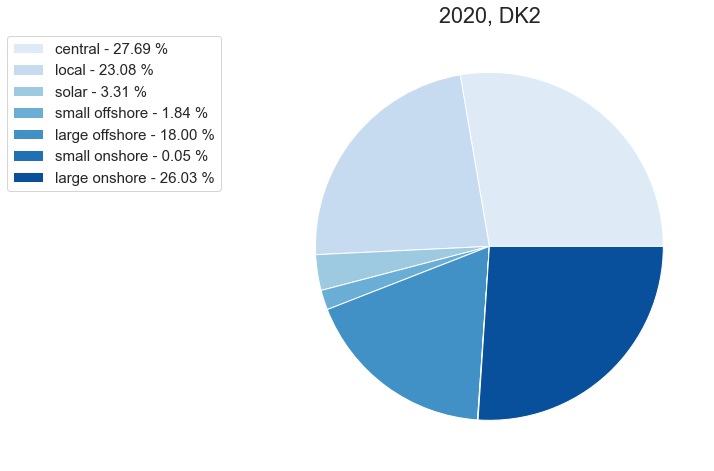

In [8]:
gen_dict = {'CentralPowerMWh': 'central', 'LocalPowerProdMWh': 'local', 'SolarPowerProdMWh': 'solar', 
           'OffshoreWindLt100MW_MWh': 'small offshore', 'OffshoreWindGe100MW_MWh': 'large offshore',
           'OnshoreWindLt50kW_MWh': 'small onshore', 'OnshoreWindGe50kW_MWh': 'large onshore'}

for area in df[price_areas].unique():
    for year in df['year'].unique():
        el = df.loc[(df[price_areas]==area) & (df['year']==year)]
        
        data = []
        labels = []
        
        for key in gen_dict:
            
            data.append(el[key].sum())
            labels.append(gen_dict[key])
        
        sf = 100/np.sum(data)
        percent = [x*sf for x in data]

        patches, texts = plt.pie(data, colors=sns.color_palette(palette=palette, n_colors=len(gen_dict), desat=None))
        labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]
        plt.legend(patches, labels, bbox_to_anchor=(-0.1, 1.),fontsize=15)
        plt.title(str(year) + ', ' + area)
        plt.savefig(figpath + "genmix_pie_" + str(year) + "_" + area + ".png", bbox_inches="tight", pad_inches=0.3)
        plt.show()

#### For long-term (multi-year) analysis, the seasonal trends can be best visualized through monthly data

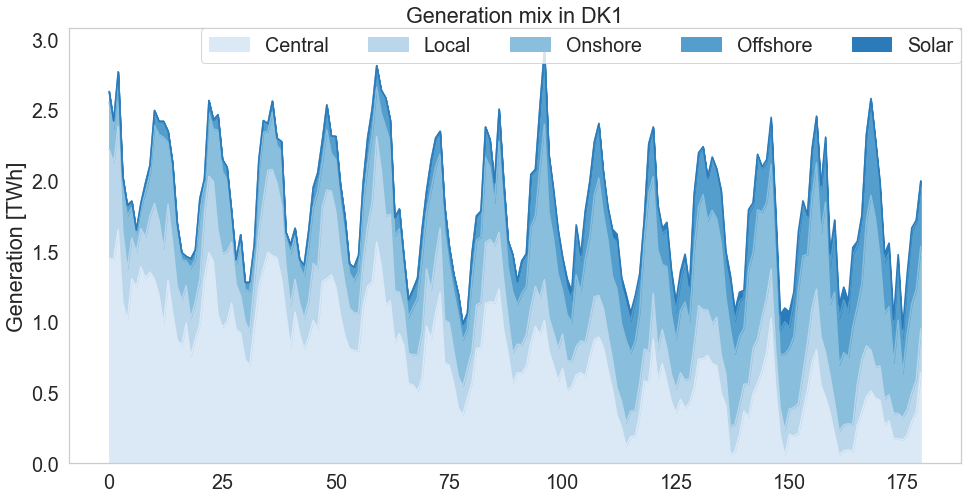

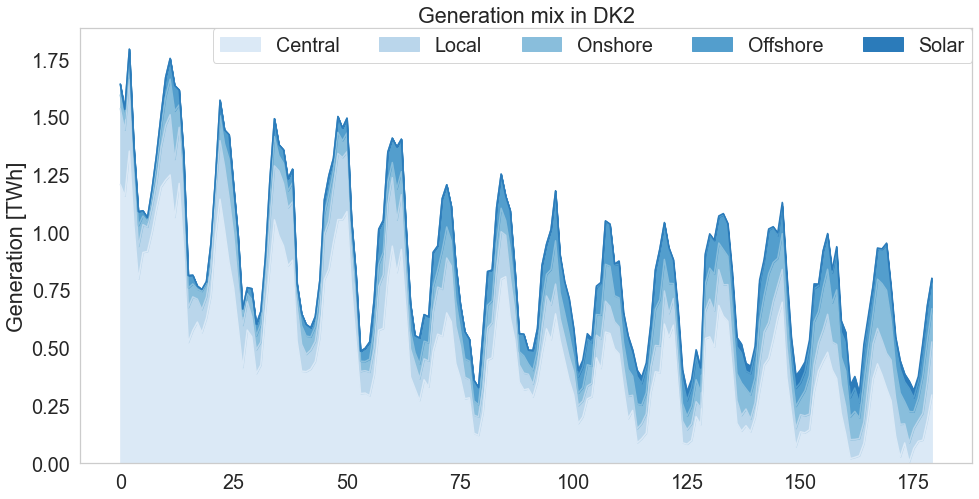

In [9]:
for area in df[price_areas].unique():
    
    get_time = []
    get_central, get_local = [], []
    get_solar, get_onshore, get_offshore = [], [], []
    
    n=0
    for year in df['year'].unique():
        for month in df['month'].unique():
            
            el = df.loc[(df[price_areas]==area) & (df['year']==year) & (df['month']==month)]
        
            get_time.append(n)
            n=n+1
        
            get_central.append(m2t * el['CentralPowerMWh'].sum())
            get_local.append(m2t * el['LocalPowerProdMWh'].sum())
        
            get_solar.append(m2t * el['SolarPowerProdMWh'].sum())
            get_onshore.append(m2t * el['OnshorePowerProdMWh'].sum())
            get_offshore.append(m2t * el['OffshorePowerProdMWh'].sum())
    
    gen_mix = pd.DataFrame()
    
    gen_mix = pd.DataFrame(list(zip(get_central, get_local, get_onshore, get_offshore, get_solar)), 
                           index = get_time, 
                           columns =['Central', 'Local', 'Onshore', 'Offshore', 'Solar'])

    gen_mix.plot.area(title=area)
    plt.title('Generation mix in ' + area)
    plt.xlabel("")
    plt.ylabel("Generation [TWh]")
    plt.legend(loc="upper right", borderaxespad=0., ncol=gen_mix.shape[1])
    plt.savefig(figpath + "monthly_genmix_" + area + ".png", bbox_inches="tight", pad_inches=0.3)

### Section:2 - Influence of growing vRES shares on electricity spot prices

#### Occurrence of frequent high price and low price periods as a result of growing vRES shares

DK1 83.82 0.11
DK2 99.69 3.06


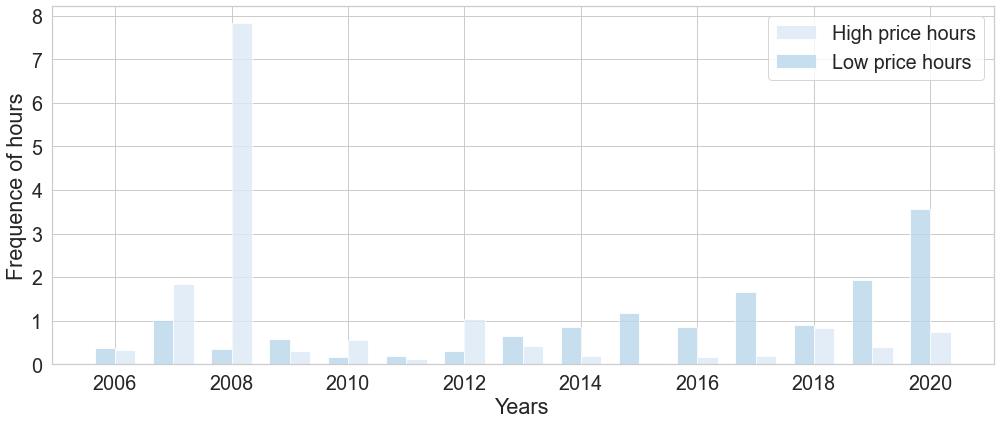

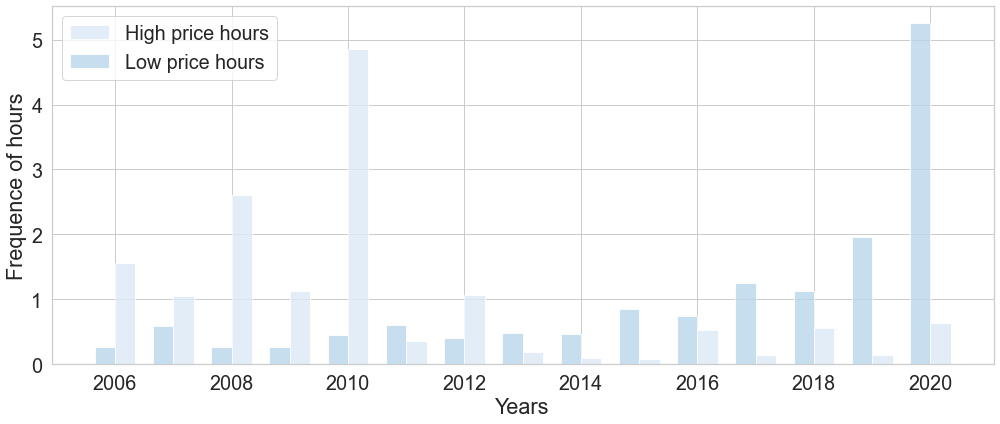

In [10]:
high_percentile = 99
low_percentile = 1

for area in df[price_areas].unique():
    
    high_threshold = np.percentile(df[price_col].loc[df[price_areas]==area], high_percentile)
    low_threshold = np.percentile(df[price_col].loc[df[price_areas]==area], low_percentile)
    
    print(area, high_threshold, low_threshold)
    
    years = df["year"].unique()

    share_high = np.zeros(len(years))
    share_low = np.zeros(len(years))
    
    for i in np.arange(0, len(years)):
        
        dat = df[price_col].loc[(df[price_areas]==area) & (df["year"]==years[i])]
        
        share_high[i] = (len(dat.loc[dat>high_threshold])/len(dat))*100
        share_low[i] = (len(dat.loc[dat<low_threshold])/len(dat))*100
    
    fig, ax = plt.subplots(1,1, figsize=(14,6))
    plt.xlabel('Years')
    plt.ylabel('Frequence of hours')

    plt.bar(years+(bar_width/2), share_high, bar_width, align='center', alpha=opacity, label='High price hours')
    plt.bar(years-(bar_width/2), share_low, bar_width, align='center', alpha=opacity, label='Low price hours')
    ax.tick_params(axis="both", which="major")
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.savefig(figpath + "high_low_price_freq_" + area + ".png", bbox_inches="tight", pad_inches=0.3)

#### Connect the effect of increased frequency of negative price periods with growing vRES shares

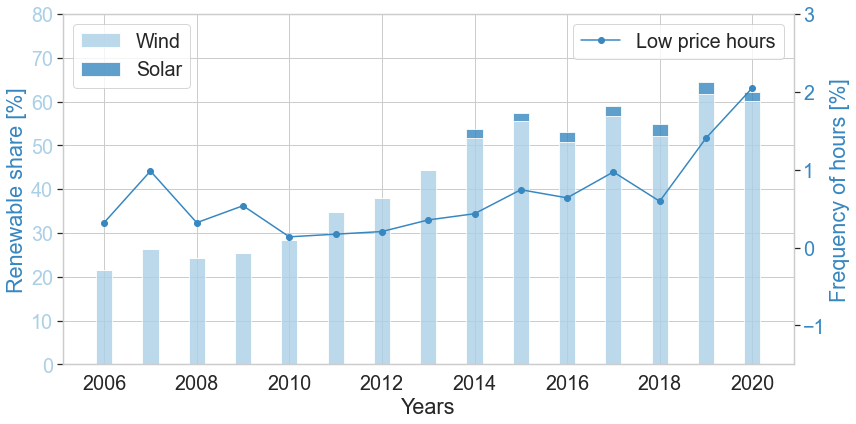

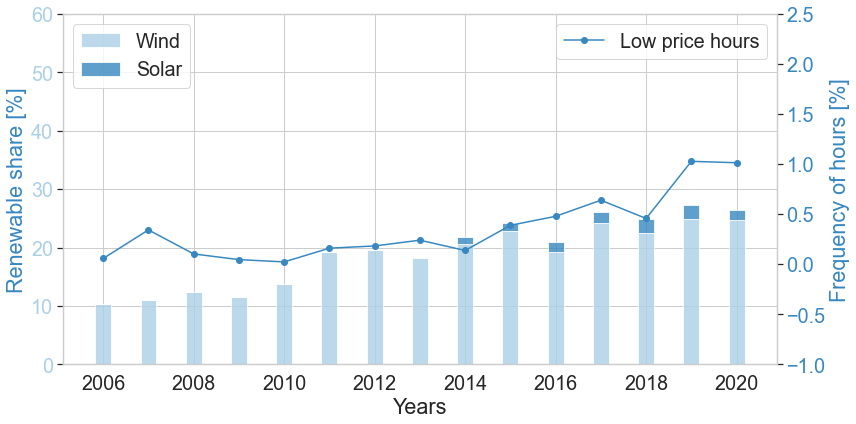

In [11]:
for area in df[price_areas].unique():
    
    years = df["year"].loc[df[price_areas]==area].unique()

    solar_share = np.zeros(len(years))
    wind_share = np.zeros(len(years))
    lp_hours = np.zeros(len(years))
    
    for i in np.arange(0, len(years)):
        
        dat = df.loc[(df[price_areas]==area) & (df["year"]==years[i])]
        
        solar_share[i] = dat["solar_share"].mean()
        wind_share[i] = dat["wind_share"].mean()
        
        lp_hours[i] = (len(dat[price_col].loc[dat[price_col]<=0])/len(dat[price_col]))*100
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    
    ax.bar(years, wind_share, bar_width, align='center', alpha=opacity, color=my_colors[0], label='Wind')
    ax.bar(years, solar_share, bar_width, bottom=wind_share, align='center', alpha=opacity, color=my_colors[1], label='Solar')

    ax.legend(loc="upper left")
    ax.grid()
    ax.set_xlabel("Years")
    ax.set_ylabel("Renewable share [%]", color=my_colors[1])
    
    ax.tick_params(axis="both", which="major")
    
    ax2 = ax.twinx()
    
    ax2.plot(years, lp_hours, marker="o", color=my_colors[1], label='Low price hours')
    
    ax2.set_ylabel("Frequency of hours [%]", color=my_colors[1])
    
    if (area=='DK1'):
        ax.set_ylim(0,80)
        ax2.set_ylim(-1.5, 3.0)
    else:
        ax.set_ylim(0,60)
        ax2.set_ylim(-1.0, 2.5)
        
    ax2.legend(loc=0)
    
    ax.tick_params(axis='y', labelcolor=my_colors[0])
    ax2.tick_params(axis='y', labelcolor=my_colors[1])
    
    plt.tight_layout()
    plt.savefig(figpath + "low_price_vres_shares_" + area + ".png", bbox_inches="tight", pad_inches=0.3)

### Section:3 - Analysis of the residual load curve

#### Definition of parameters

1. Mismatch ($\Delta$)
   
   $\Delta (t) = g(t) - l(t)$
   
2. vRES penetration level ($\alpha$)
   - $\alpha < 1$ on an average, generation is lower than demand
   - $\alpha < 1$ on an average, generation is equal to demand
   - $\alpha > 1$ on an average, generation is higher than demand
   
3. solar share ($\beta$)
   - due to the scaling style, wind share is $1-\beta$
   
   
#### Main references:

1. Morten Grud Rasmussen (2012): Storage and balancing synergies in a fully or highly renewable pan-European power system
2. Dominik Heide (2011): Reduced storage and balancing needs in a fully renewable European power system with excess wind and solar power generation

2014
2015
2016
2017
2018
2019
2020


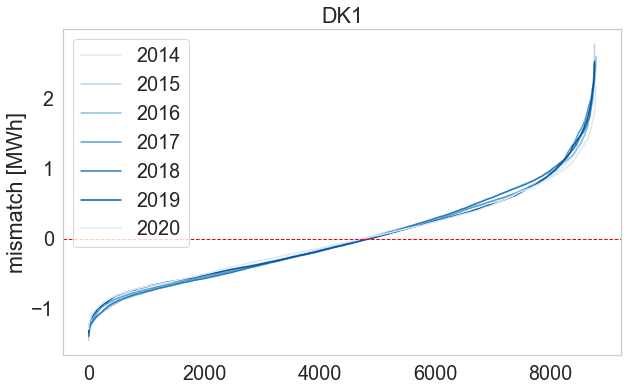

2014
2015
2016
2017
2018
2019
2020


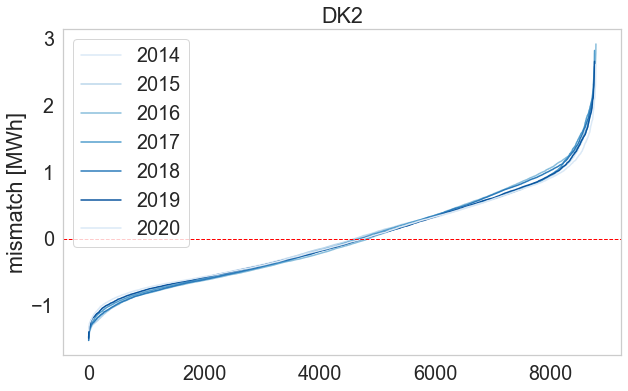

In [12]:
alpha = 1.0
beta = 0.3

df = df.loc[df['year']>=solar_start_year].copy()

for area in df[price_areas].unique():
    
    plt.figure(figsize=(10,6))
    
    for year in df['year'].unique():
        print(year)
        
        el = df.loc[(df[price_areas]==area) & (df['year']==year)].copy()
        el = get_upscaled_gen(el, S, W, L)
        
        el['mismatch'] = (alpha * ((beta * (el[up_s])) + ((1-beta) * el[up_w]))) - el[l]
        sorted_el = el.sort_values(by=['mismatch'], ascending=True)
        
        plt.plot(np.arange(0, len(sorted_el)), sorted_el['mismatch'].values, label=str(year))
        
    plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
    plt.legend()
    plt.ylabel('mismatch [MWh]')
    plt.title(area)
    plt.show()

#### Check diurnal variability of residual load for different seasons

Winter
Spring
Summer
Fall
Winter
Spring
Summer
Fall


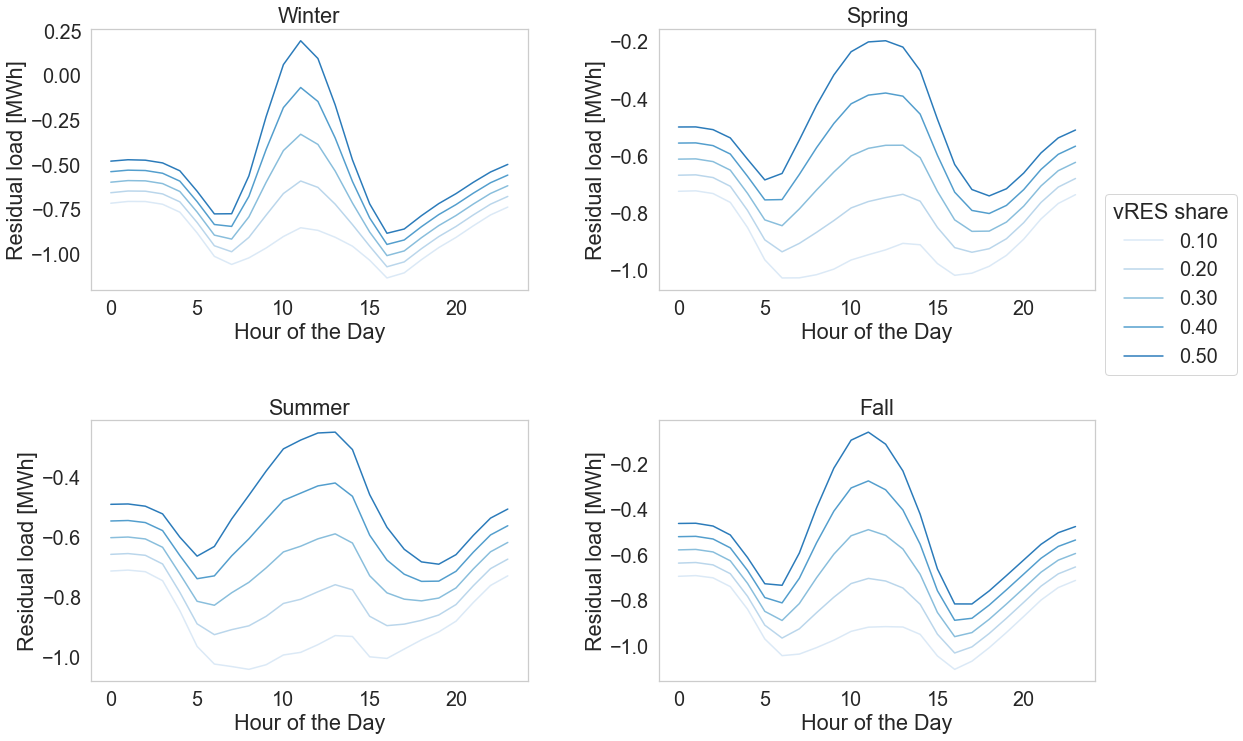

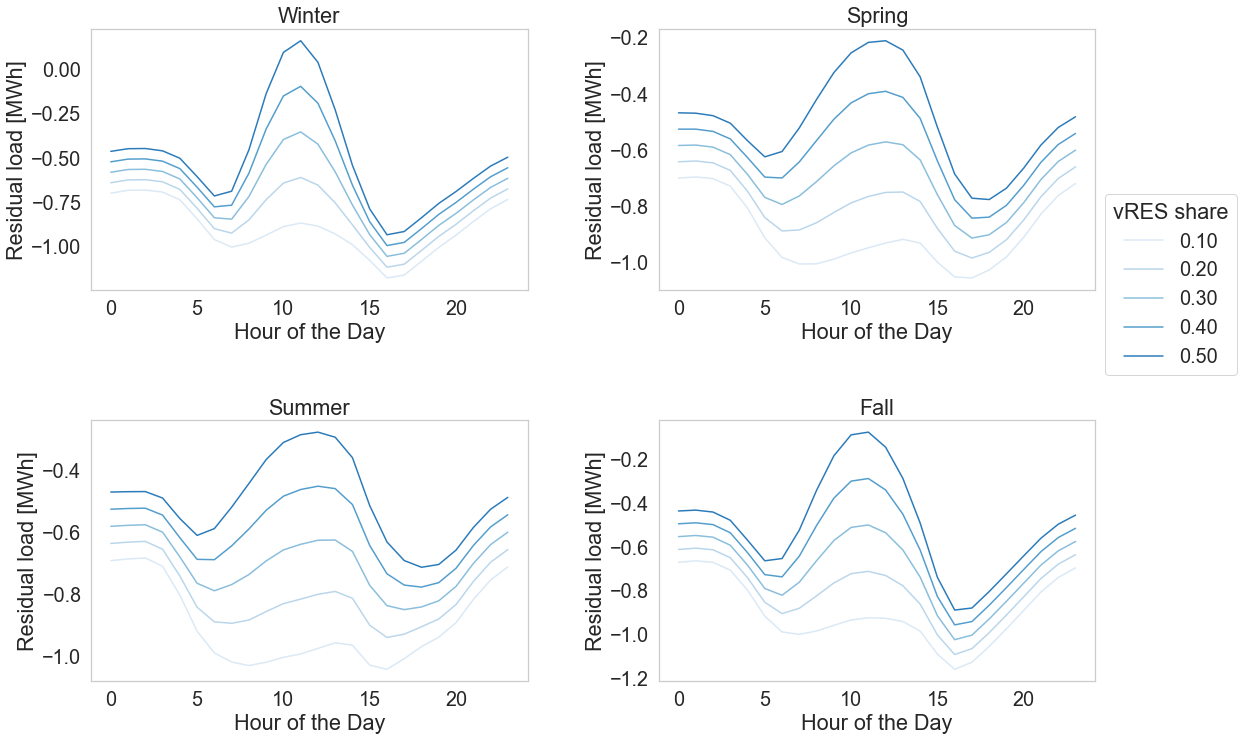

In [13]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
beta = 0.4

df = df.loc[df['year']>=solar_start_year].copy()

for area in df[price_areas].unique():
    
    fig, axs = plt.subplots(2,2,figsize=(18,12), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=0.5,wspace=0.3)
    
    axs = axs.ravel()
    i=0
    for season in df['seasons'].unique():
        print(season)
        
        el = df.loc[(df[price_areas]==area) & (df['seasons']==season)].copy()
        
        for alpha in alphas:
            
            el = get_upscaled_gen(el, S, W, L)
            el['mismatch'] = (alpha * ((beta * (el[up_s])) + ((1-beta) * el[up_w]))) - el[l] 
            
            hourly_avg_mismatch = el.groupby('hour')['mismatch'].mean()
        
            axs[i].plot(np.arange(0,24), hourly_avg_mismatch.values, linestyle='-', label="{:.2f}".format(alpha))
    
        if (i==1):
            axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.02), title='vRES share')
        axs[i].set_title(season)
        axs[i].set_xlabel('Hour of the Day')
        axs[i].set_ylabel('Residual load [MWh]')
        i=i+1
        
    plt.savefig(figpath + "diurnal_mismatch_alphas_beta_" + str(beta) + "_" + area + ".png", bbox_inches="tight", pad_inches=0.3)

#### Influence of increasing vRES shares on the extreme ends of the residual curve

Can this also be connected to the changes in spot price dynamics?

2014
2015
2016
2017
2018
2019
2020
2014
2015
2016
2017
2018
2019
2020


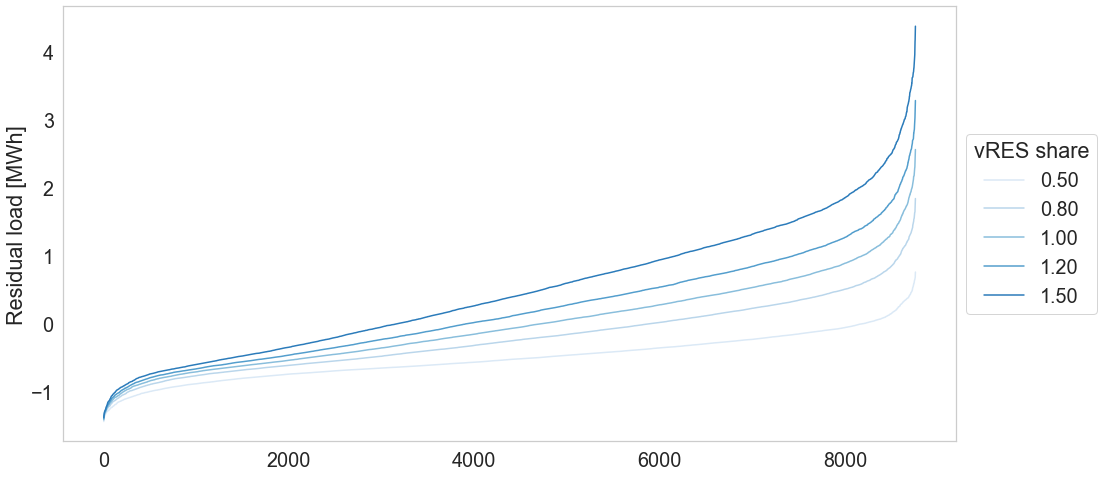

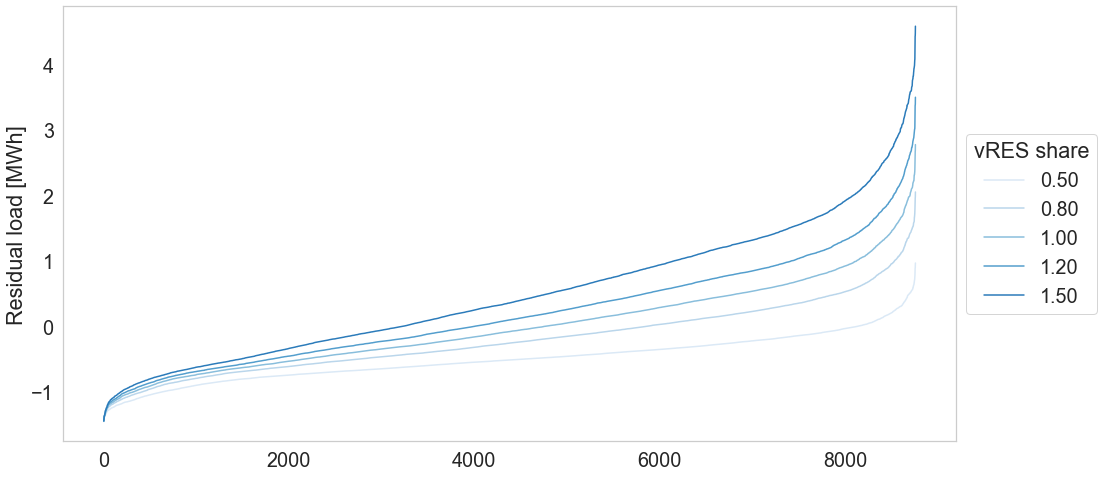

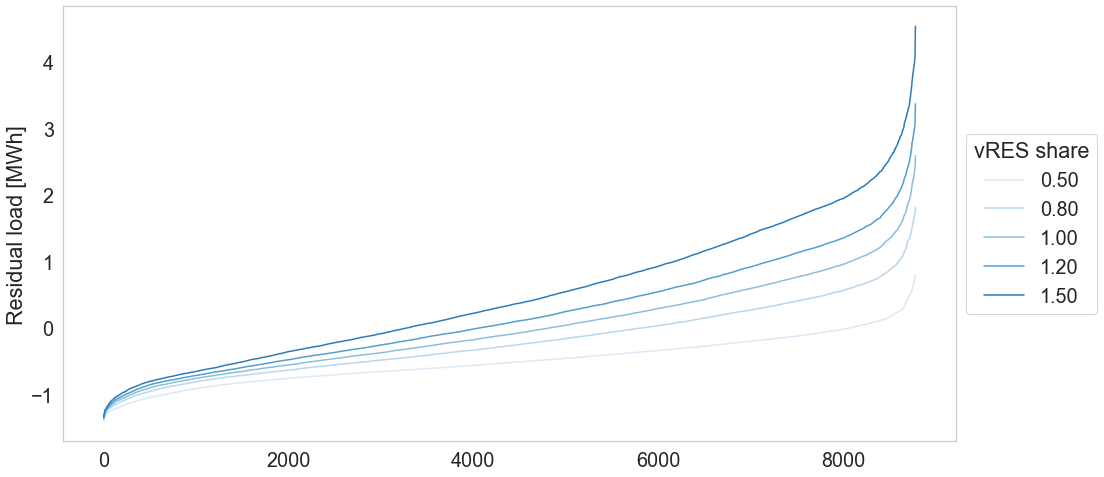

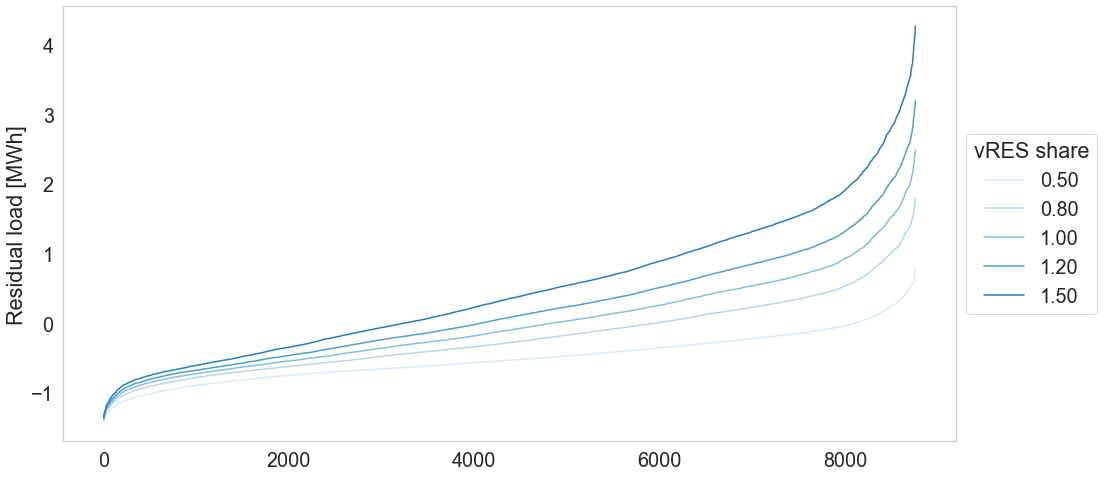

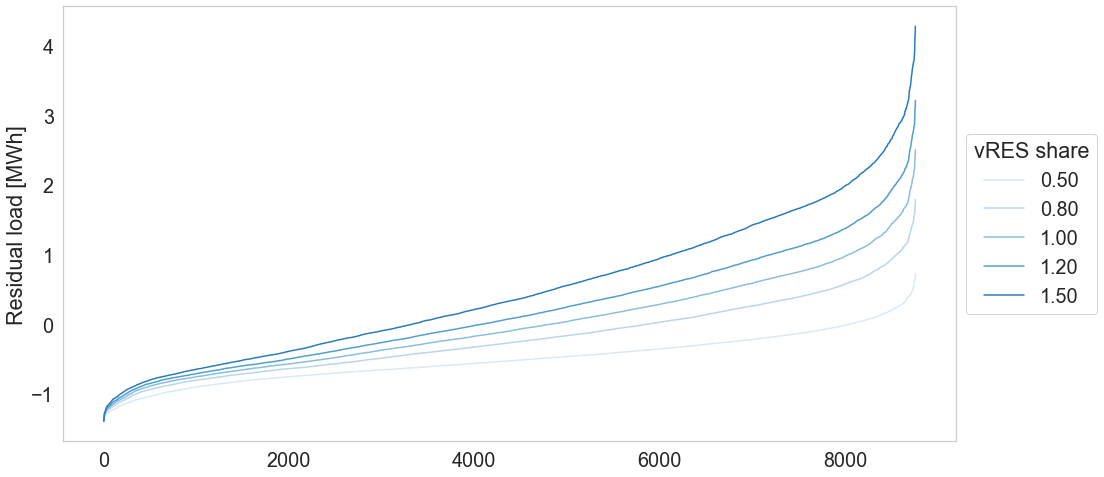

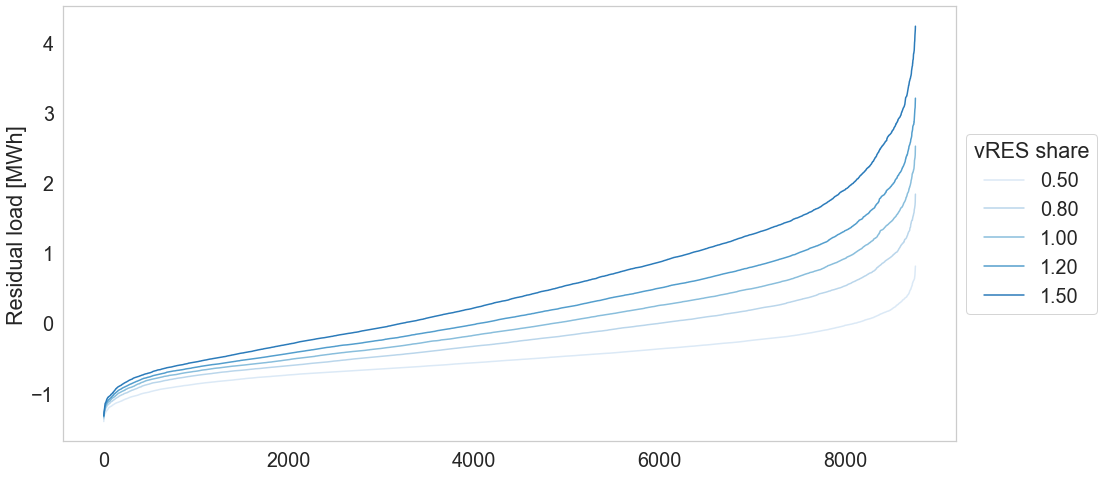

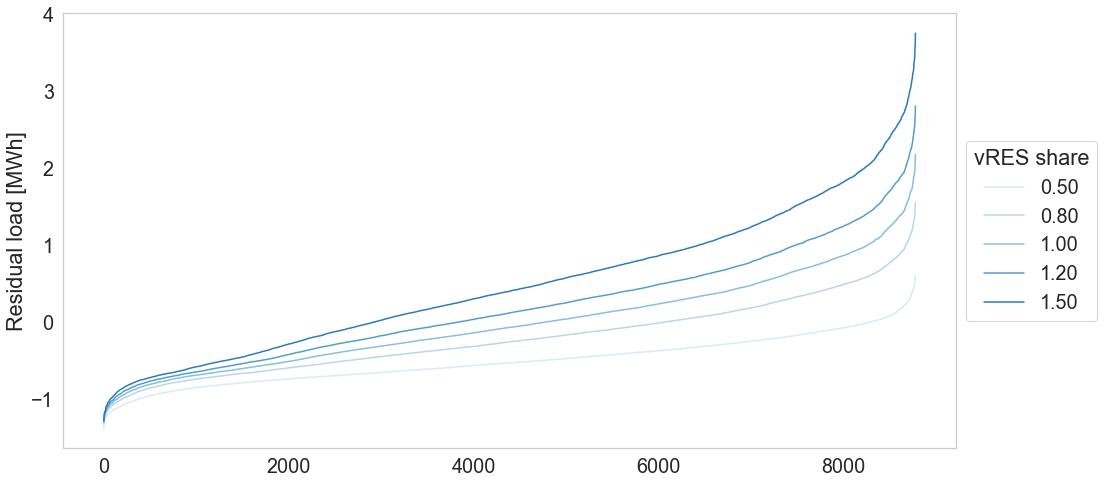

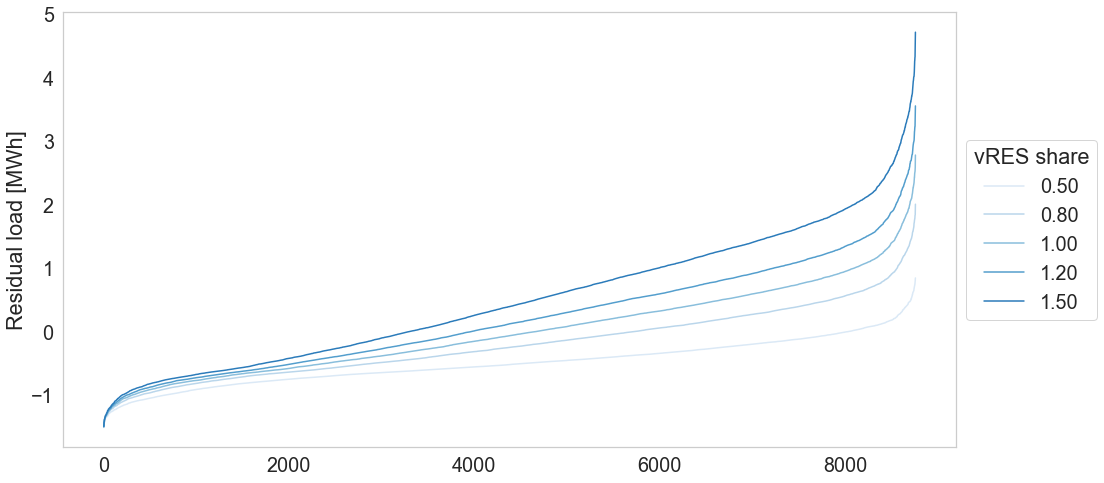

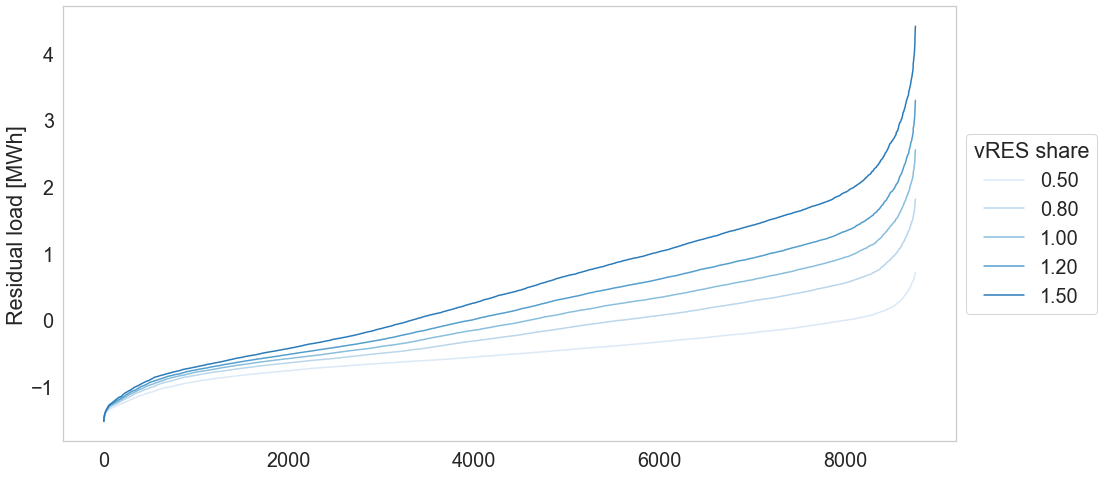

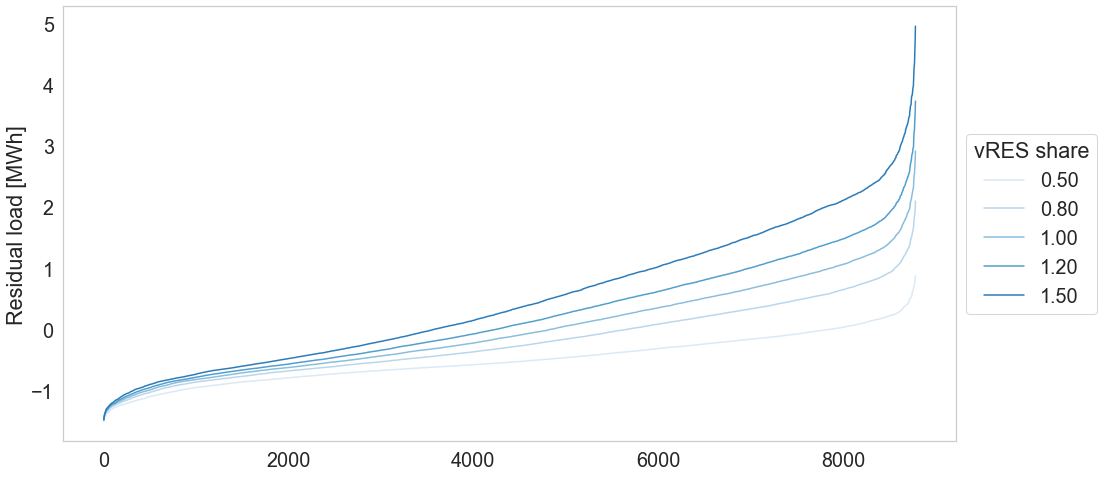

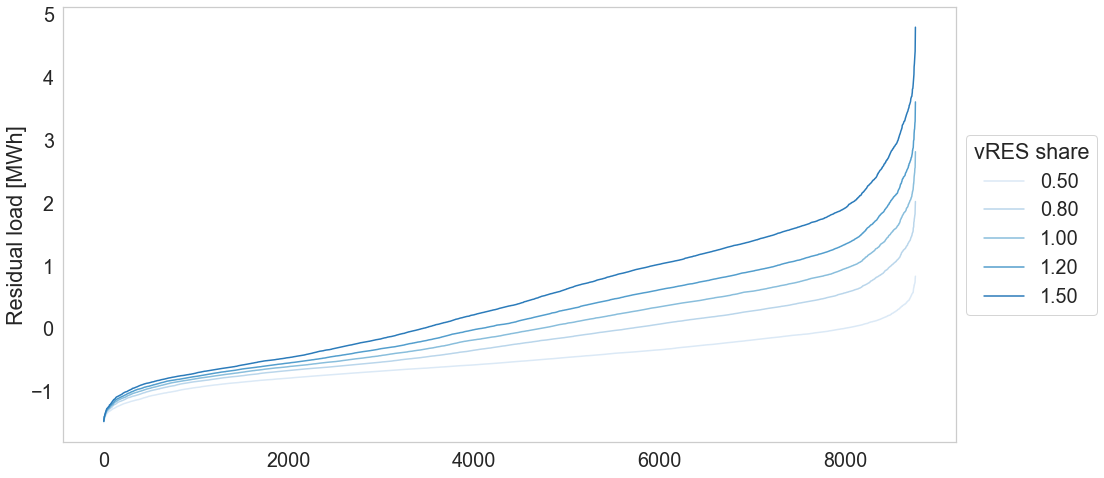

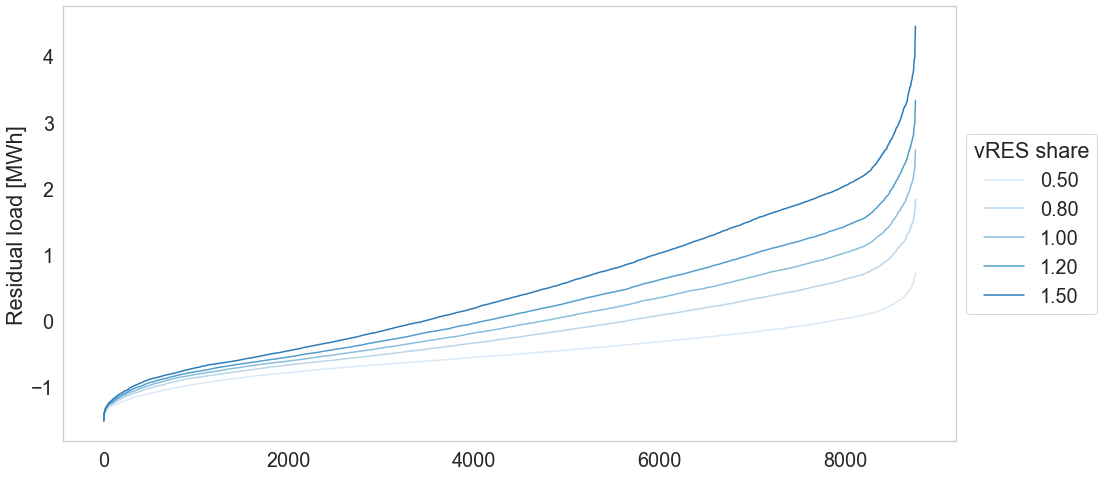

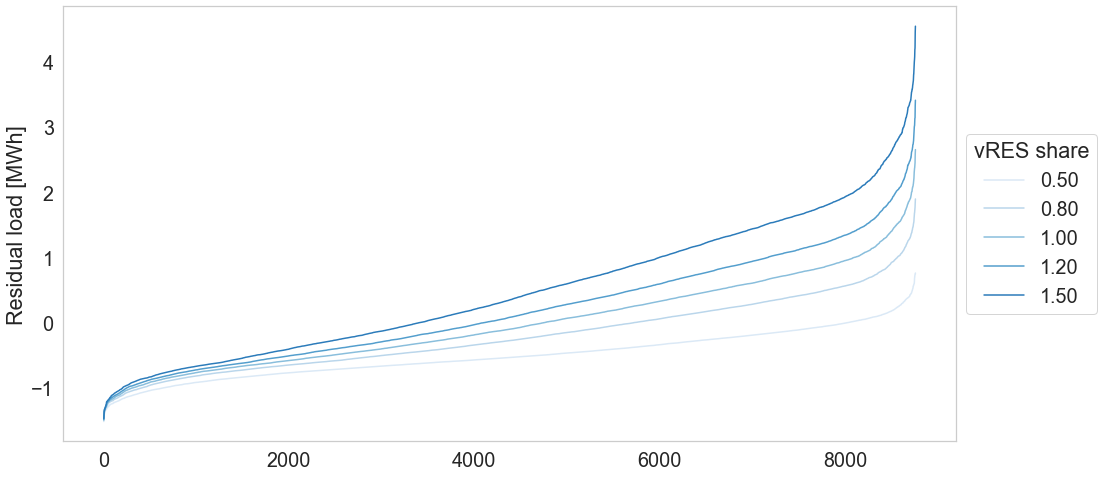

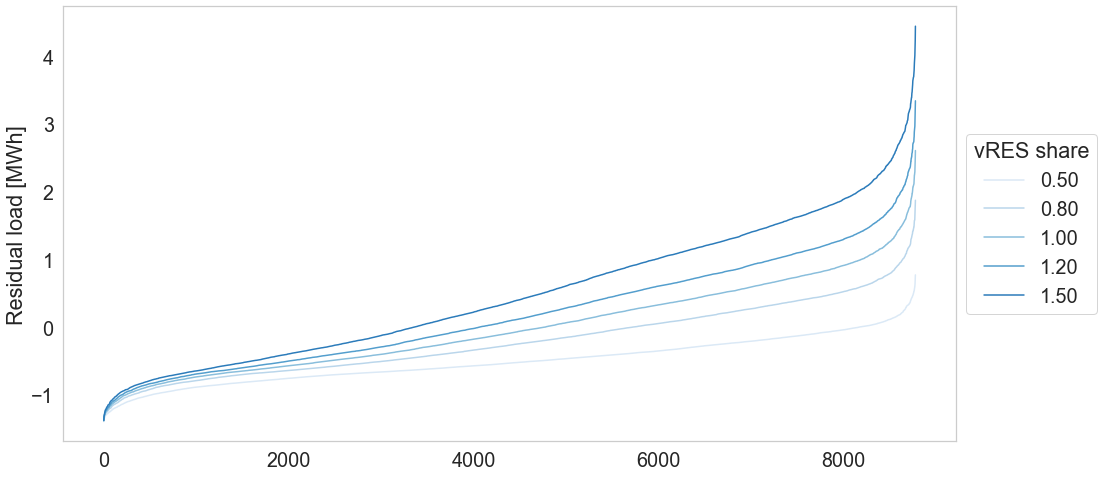

In [14]:
alphas = [0.5, 0.8, 1.0, 1.2, 1.5]
beta = 0.3

df = df.loc[df['year']>=solar_start_year].copy()

for area in df[price_areas].unique():
    
    for year in df['year'].unique():
        print(year)
        
        el = df.loc[(df[price_areas]==area) & (df['year']==year)].copy()
    
        plt.figure()
    
        for alpha in alphas:
            
            el = get_upscaled_gen(el, S, W, L)
            el['mismatch'] = (alpha * ((beta * (el[up_s])) + ((1-beta) * el[up_w]))) - el[l] 
              
            sorted_el = el.sort_values(by=['mismatch'], ascending=True)
        
            plt.plot(np.arange(0, len(sorted_el)), sorted_el['mismatch'].values, label="{:.2f}".format(alpha))
        
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='vRES share')
        plt.ylabel('Residual load [MWh]')
        plt.savefig(figpath + "sorted_mismatch_alphas_" + str(year) + "_" + area + ".png", bbox_inches="tight", pad_inches=0.3)

#### Let's look closely on a random week

2014
2015
2016
2017
2018
2019
2020
2014
2015
2016
2017
2018
2019
2020


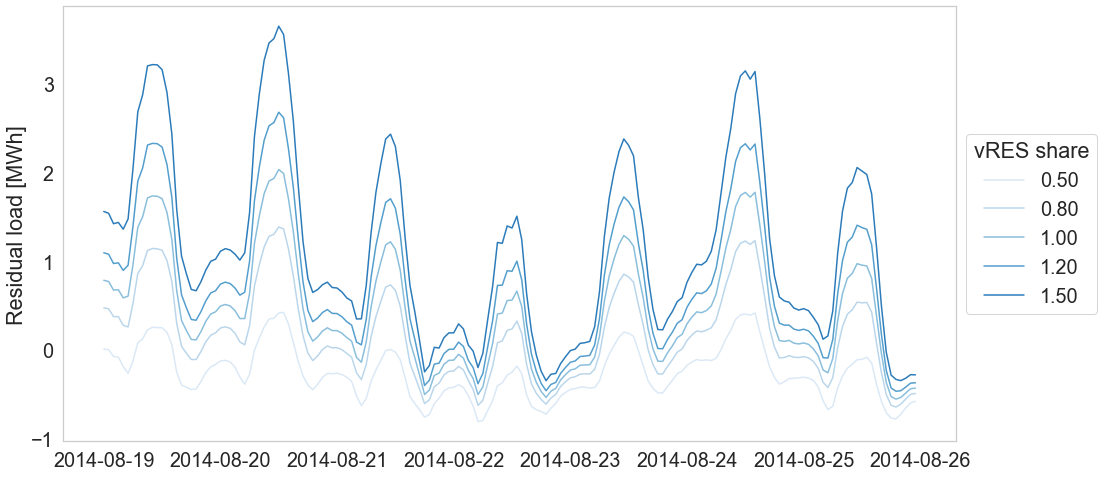

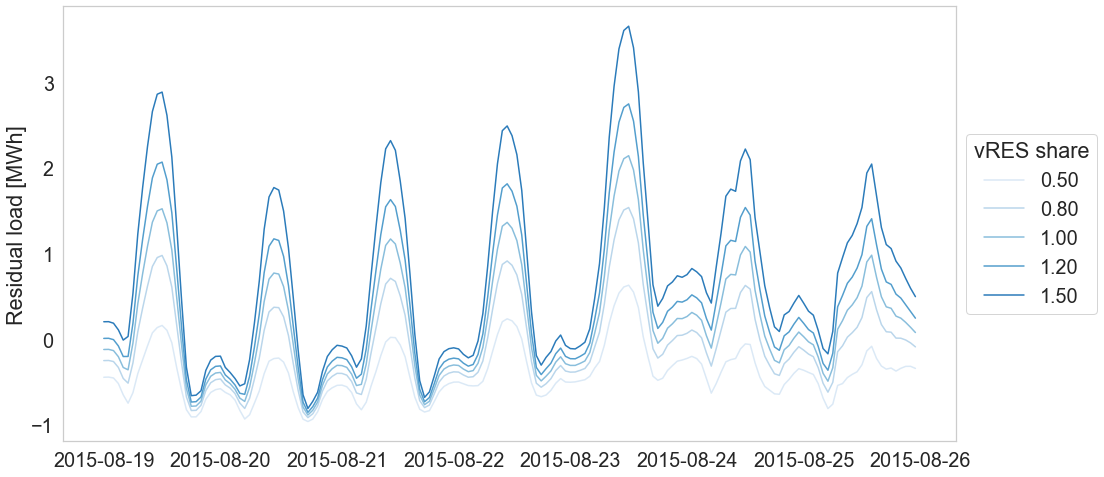

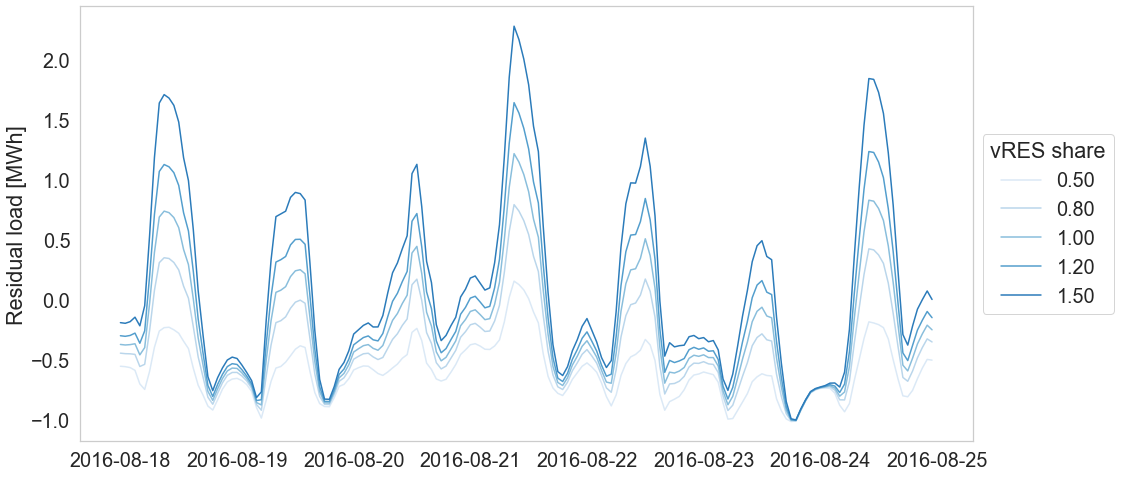

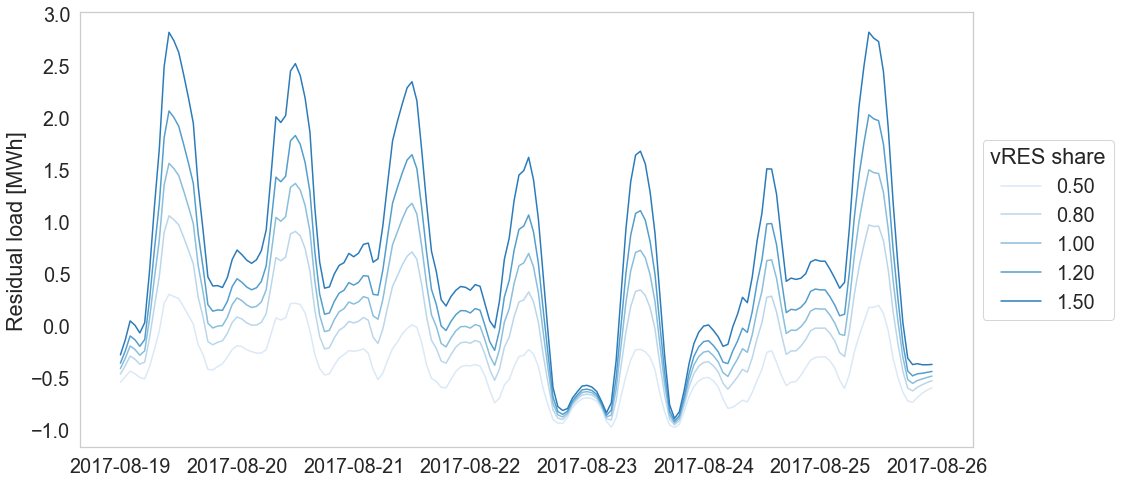

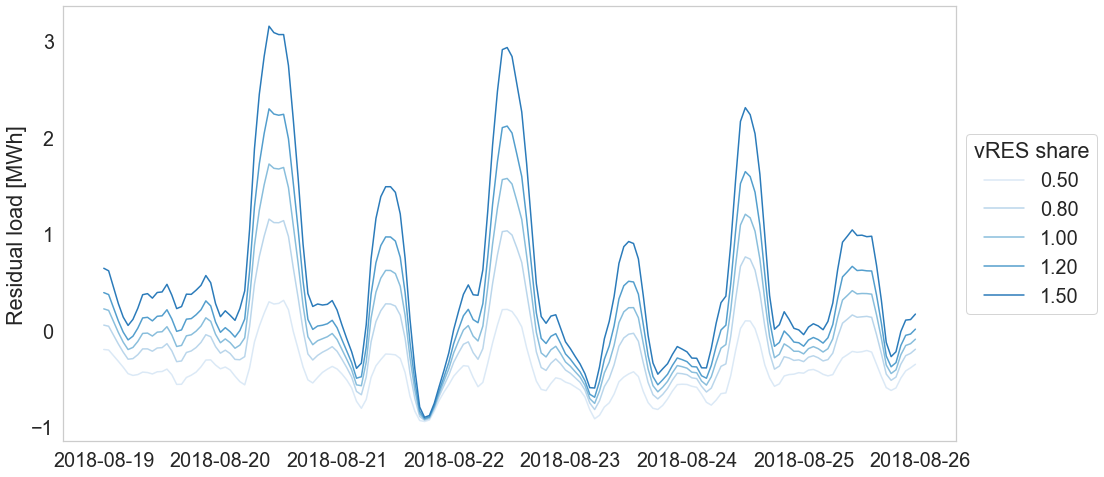

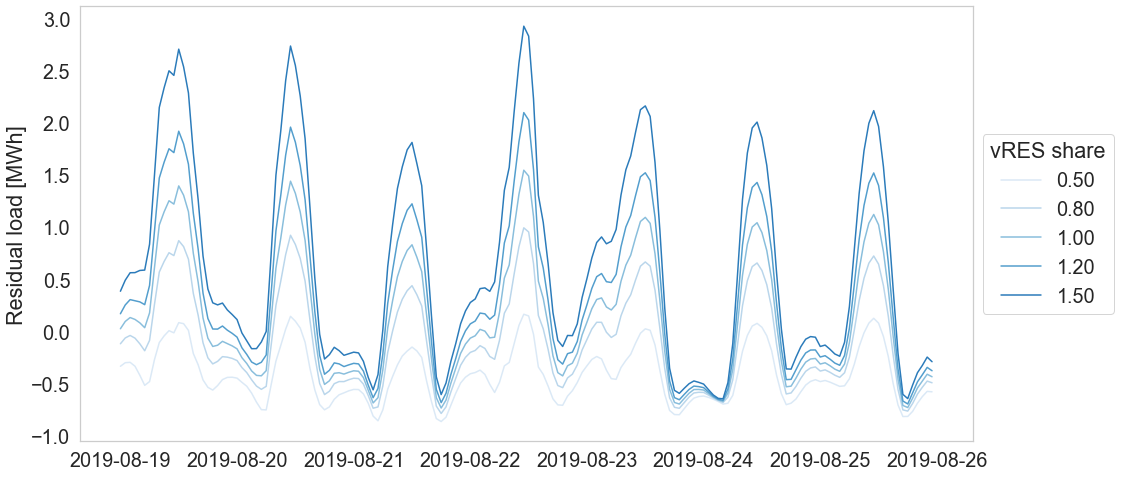

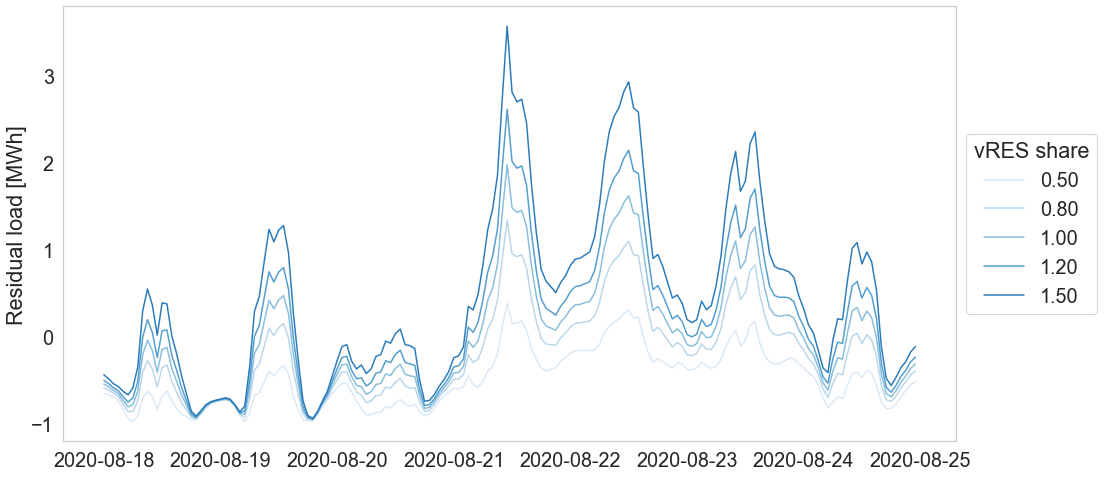

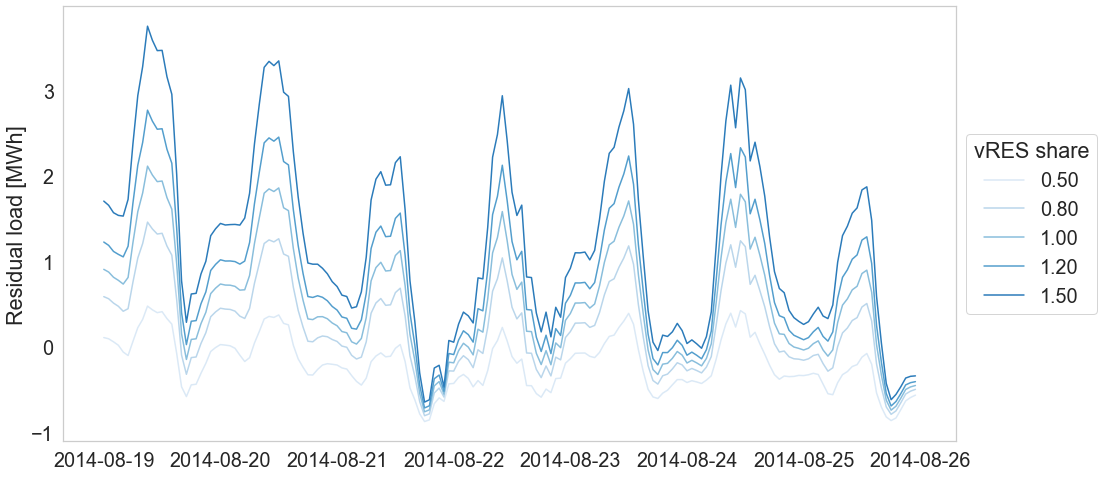

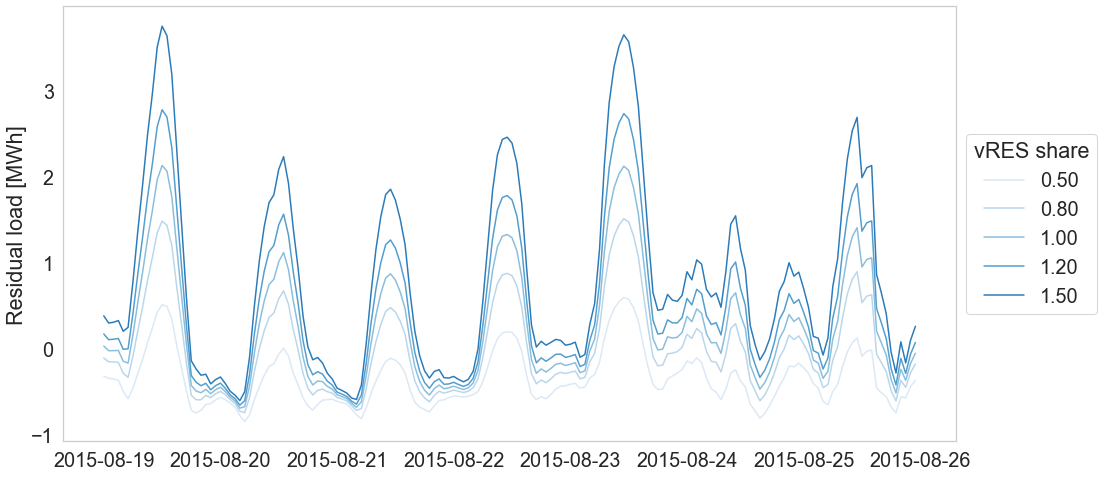

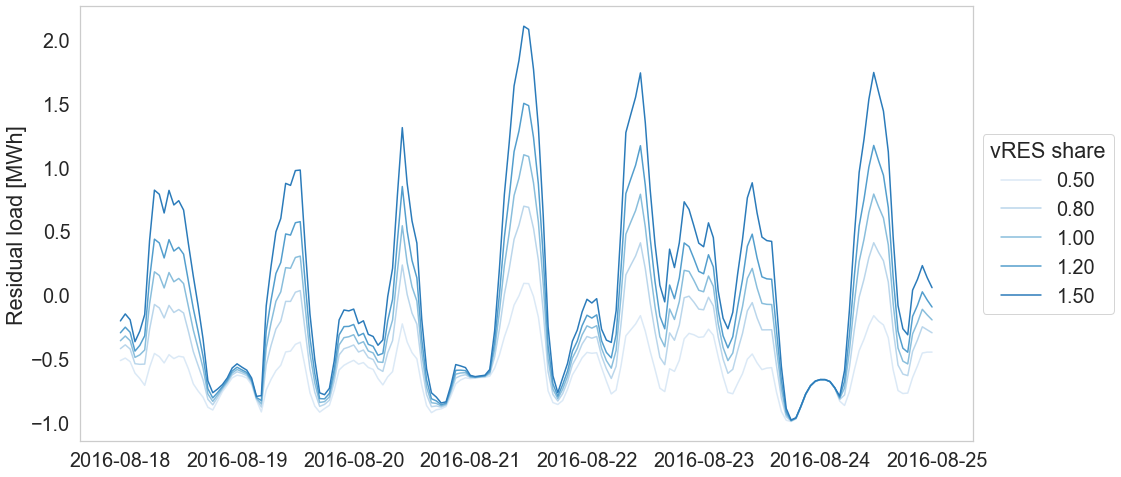

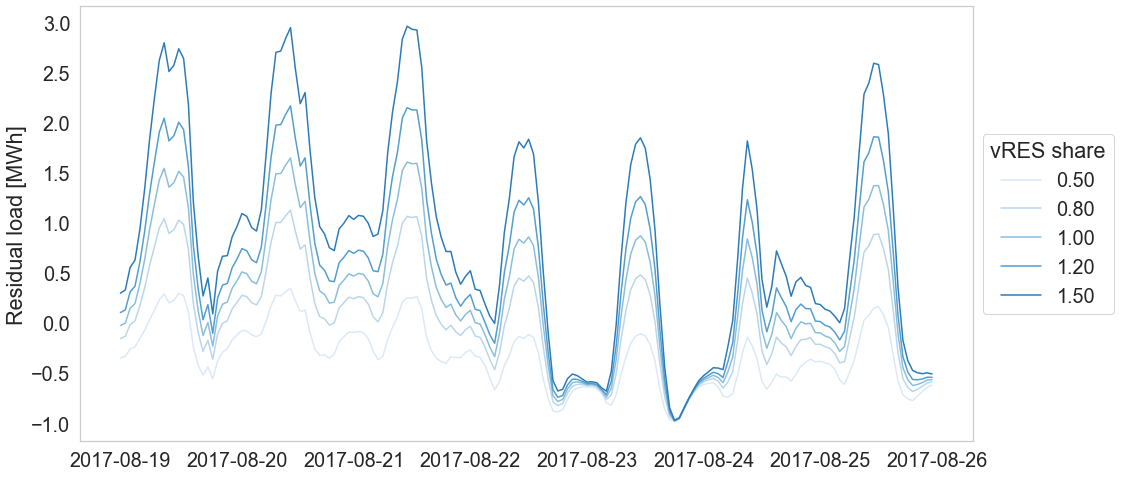

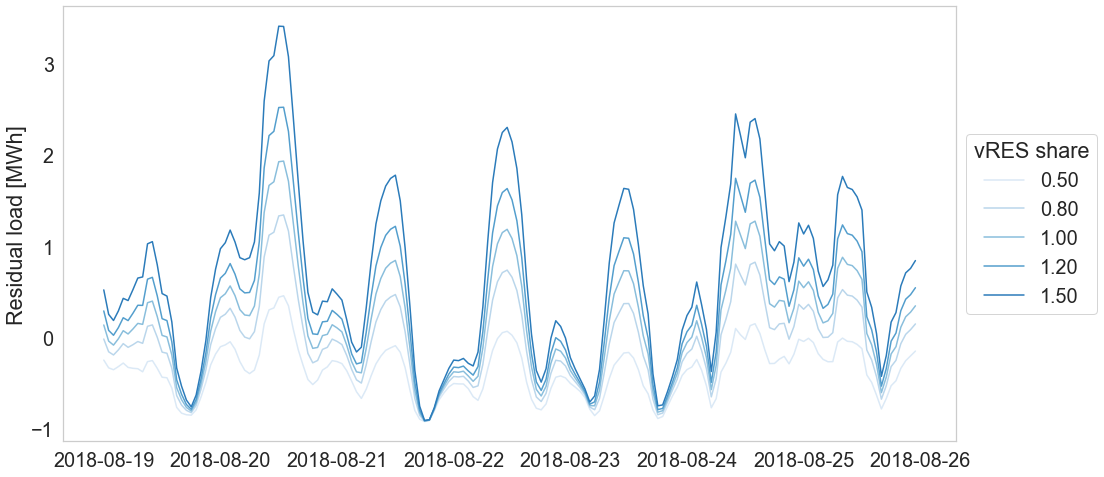

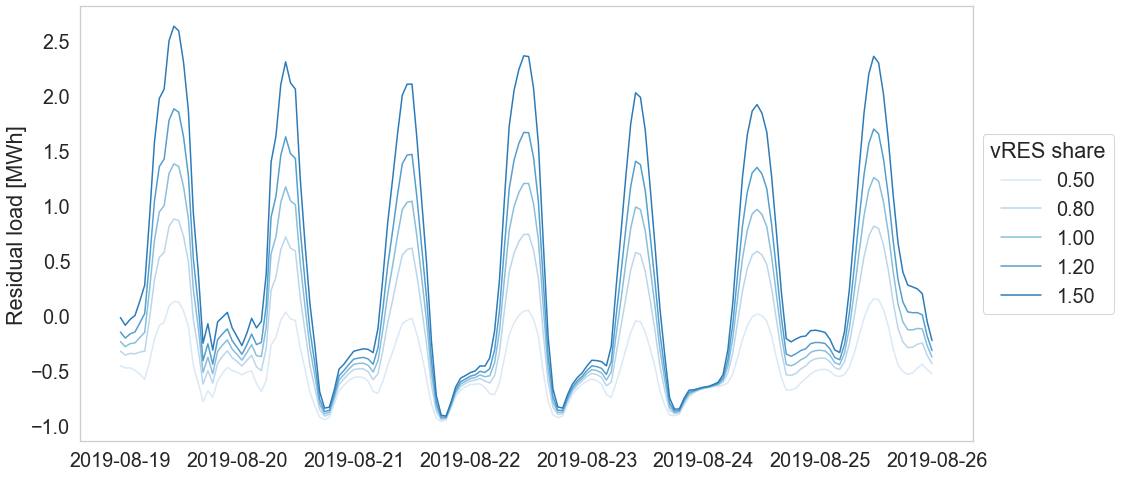

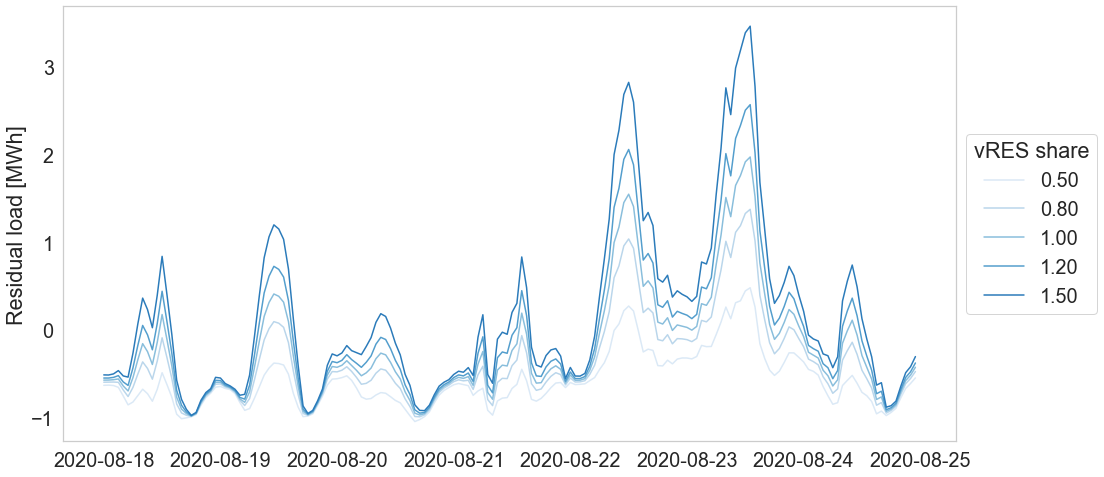

In [15]:
d1 = 230
d2 = d1 + 7 + 1

alphas = [0.5, 0.8, 1.0, 1.2, 1.5]
beta = 0.3

df = df.loc[df['year']>=solar_start_year].copy()

for area in df[price_areas].unique():
    for year in df['year'].unique():
        print(year)
        
        el = df.loc[(df[price_areas]==area) & (df['year']==year)].copy()
        
        plt.figure()
        
        for alpha in alphas:
            
            el = get_upscaled_gen(el, S, W, L)
            el['mismatch'] = (alpha * ((beta * (el[up_s])) + ((1-beta) * el[up_w]))) - el[l] 
        
            plt.plot(el['mismatch'].loc[(el['day_of_year']>d1) & (el['day_of_year']<d2)], label="{:.2f}".format(alpha))
        
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='vRES share')
        plt.ylabel('Residual load [MWh]')
        plt.savefig(figpath + "week_mismatch_alphas_" + str(year) + "_" + area + ".png", bbox_inches="tight", pad_inches=0.3)

#### Let's look into the synergies of vRES capacity and vRES shares on demanding for backup capacities

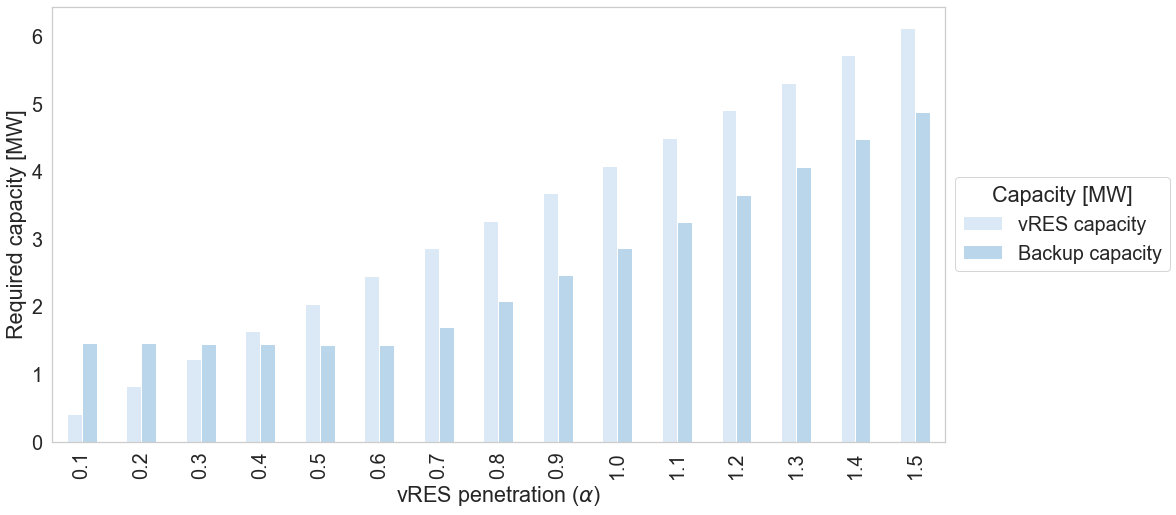

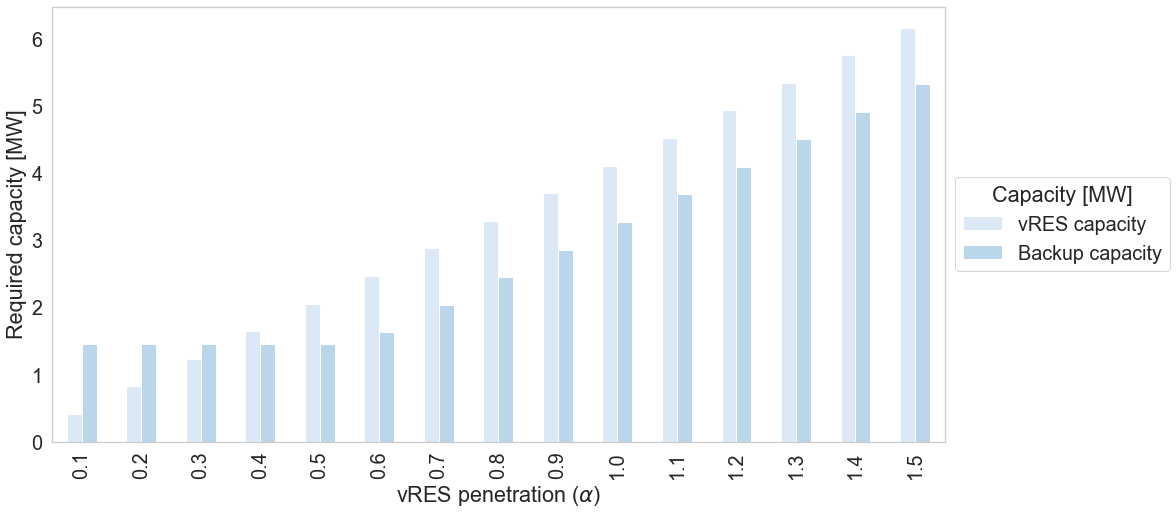

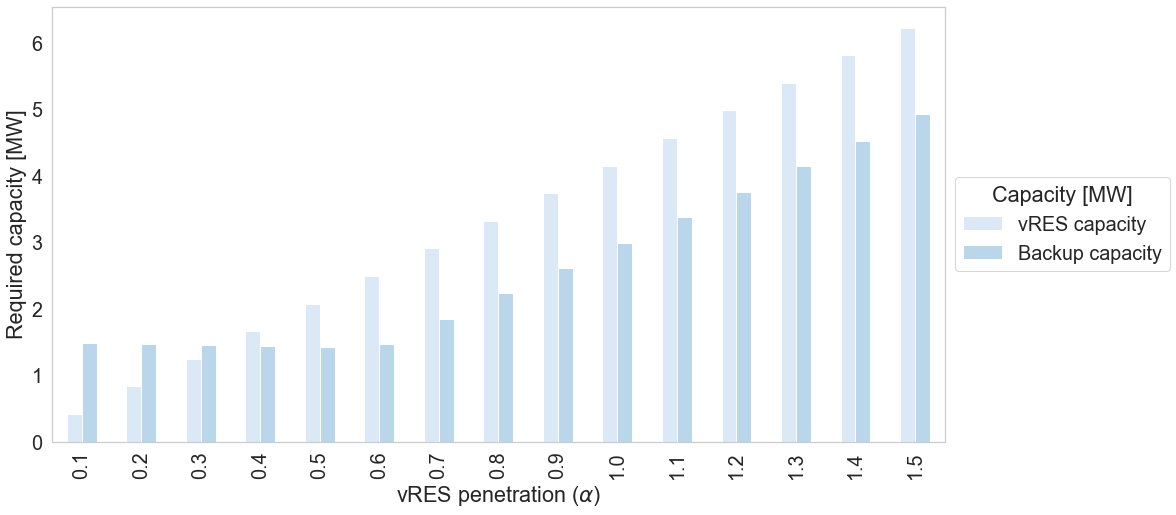

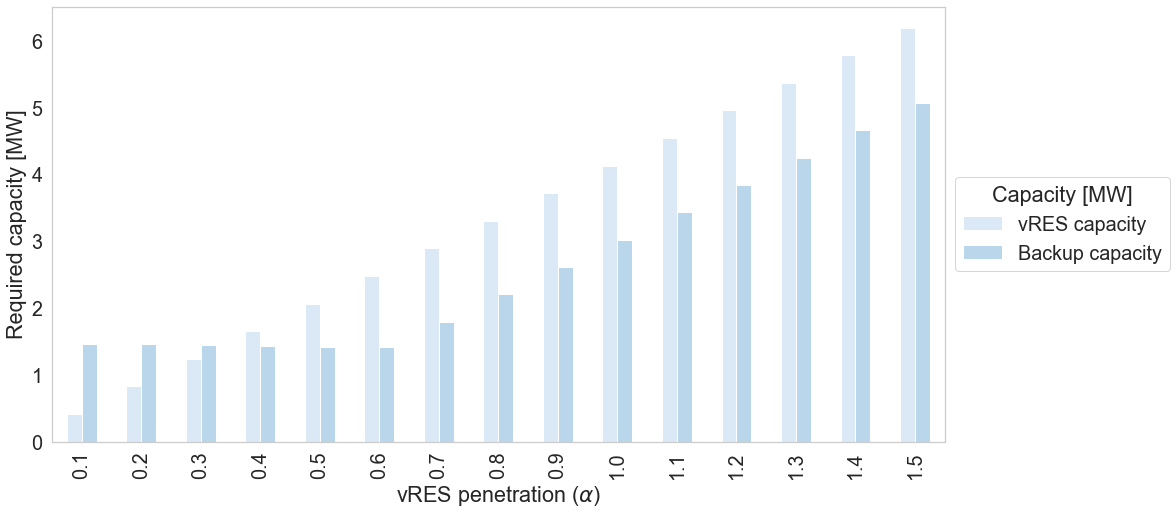

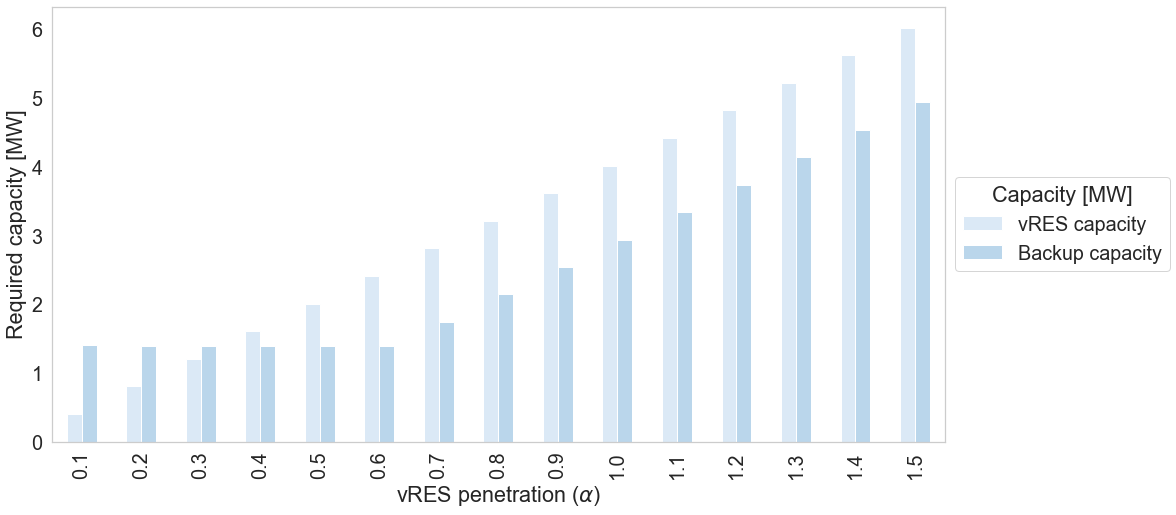

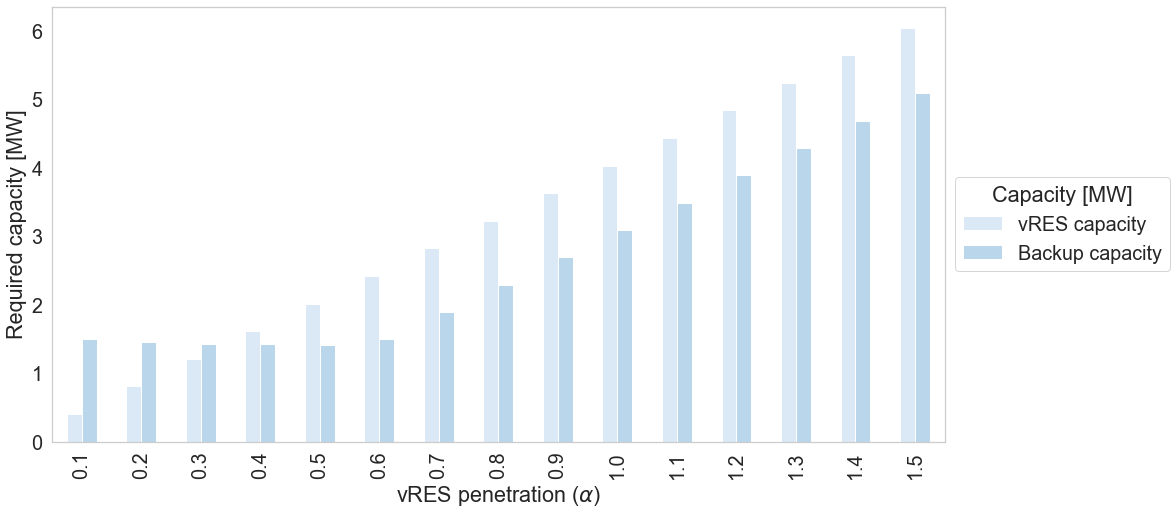

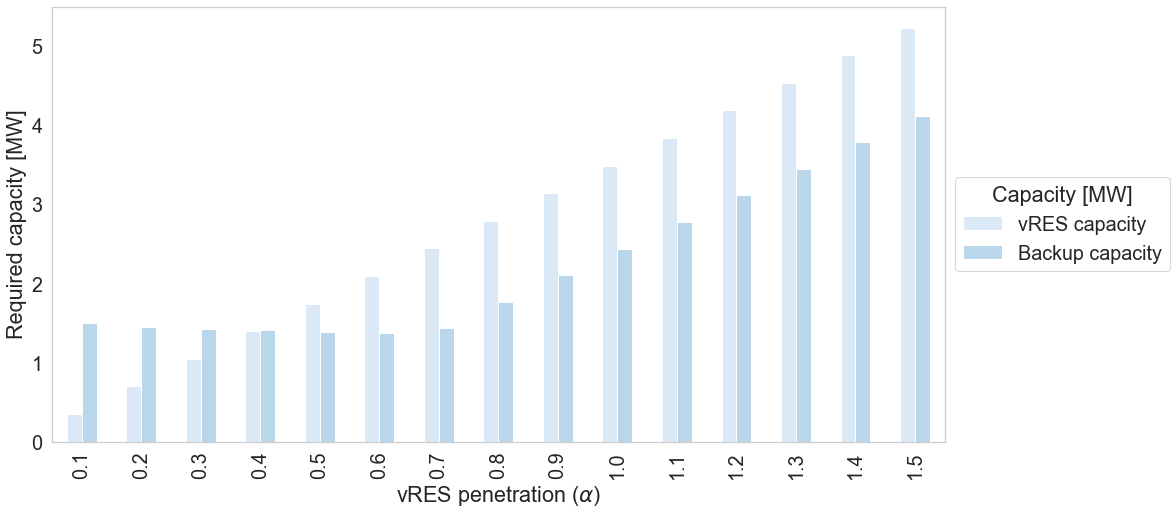

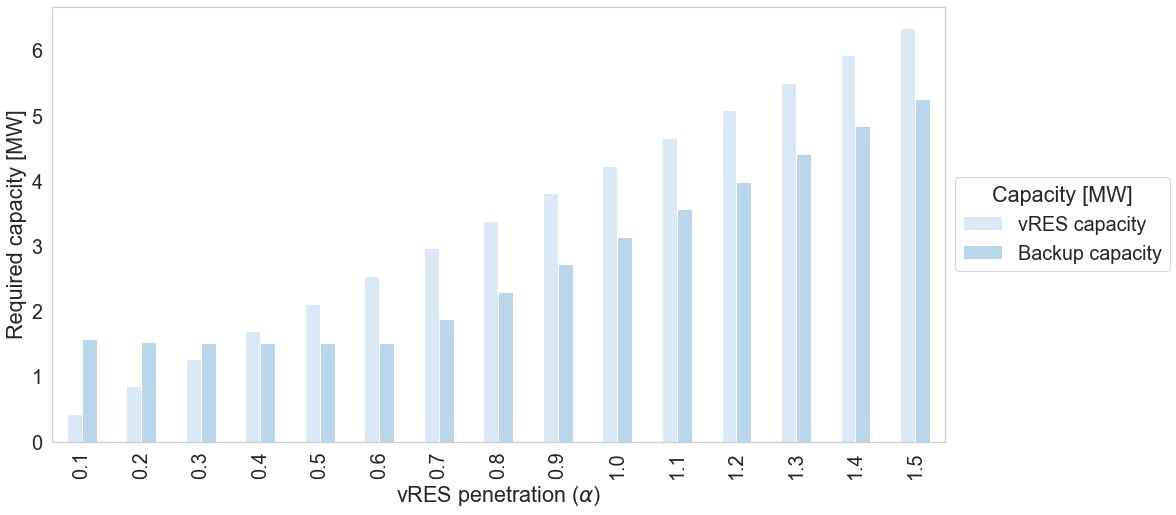

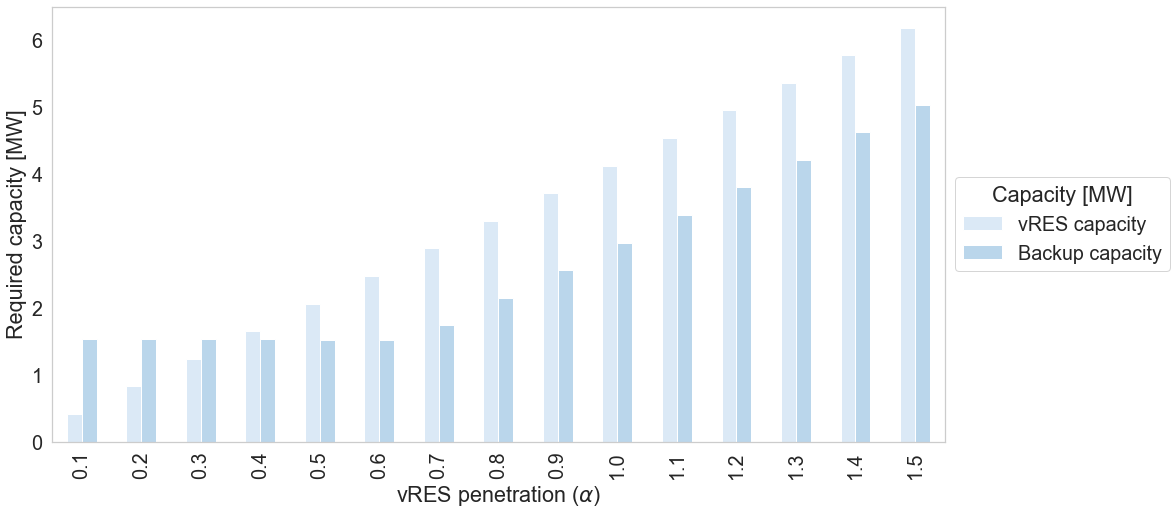

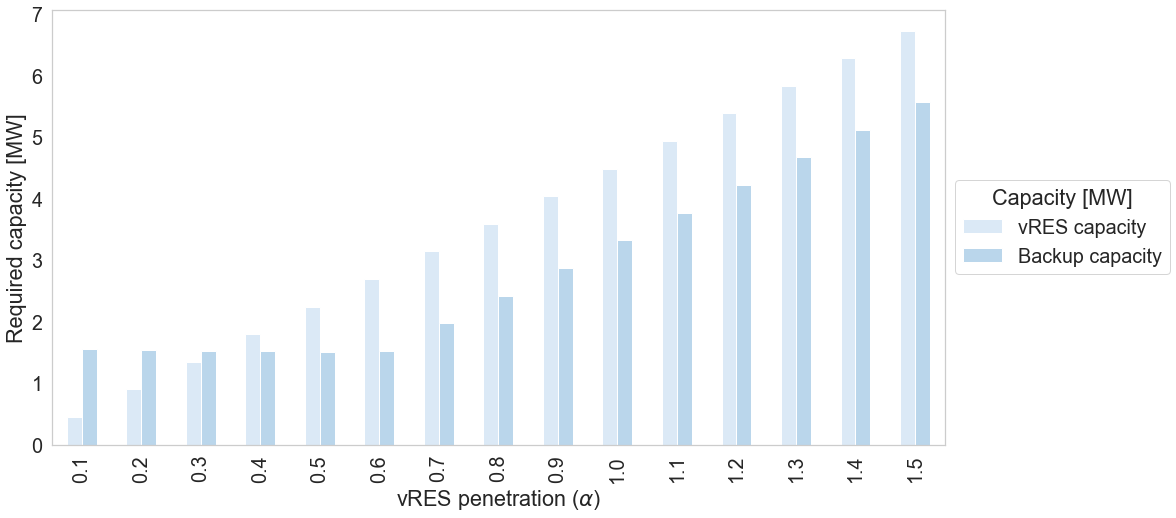

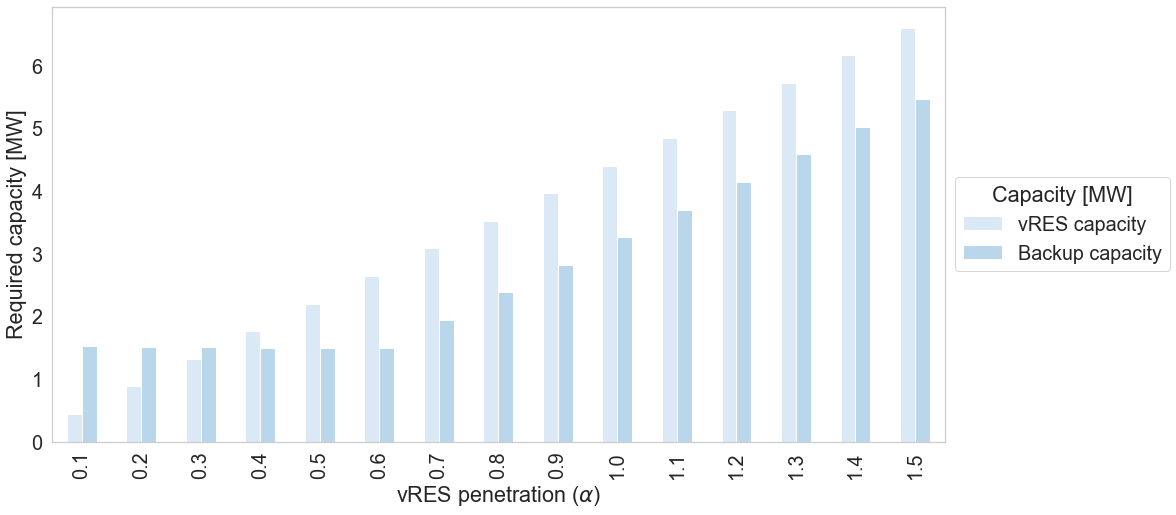

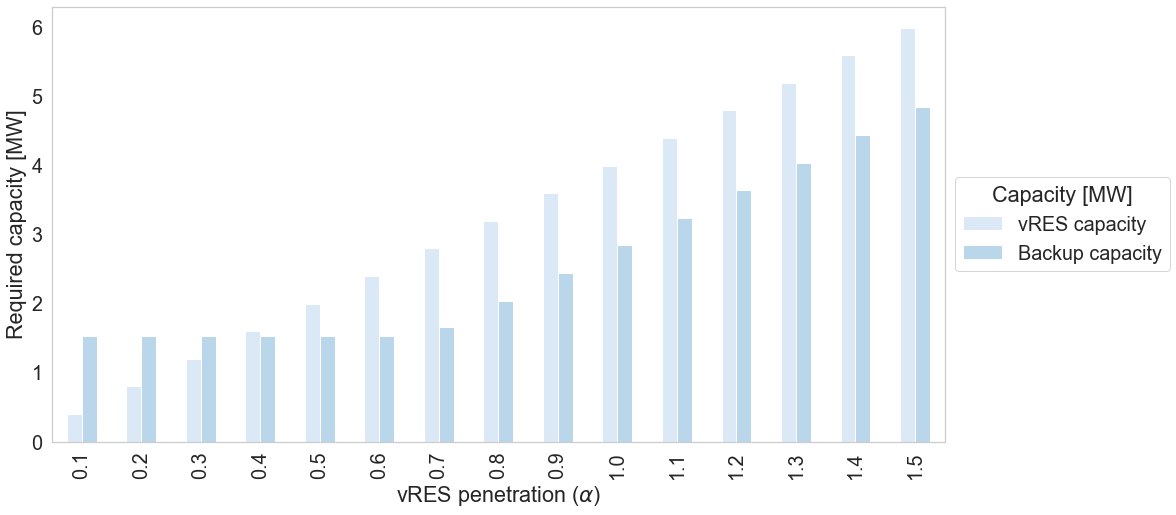

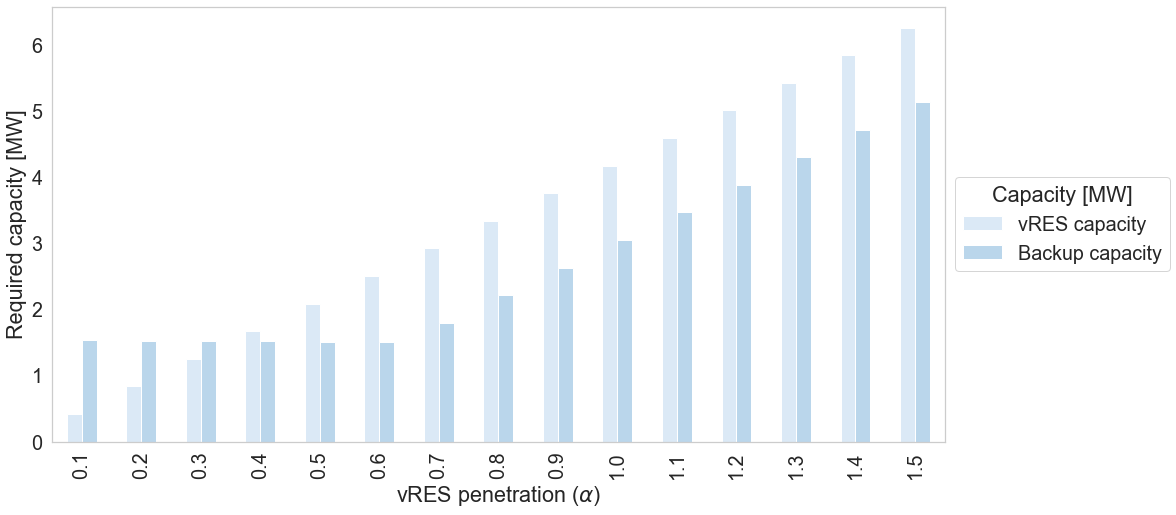

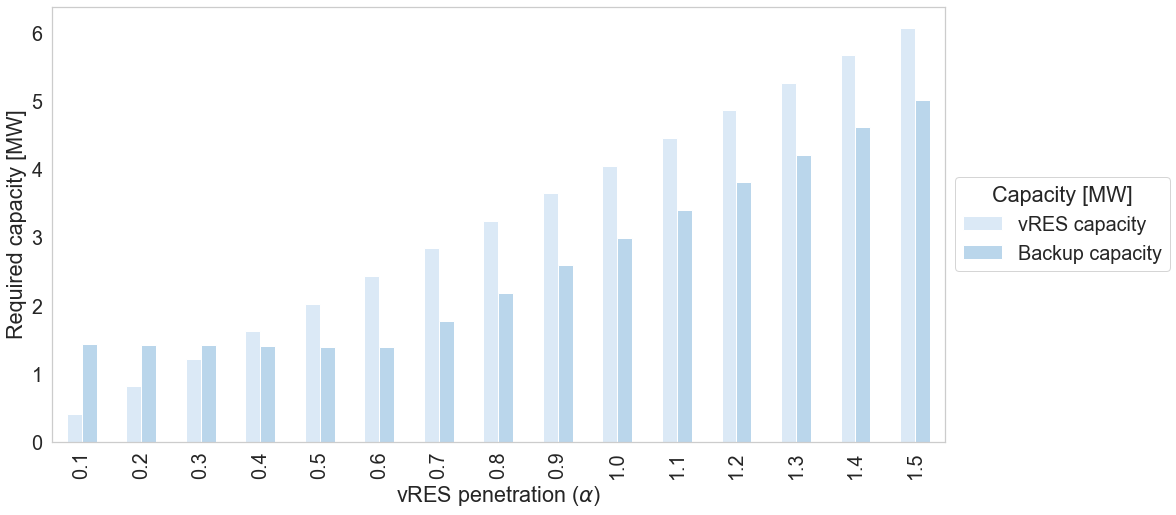

In [16]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
beta = 0.4

df = df.loc[df['year']>=solar_start_year].copy()

for area in df[price_areas].unique():
    for year in df['year'].unique():
        
        el = df.loc[(df[price_areas]==area) & (df['year']==year)].copy()
        vres_cap, ther_cap = [], []
        
        for alpha in alphas:
            
            el = get_upscaled_gen(el, S, W, L)
            el['mismatch'] = (alpha * ((beta * (el[up_s])) + ((1-beta) * el[up_w]))) - el[l] 
            el['g_new'] = alpha * ((beta * (el[up_s])) + ((1-beta) * el[up_w]))
            
            vres_cap.append(np.max(el['g_new']))
            ther_cap.append(np.max(np.abs(el['mismatch'])))
            
        new_df = pd.DataFrame({'vRES capacity':vres_cap, 'Backup capacity':ther_cap}, index=alphas)
    
        ax = new_df.plot(kind='bar', stacked=False)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Capacity [MW]')
        plt.ylabel('Required capacity [MW]')
        plt.xlabel(r'vRES penetration ($\alpha$)')
        ax.set_xticklabels(alphas)
        plt.savefig(figpath + "capacity_req_alphas_" + str(year) + "_" + area + ".png", bbox_inches="tight", pad_inches=0.3)   

#### Understanding the ramp of the residual load: average ramps

2014
2015
2016
2017
2018
2019
2020
2014
2015
2016
2017
2018
2019
2020


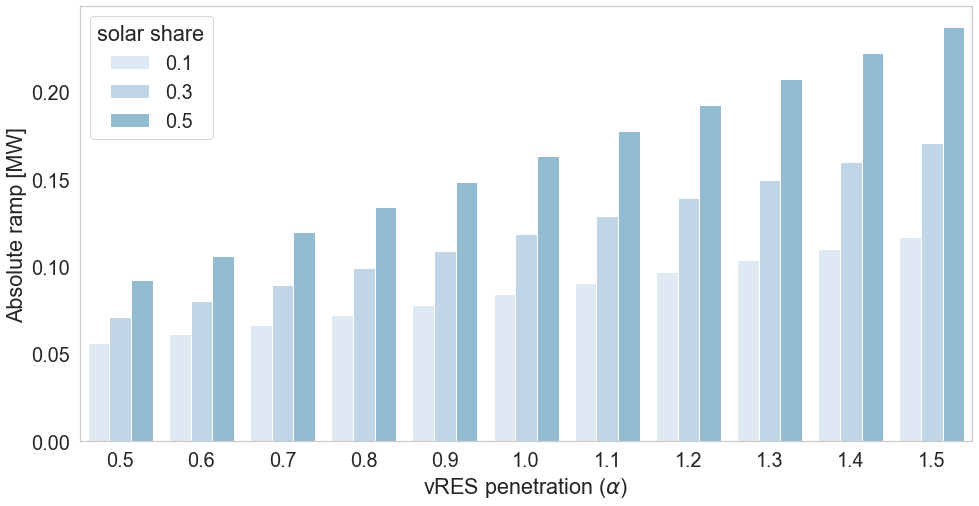

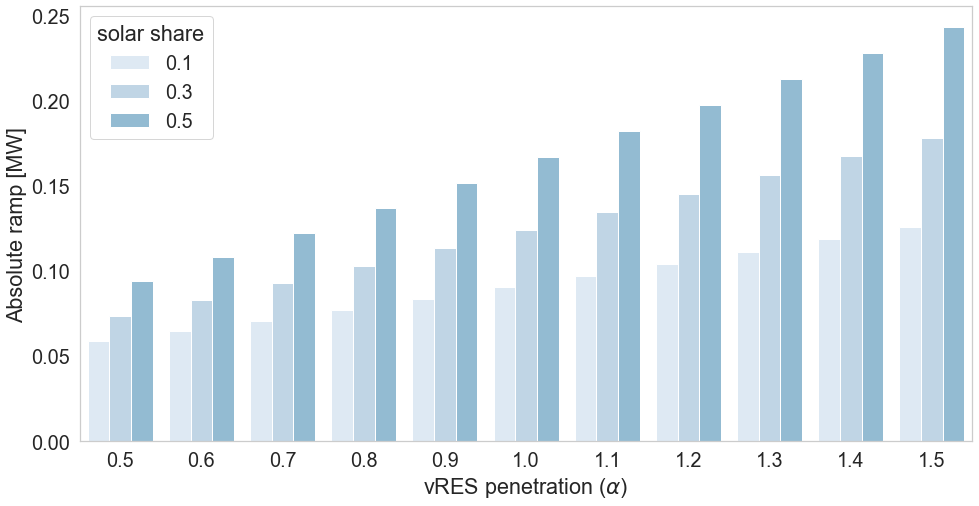

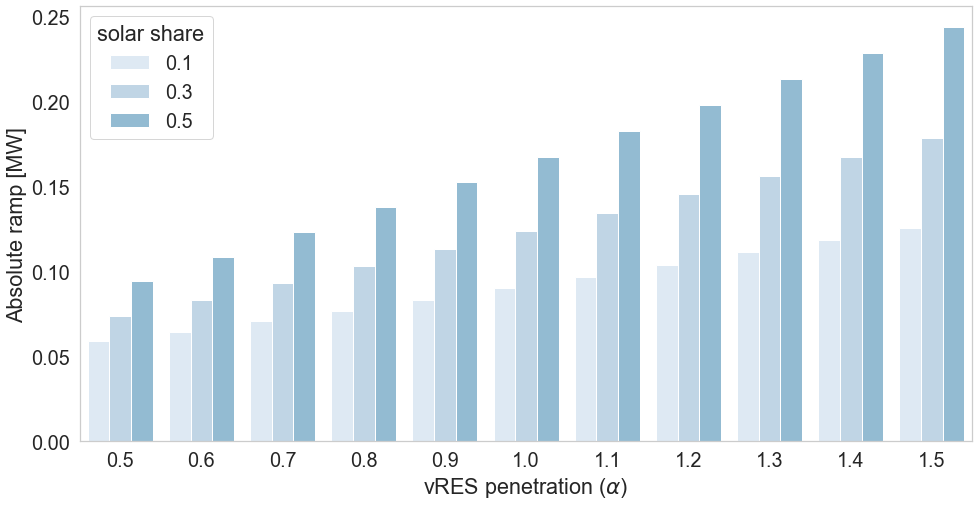

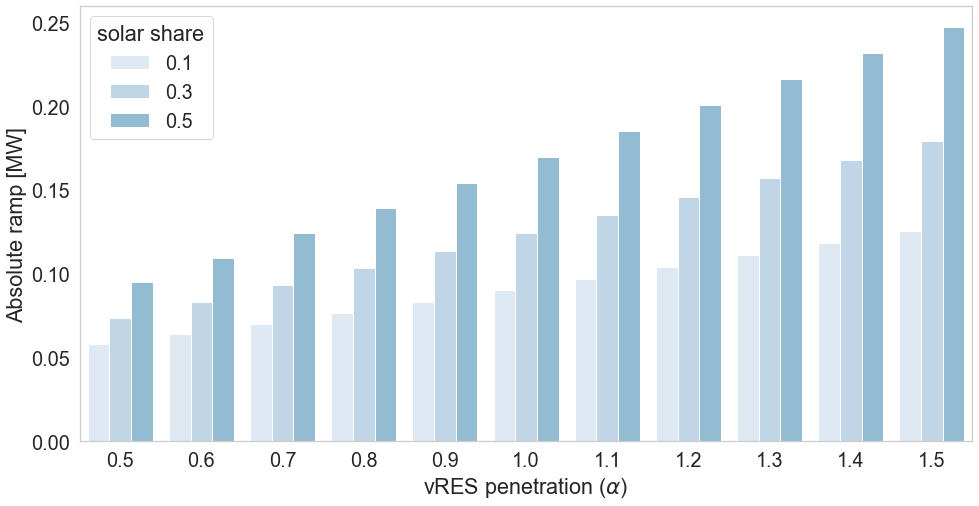

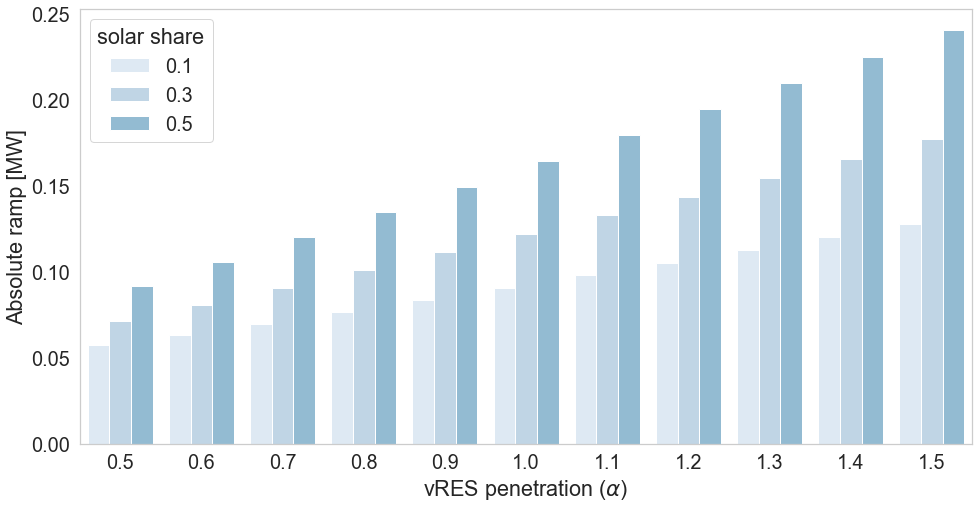

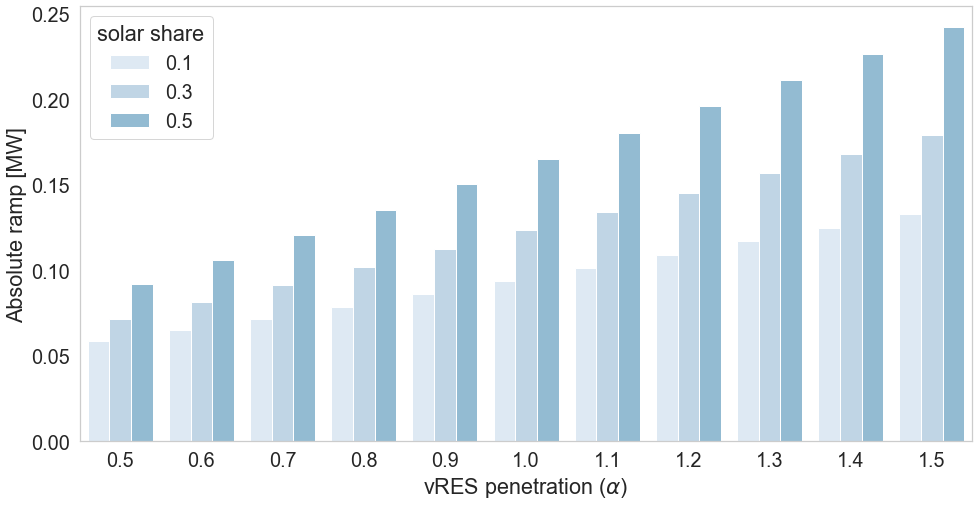

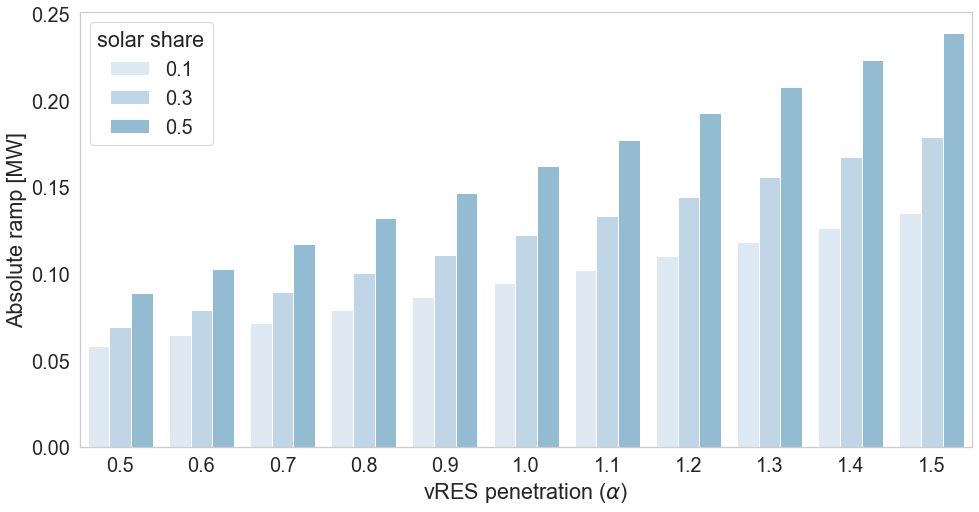

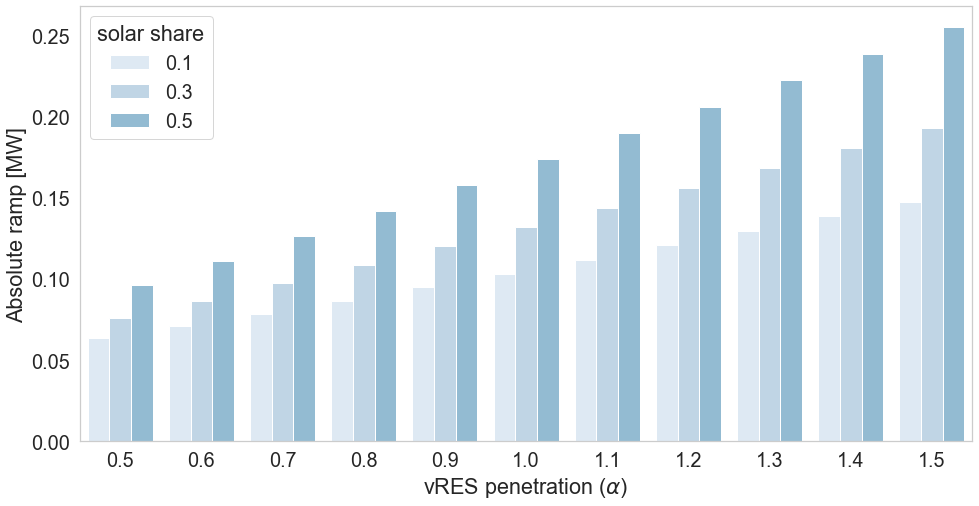

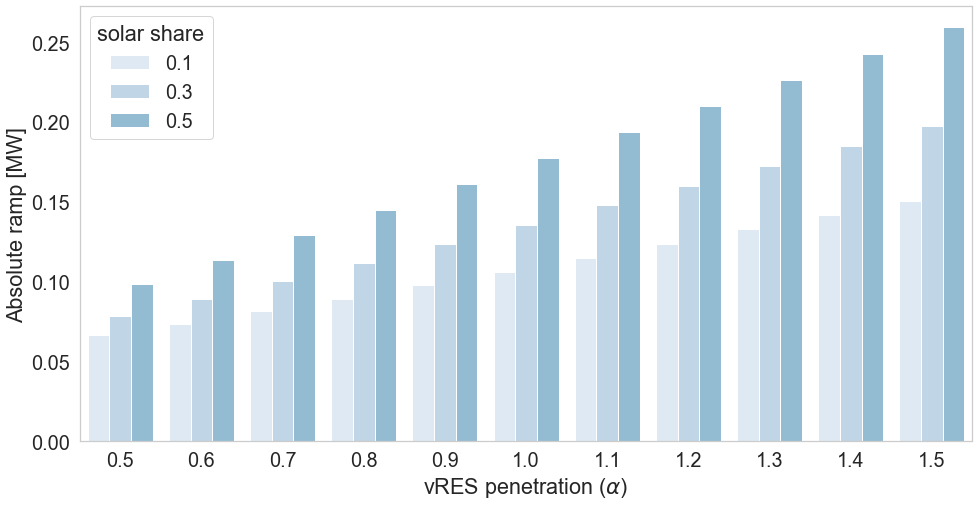

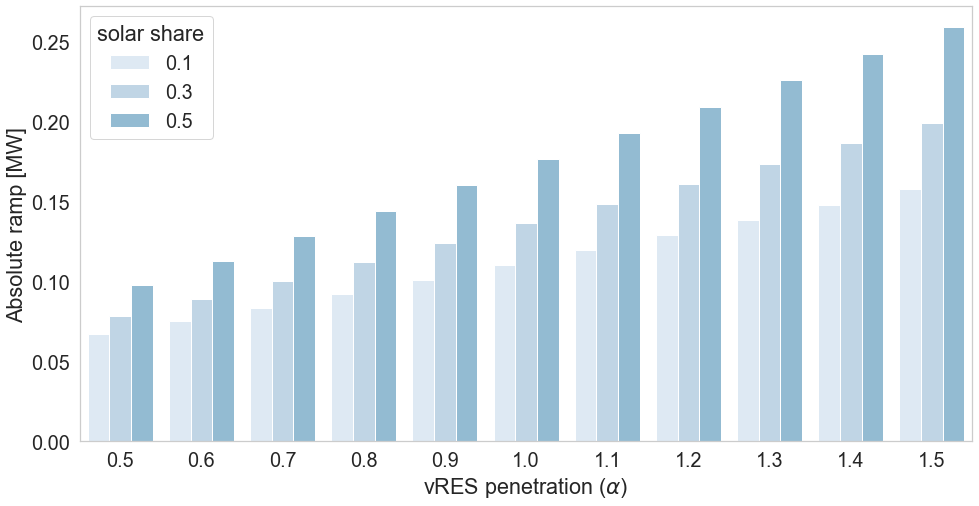

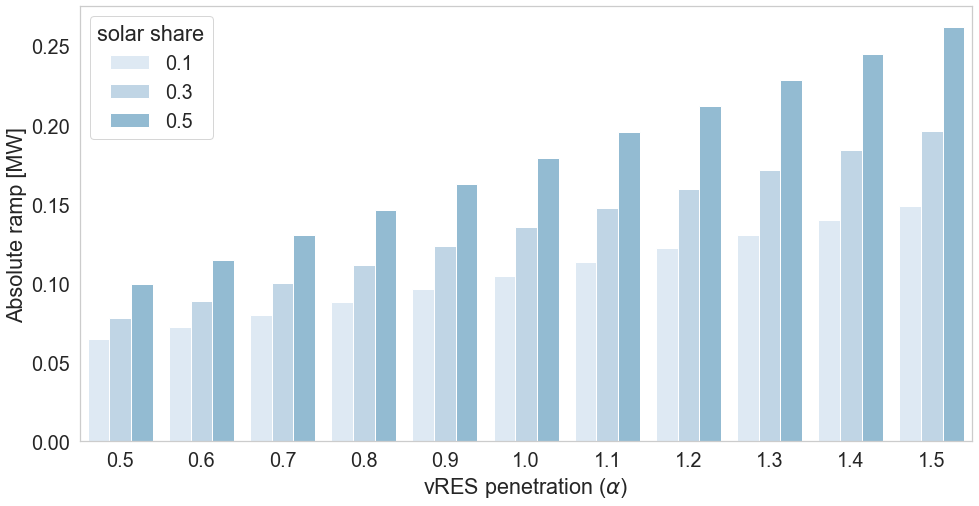

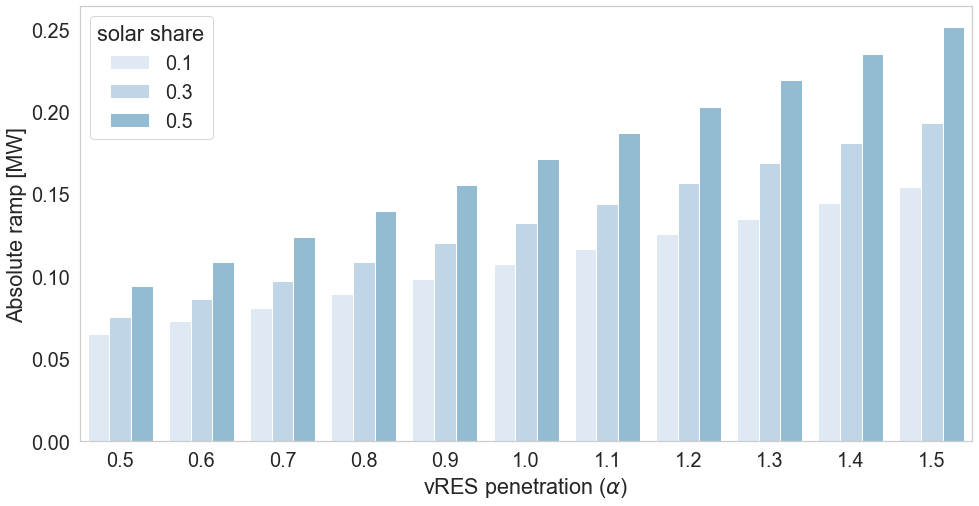

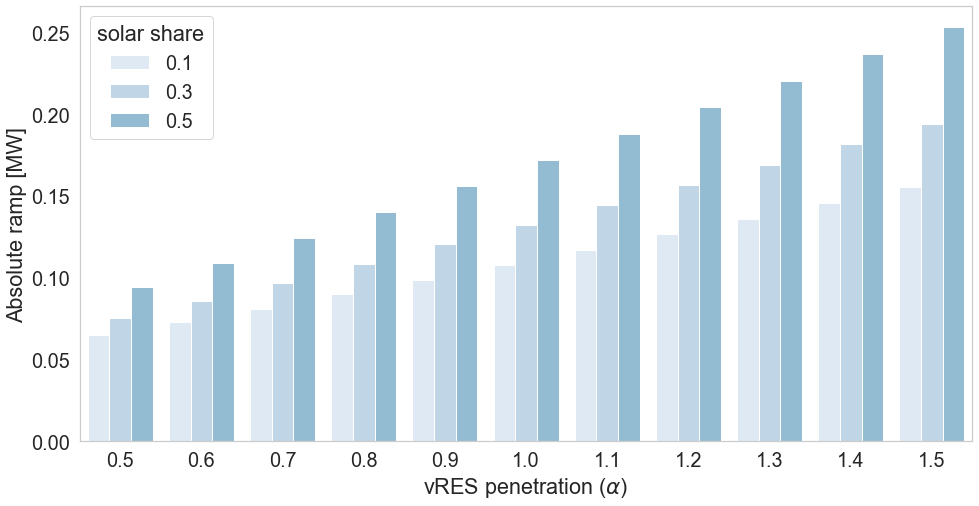

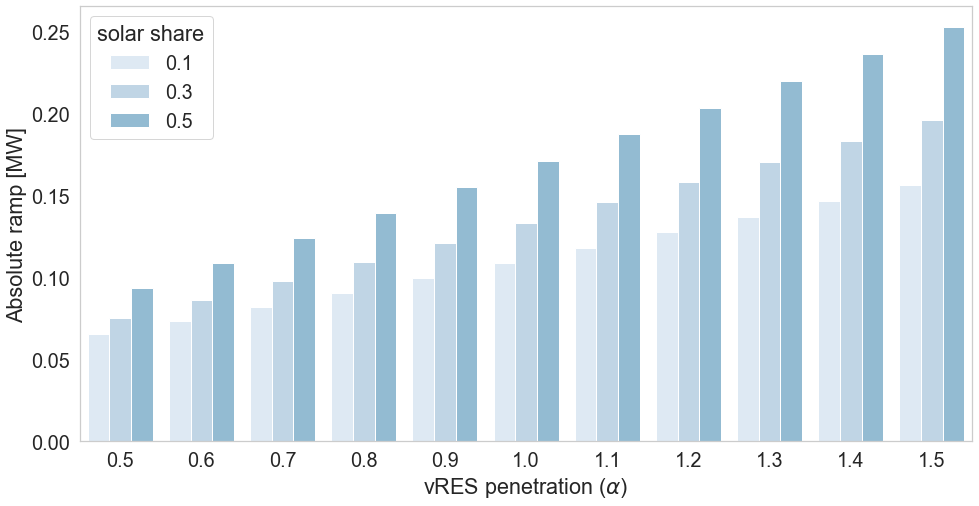

In [17]:
alphas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
betas = [0.1, 0.3, 0.5]

df = df.loc[df['year']>=solar_start_year].copy()

for area in df[price_areas].unique():
    for year in df['year'].unique():
        print(year)
        
        el = df.loc[(df[price_areas]==area) & (df['year']==year)].copy()
        my_alpha, my_beta, my_r = [], [], []
        
        for alpha in alphas:
            for beta in betas:
                
                el = get_upscaled_gen(el, S, W, L)
                el['mismatch'] = (alpha * ((beta * (el[up_s])) + ((1-beta) * el[up_w]))) - el[l] 
                el['ramp'] = el['mismatch'].diff()
            
                my_alpha.append(alpha)
                my_beta.append(beta)
                my_r.append(np.mean(np.abs(el['ramp'])))
            
        new_df = pd.DataFrame({'vRES_share':my_alpha, 'solar share':my_beta, 'Av_ramp': my_r}, index=my_alpha)
    
        plt.figure()
        ax = sns.barplot(x='vRES_share', y='Av_ramp', hue='solar share', data=new_df, ci=None);
        plt.ylabel('Absolute ramp [MW]')
        plt.xlabel(r'vRES penetration ($\alpha$)')
        ax.set_xticklabels(alphas)
        plt.savefig(figpath + "av_ramps_RL_alphas_betas_" + str(year) + "_" + area + ".png", bbox_inches="tight", pad_inches=0.3)

#### Understanding the ramp of the residual load: maximum upward and downward ramps

2014
2015
2016
2017
2018
2019
2020
2014
2015
2016
2017
2018
2019
2020


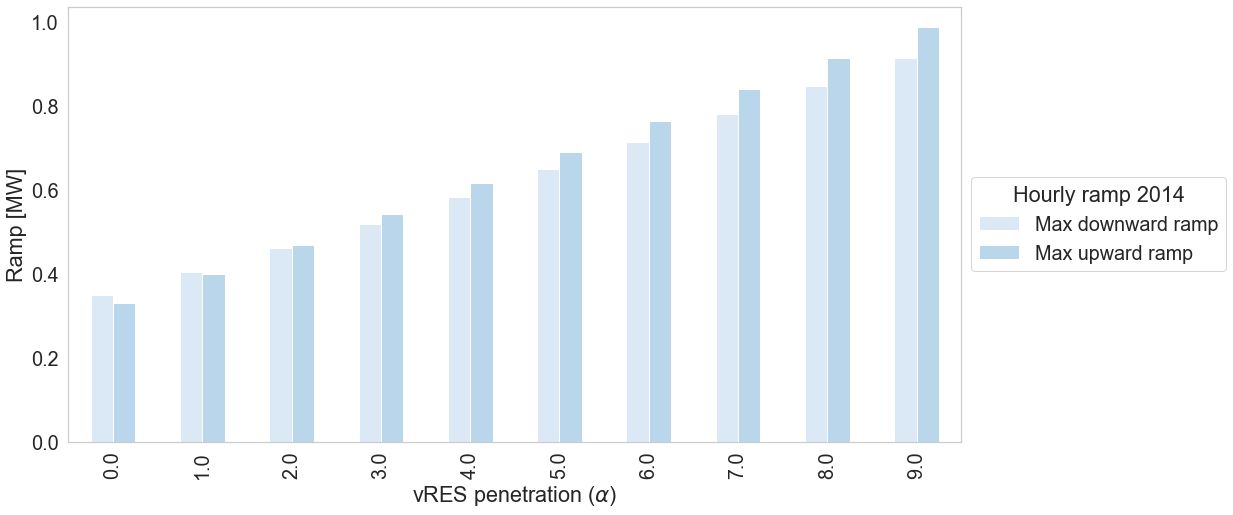

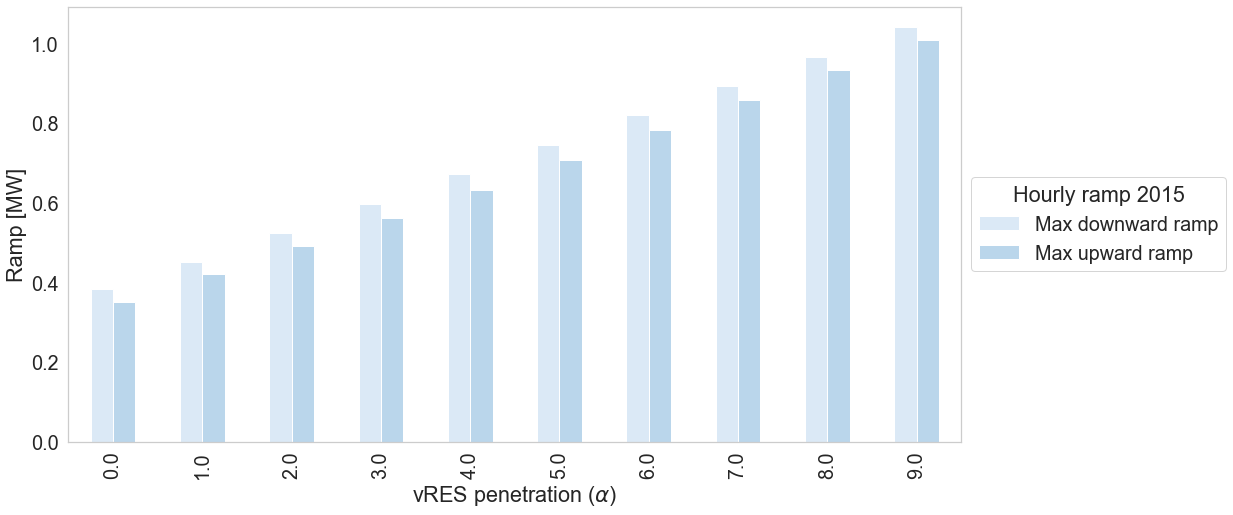

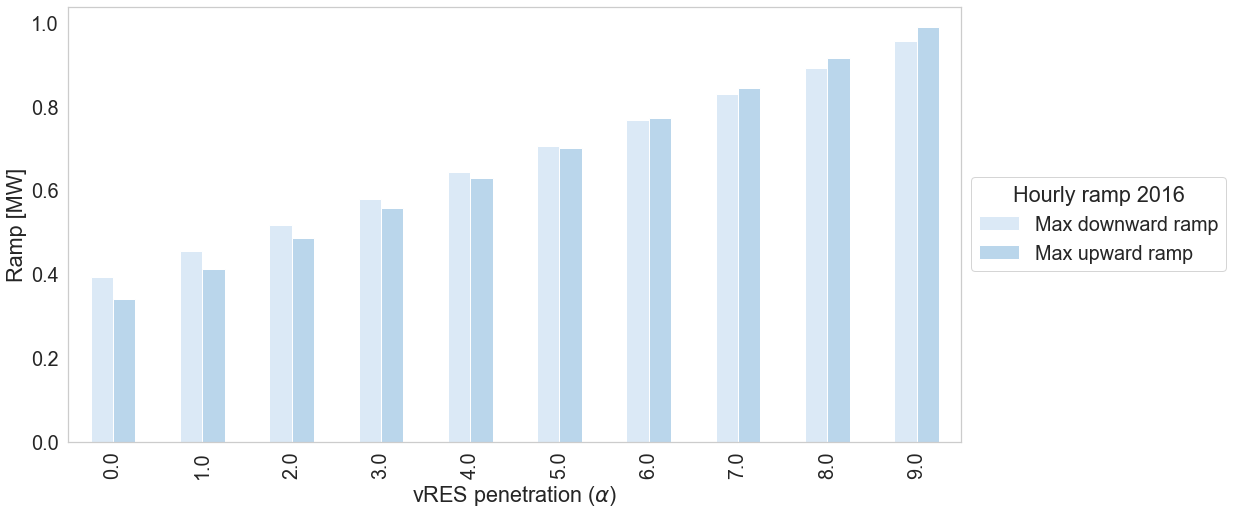

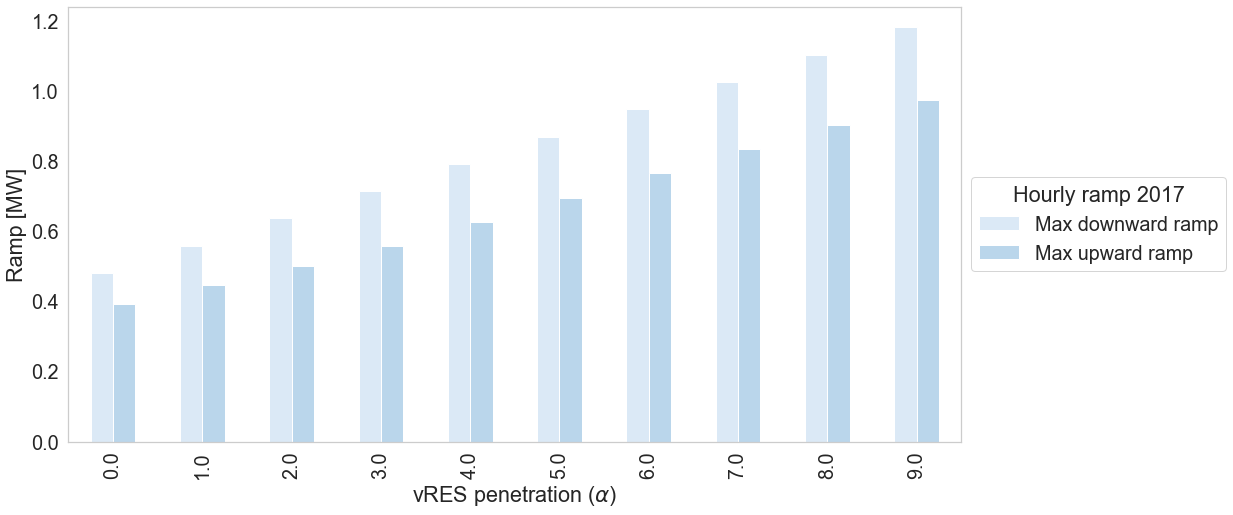

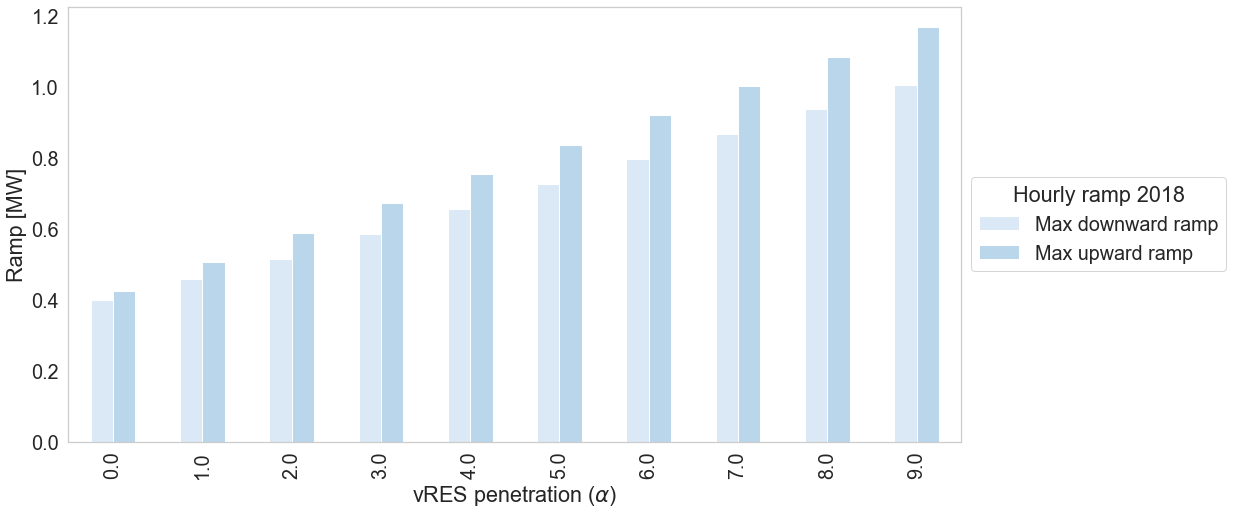

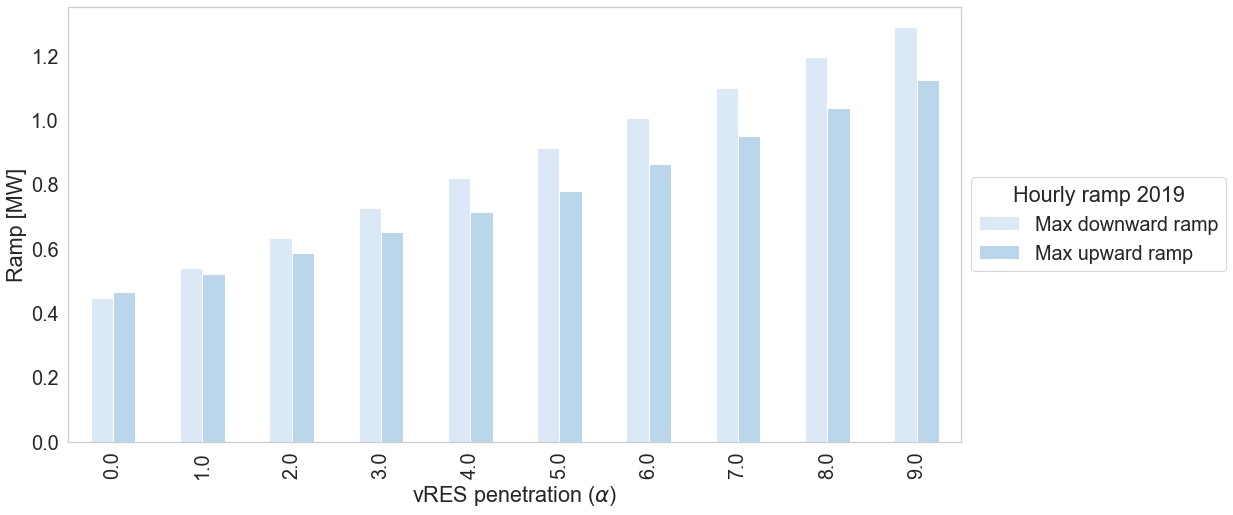

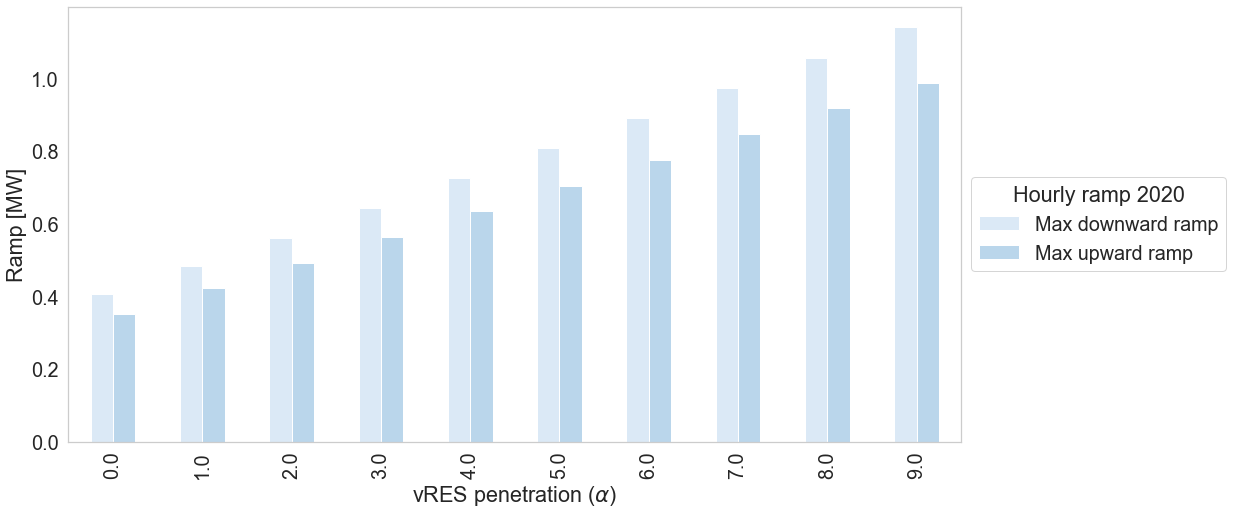

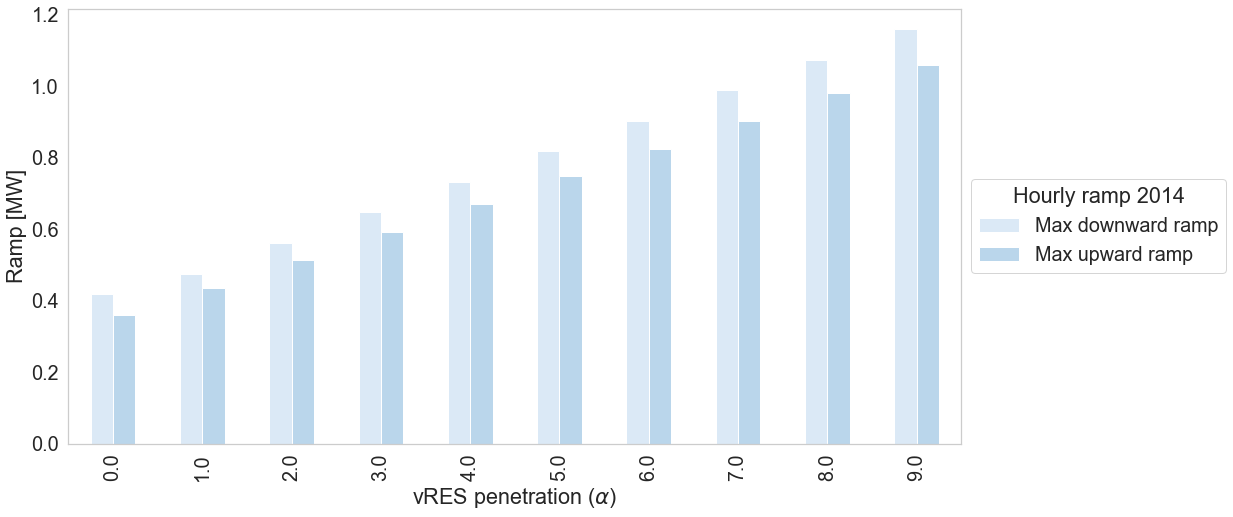

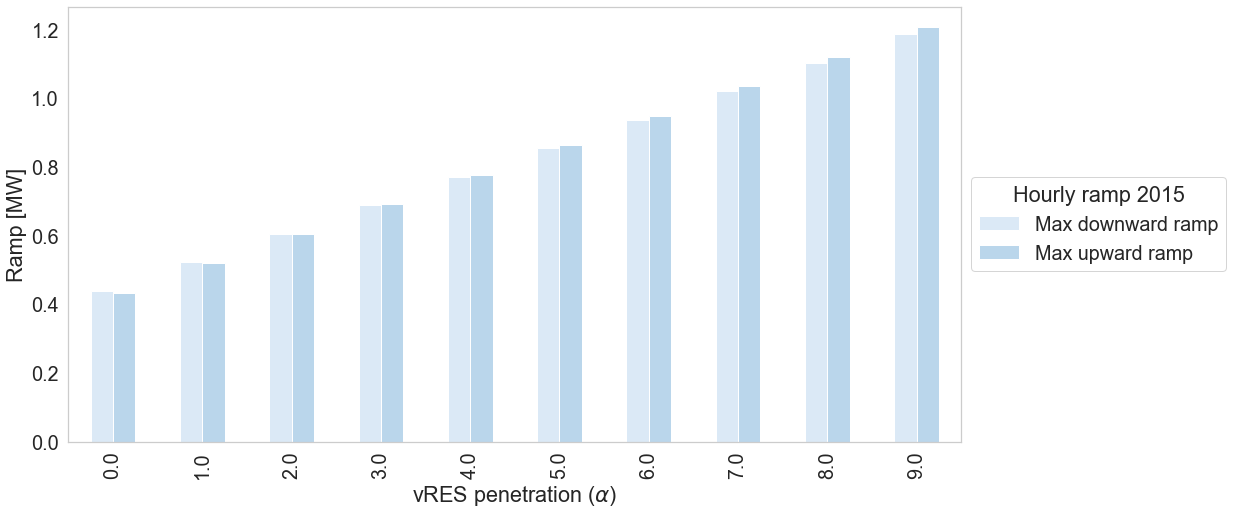

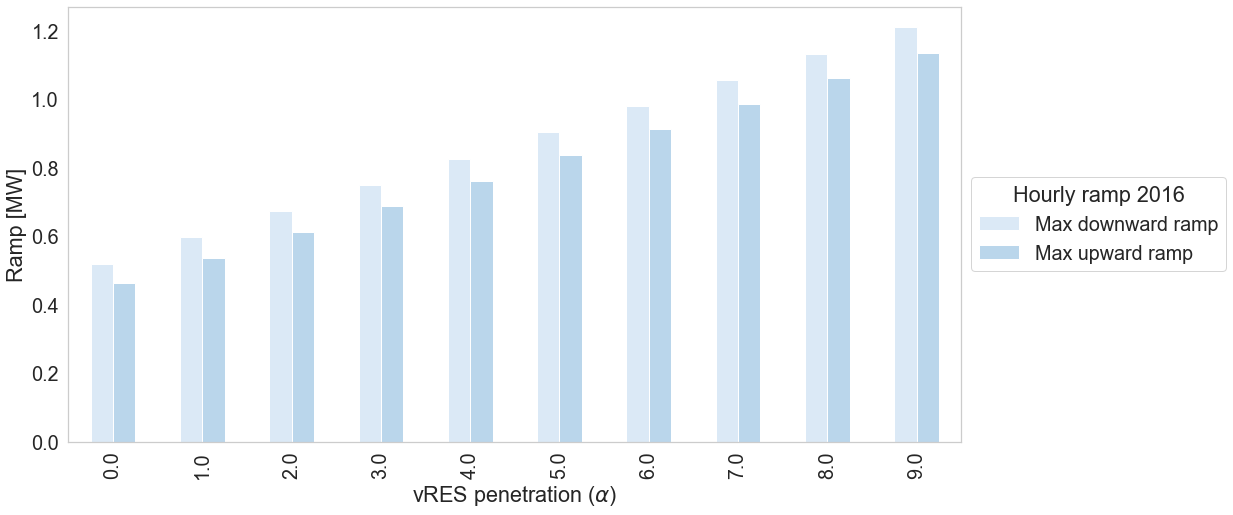

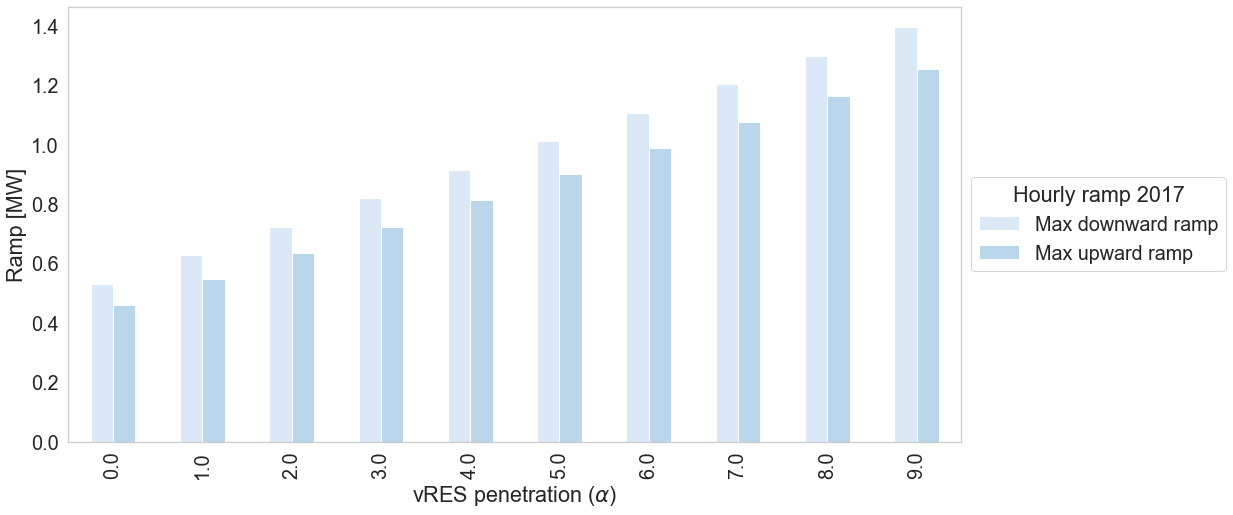

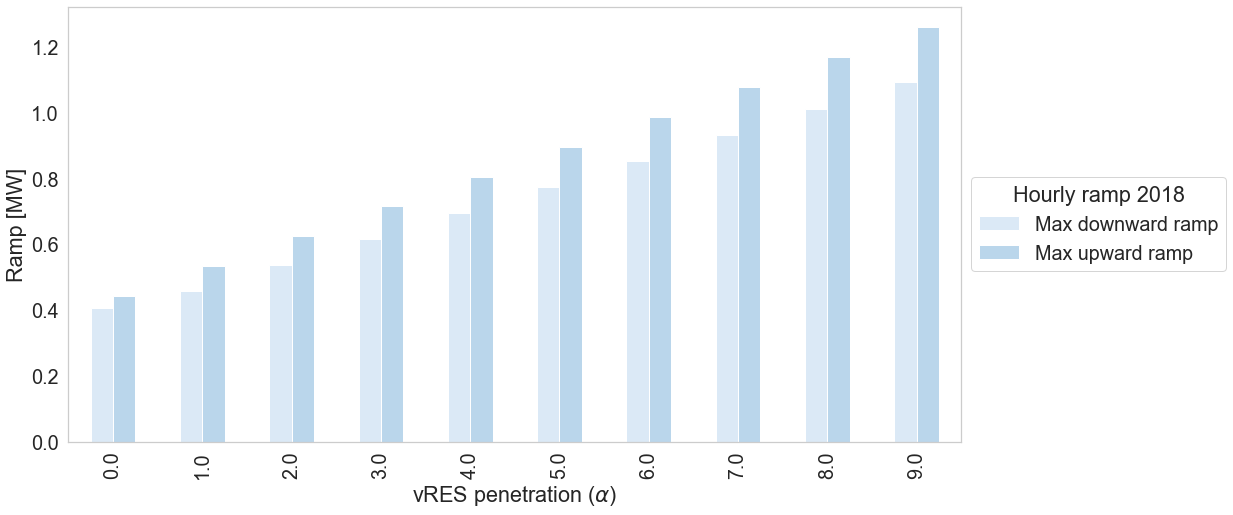

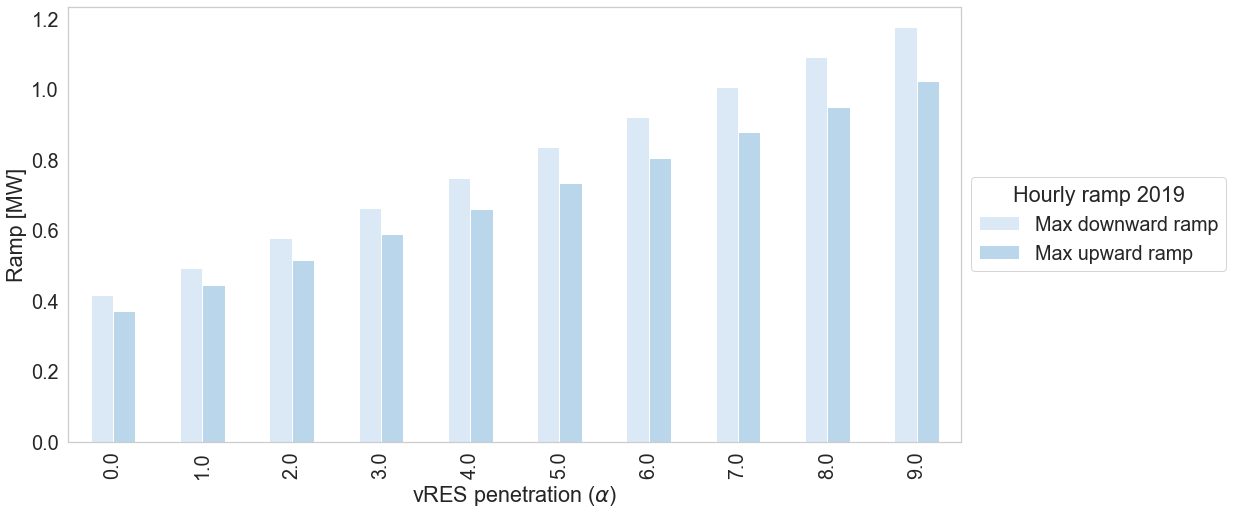

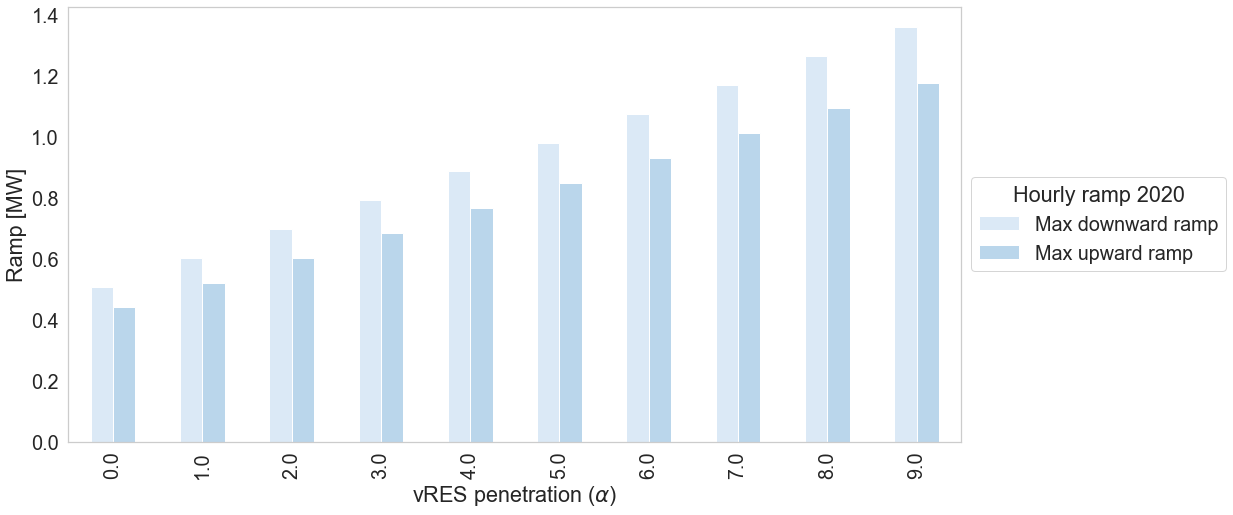

In [18]:
alphas = np.arange(0.5, 1.5, 0.1)
beta = 0.3

df = df.loc[df['year']>=solar_start_year].copy()

for area in df[price_areas].unique():
    for year in df['year'].unique():
        print(year)
        
        el = df.loc[(df[price_areas]==area) & (df['year']==year)].copy()
    
        r_up, r_dn = [], []
        
        for alpha in alphas:
            
            el = get_upscaled_gen(el, S, W, L)
            el['mismatch'] = (alpha * ((beta * (el[up_s])) + ((1-beta) * el[up_w]))) - el[l] 
            el['ramp'] = el['mismatch'].diff()
        
            r_up.append(np.max(el['ramp'].loc[el['ramp']>0]))
            r_dn.append(np.max(np.abs(el['ramp'].loc[el['ramp']<0])))
        
        new_df = pd.DataFrame({'Max downward ramp':r_dn, 'Max upward ramp':r_up}, index=alphas)
    
        new_df.plot(kind='bar', stacked=False)
    
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Hourly ramp ' + str(year))
        plt.ylabel('Ramp [MW]')
        plt.xlabel(r'vRES penetration ($\alpha$)')
        plt.ylim(bottom=0)
        plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
        plt.savefig(figpath + "ramps_RL_alphas_" + str(year) + "_" + area + ".png", bbox_inches="tight", pad_inches=0.3)   

#### Effect of solar-and-wind shares ($\beta$) on the residual load (RL)

2014
2015
2016
2017
2018
2019
2020
2014
2015
2016
2017
2018
2019
2020


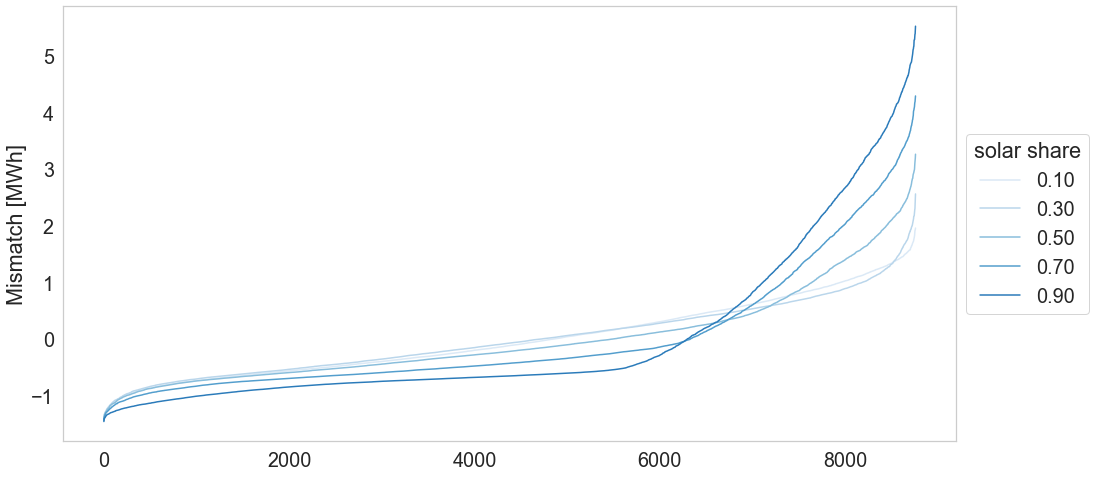

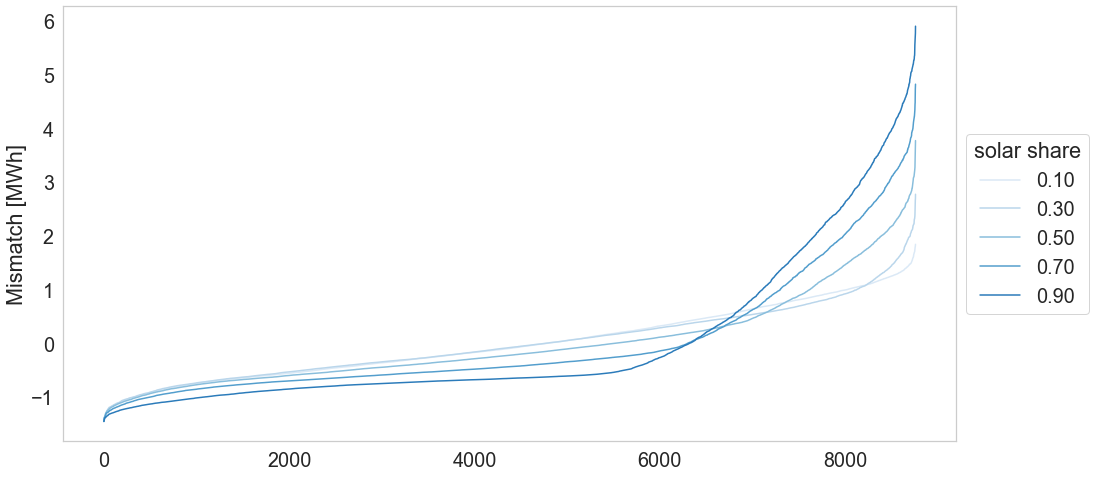

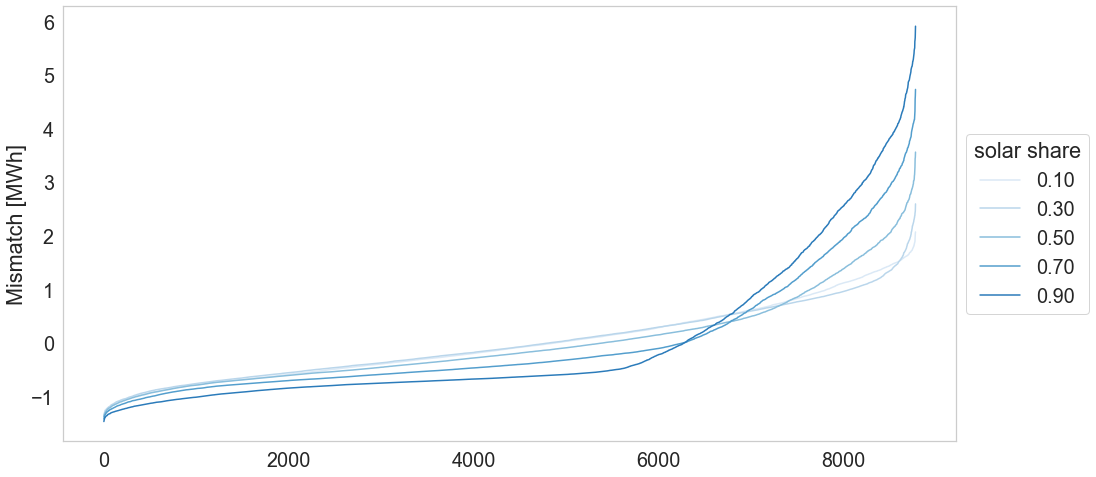

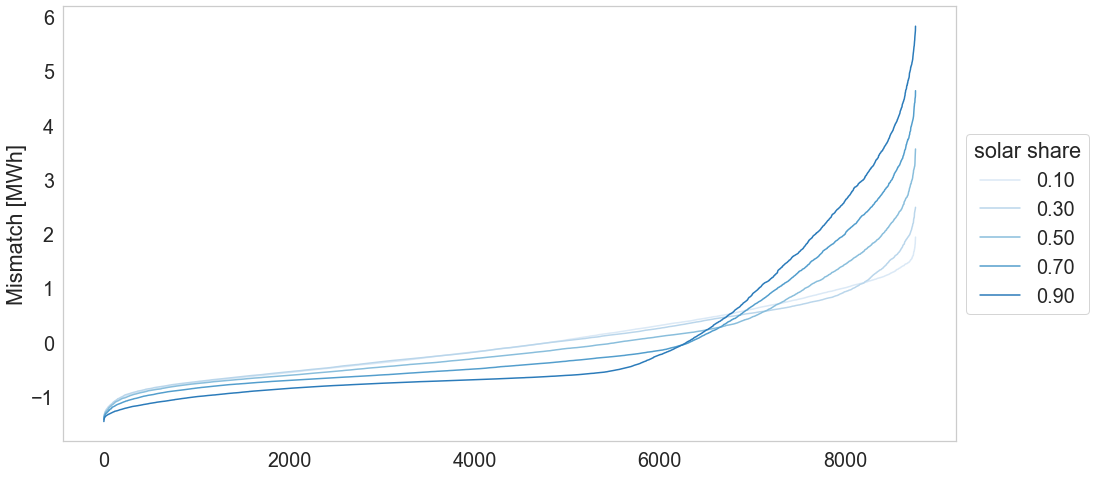

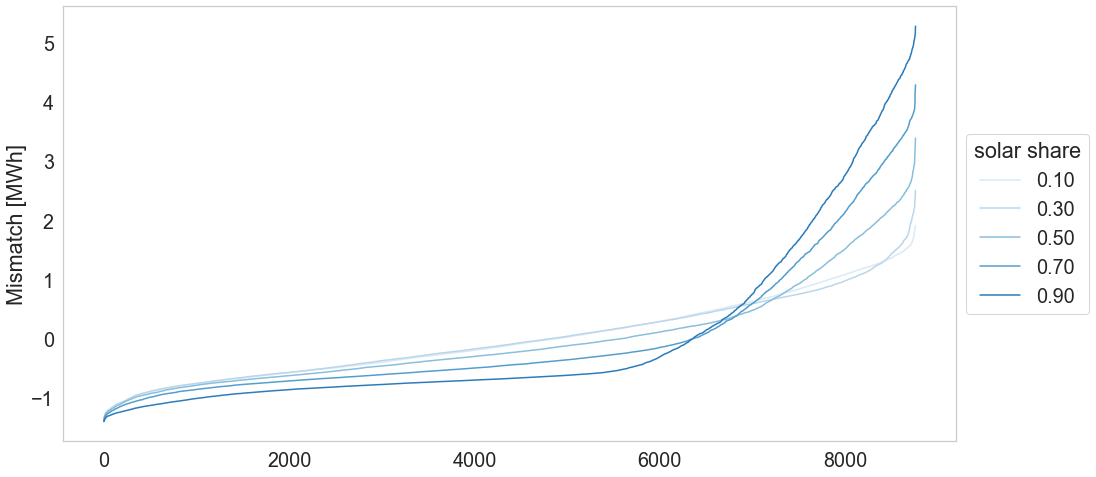

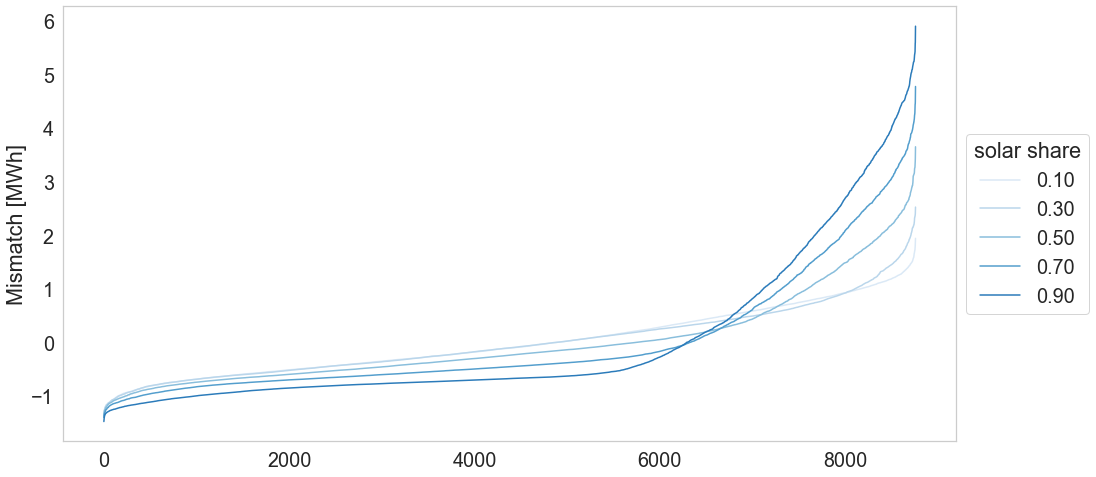

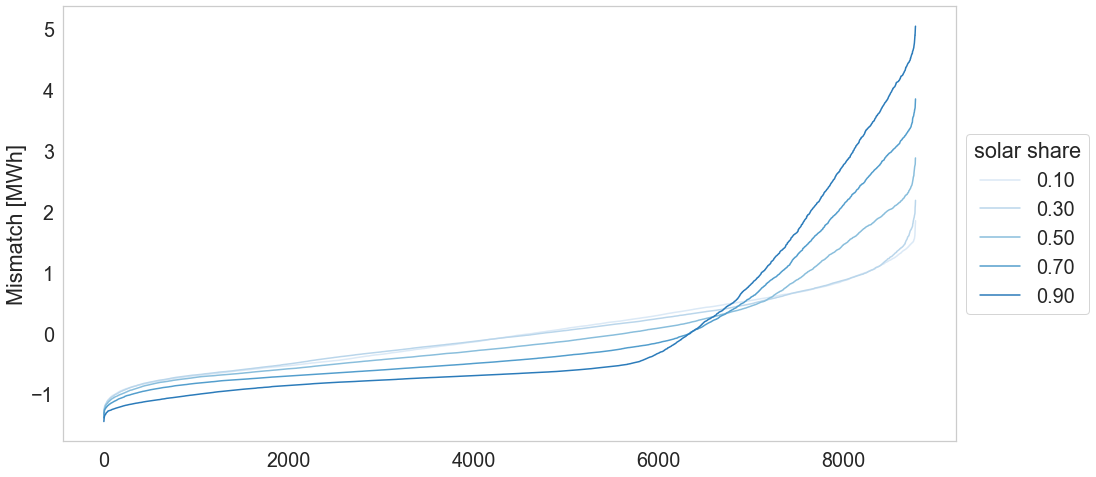

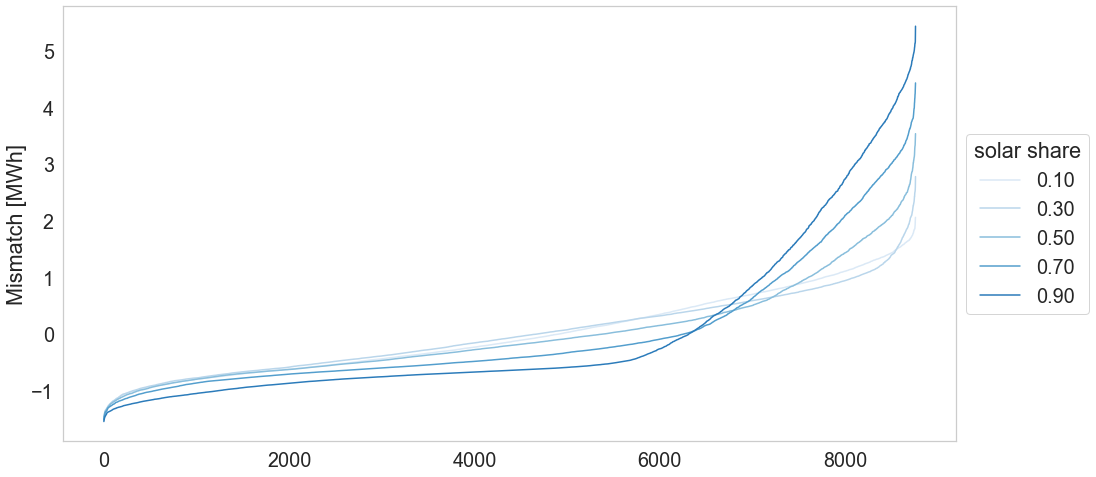

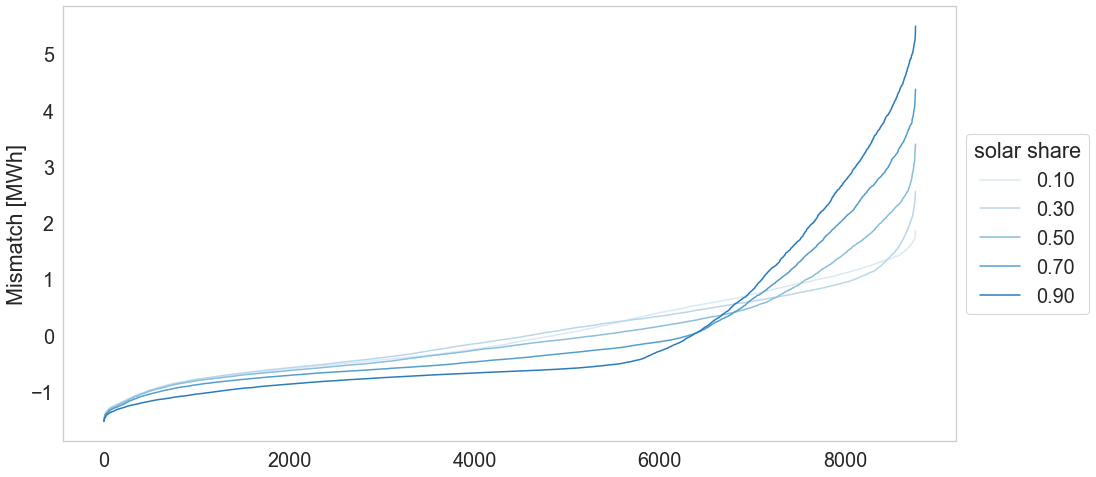

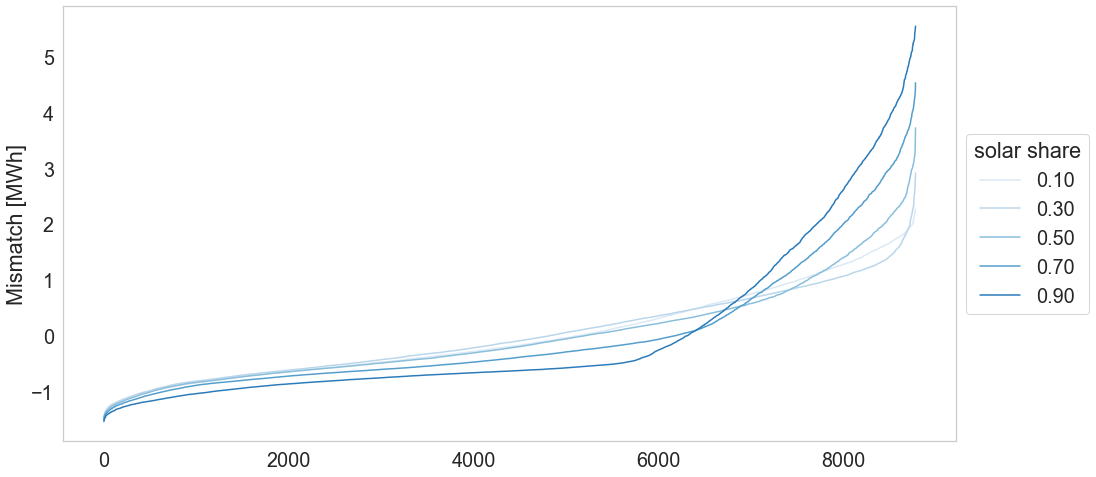

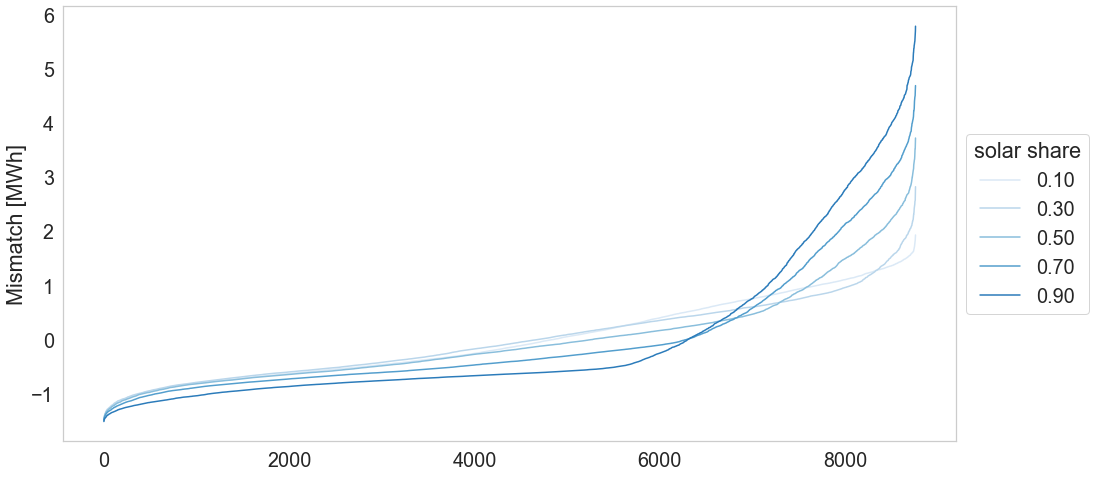

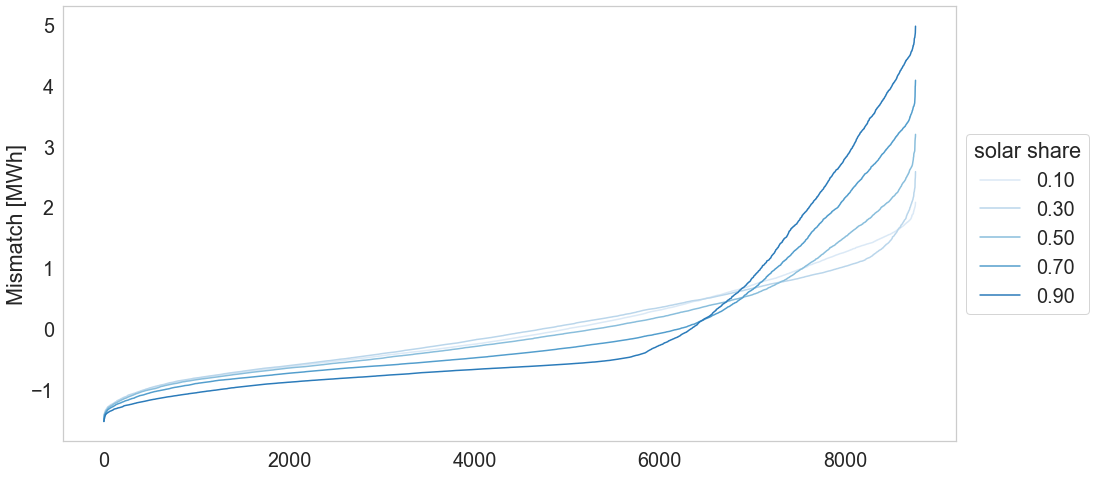

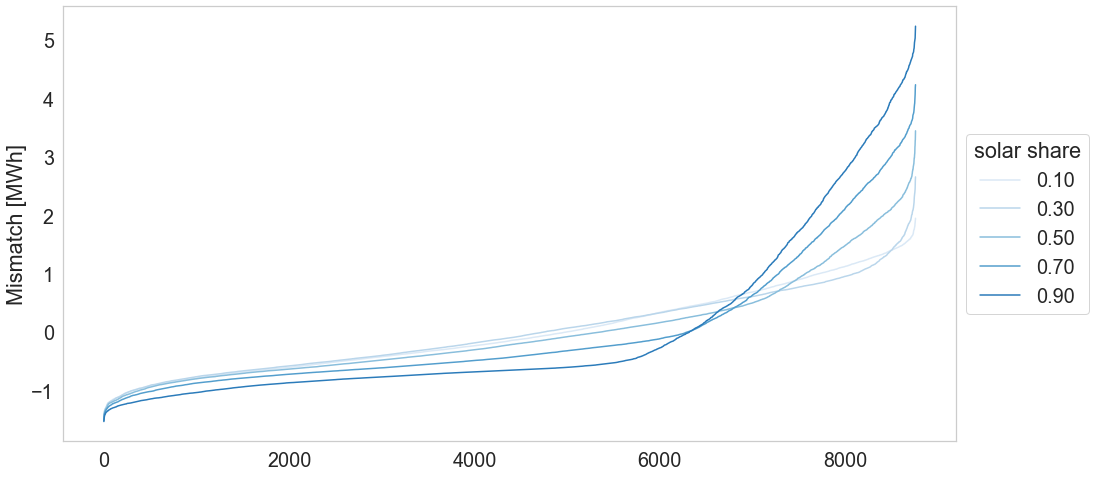

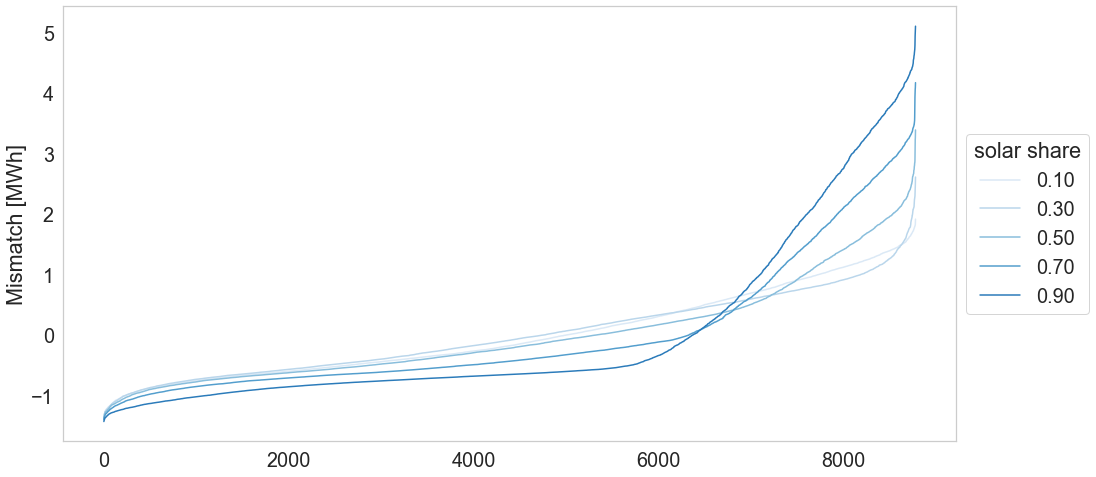

In [19]:
alpha = 1.0
betas = [0.1, 0.3, 0.5, 0.7, 0.9]

df = df.loc[df['year']>=solar_start_year].copy()

for area in df[price_areas].unique():
    for year in df['year'].unique():
        
        print(year)
        el = df.loc[(df[price_areas]==area) & (df['year']==year)].copy()
        
        plt.figure()
        
        for beta in betas:
            
            el = get_upscaled_gen(el, S, W, L)
            el['mismatch'] = (alpha * ((beta * (el[up_s])) + ((1-beta) * el[up_w]))) - el[l] 
            sorted_el = el.sort_values(by=['mismatch'], ascending=True)
        
            plt.plot(np.arange(0, len(sorted_el)), sorted_el['mismatch'].values, label="{:.2f}".format(beta))
        
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='solar share')
        plt.ylabel('Mismatch [MWh]')
        plt.savefig(figpath + "sorted_mismatch_betas_" + str(year) + "_" + area + ".png", bbox_inches="tight", pad_inches=0.3)

#### Further understanding the RL through

- vRES installed capacity
- Curtailment
- Peak residual load
- Residual generation
- Full load hour
- Load factor

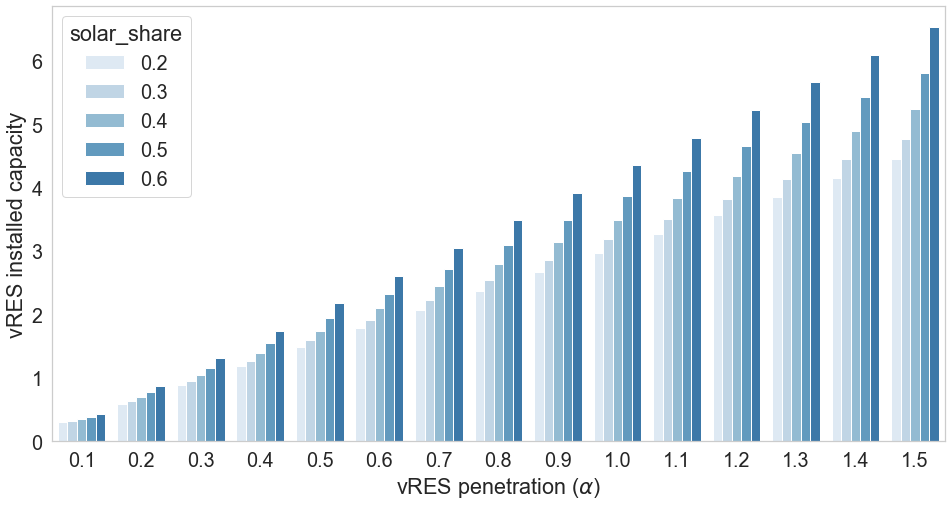

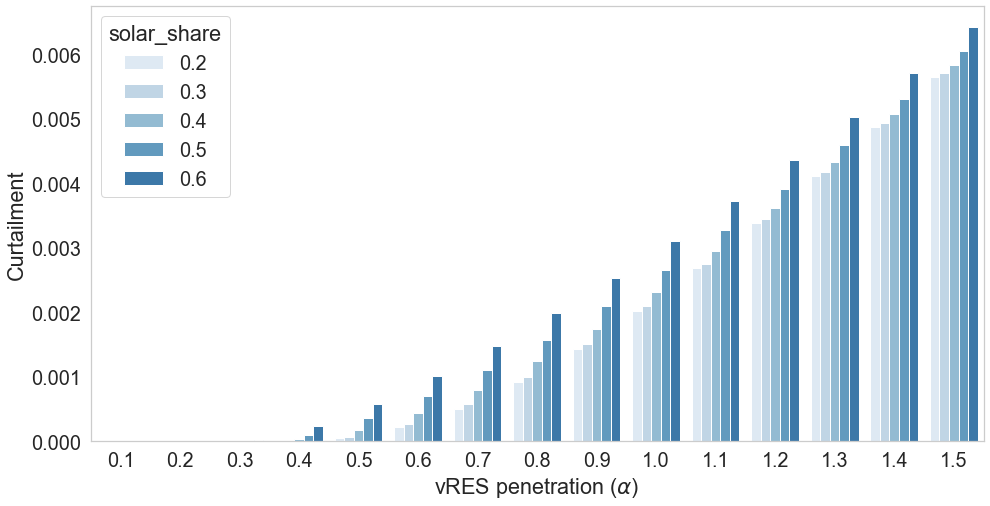

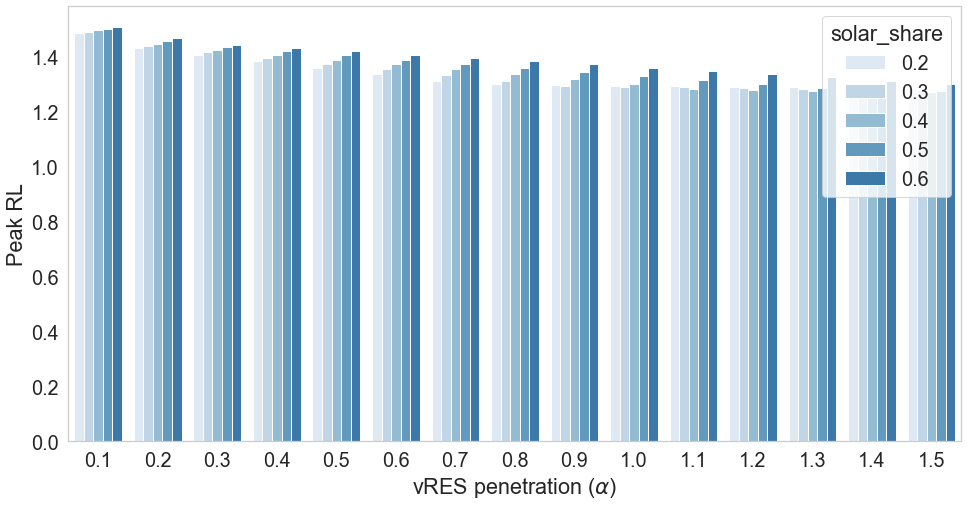

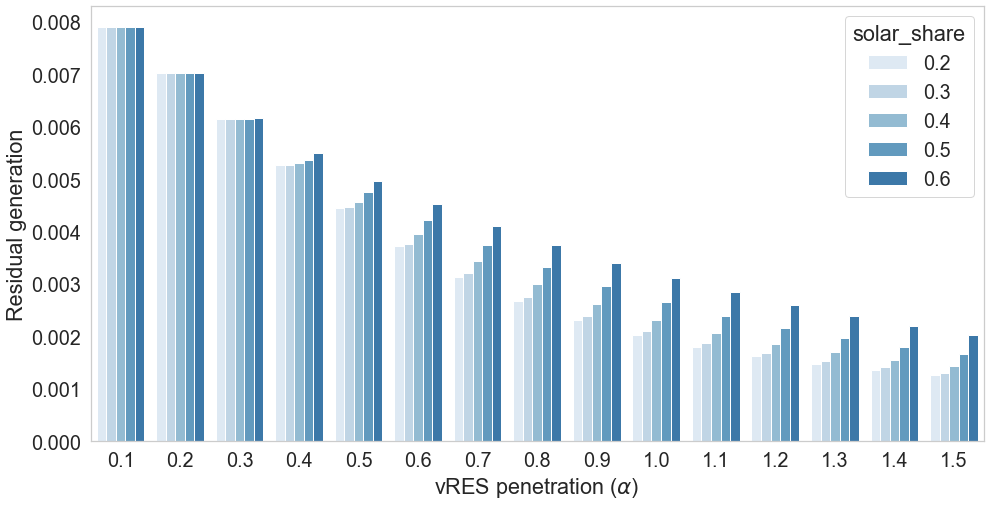

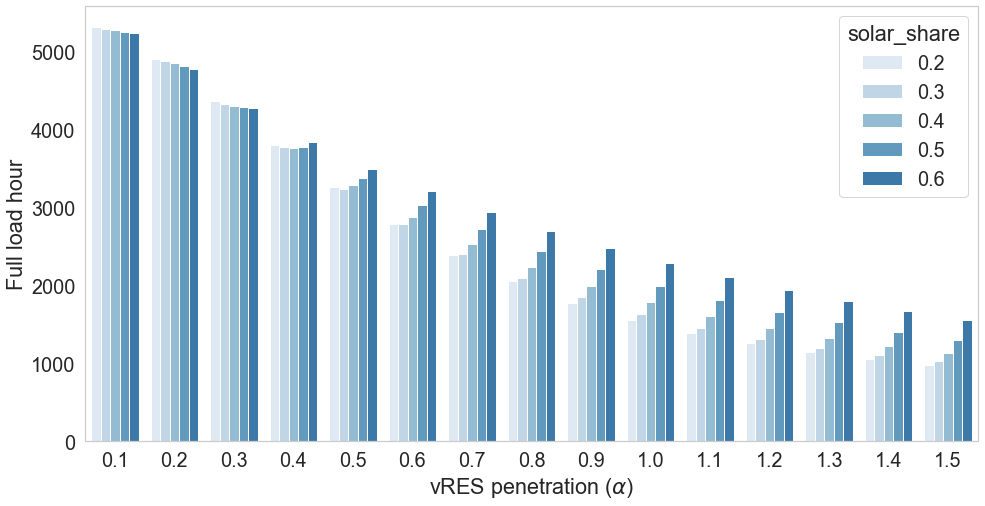

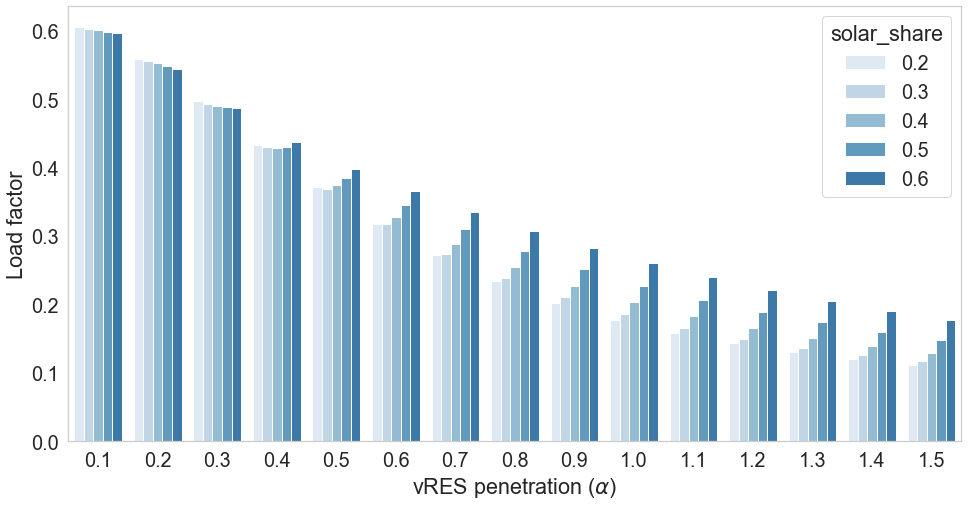

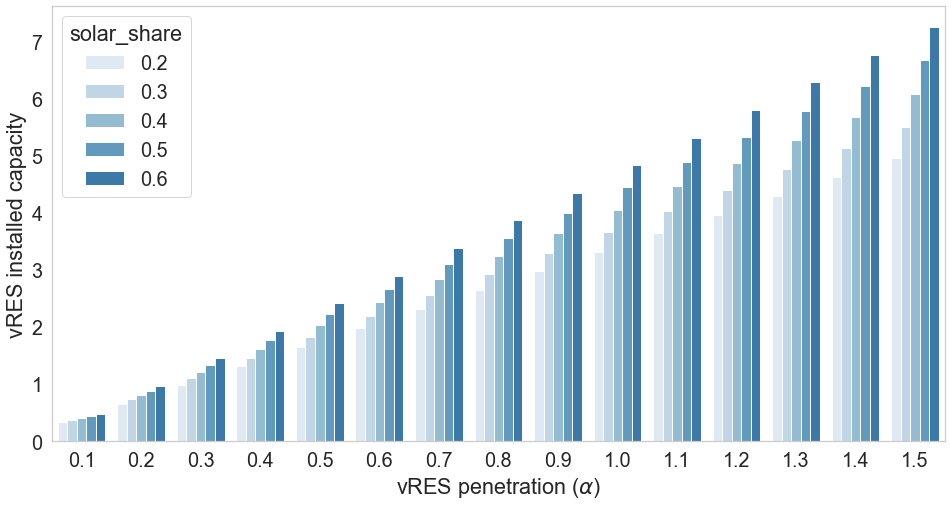

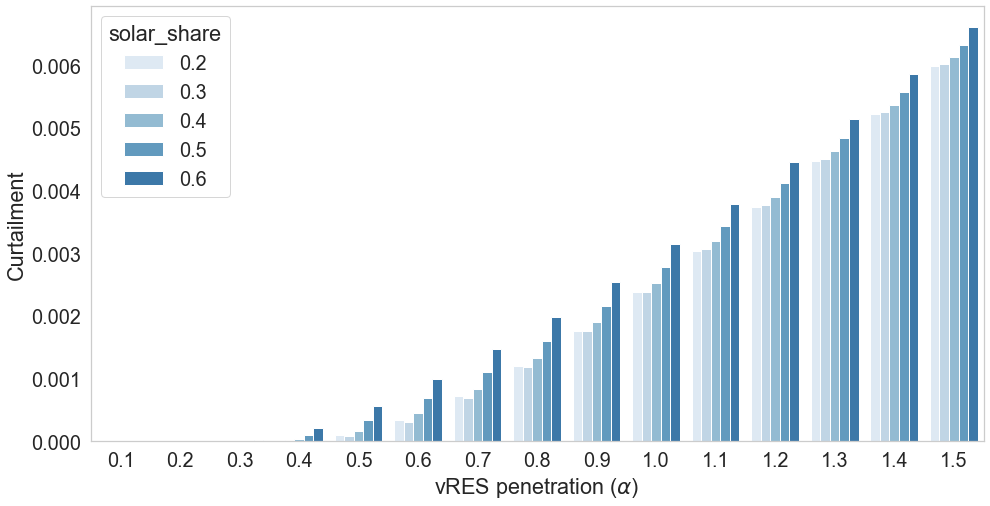

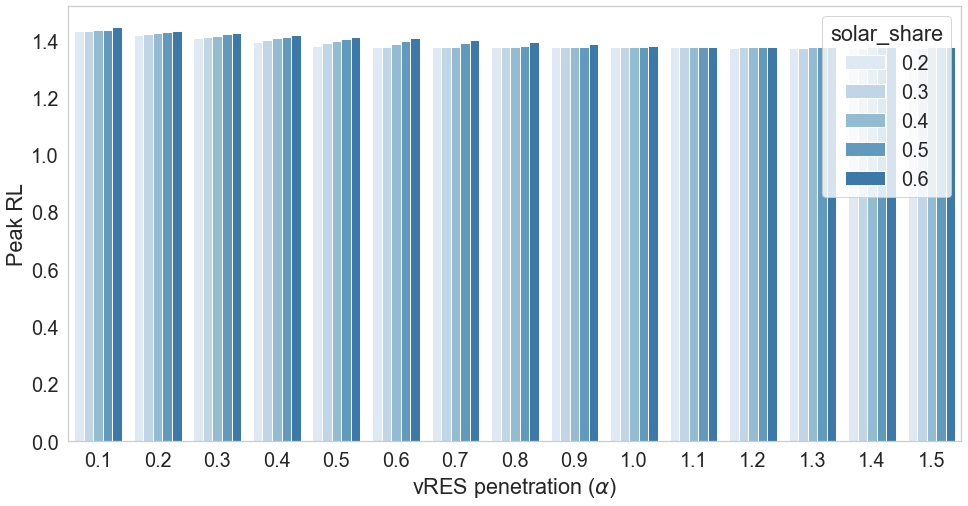

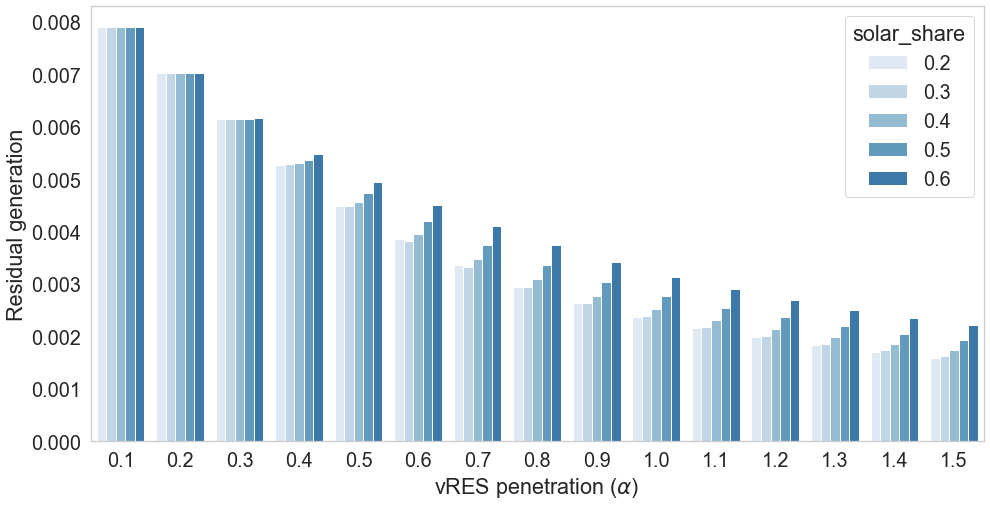

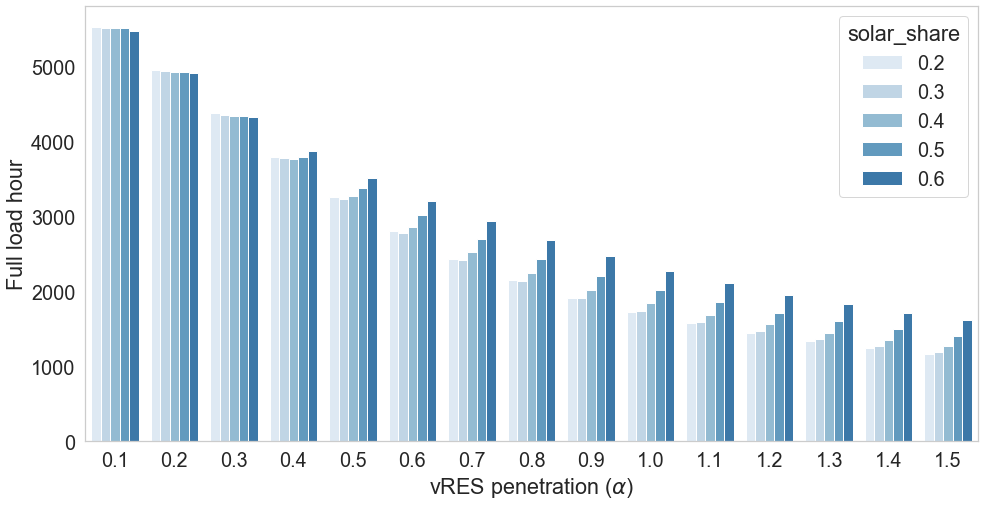

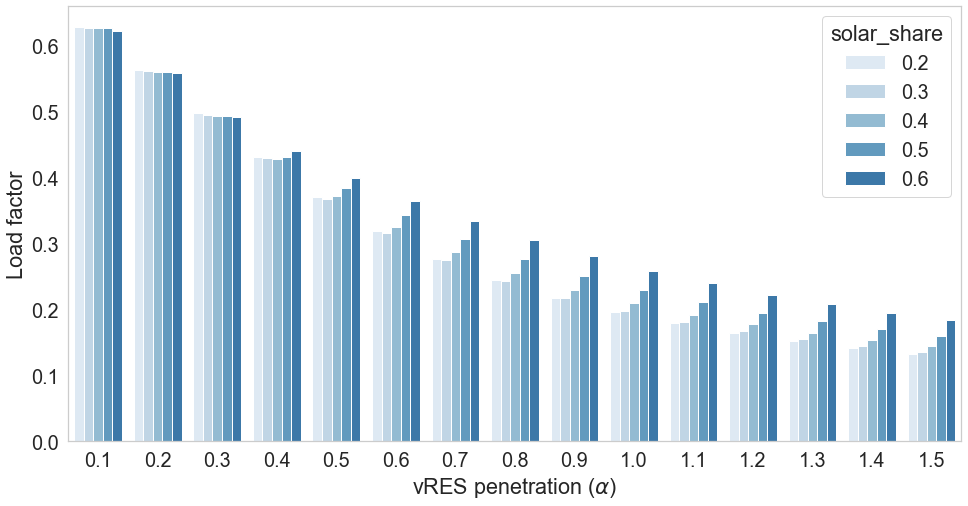

In [21]:
year = 2020

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
betas = [0.2, 0.3, 0.4, 0.5, 0.6]

df = df.loc[df['year']>=solar_start_year].copy()

for area in df[price_areas].unique():
   
    el = df.loc[(df[price_areas]==area) & (df['year']==year)].copy()
    
    ic_vres, vres_twh, curt_twh = [], [], []
    peak_rl, res_gen_twh, flh, load_factor = [], [], [], []
    my_alpha, my_beta = [], []
    
    for alpha in alphas:  
        for beta in betas:
                
            el = get_upscaled_gen(el, S, W, L)
            el['mismatch'] = (alpha * ((beta * (el[up_s])) + ((1-beta) * el[up_w]))) - el[l] 
            el['g_new'] = alpha * ((beta * (el[up_s])) + ((1-beta) * el[up_w]))
                
            el['ramp'] = el['mismatch'].diff()
            
            ic_vres.append(np.max(el['g_new']))
            vres_twh.append(np.sum(el['g_new']) * m2t)
            curt_twh.append(np.sum(el['mismatch'].loc[el['mismatch']>0]) * m2t)
            peak_rl.append(np.max(np.abs(el['mismatch'].loc[el['mismatch']<0])))
            
            res_gen_twh.append(np.abs(np.sum(el['mismatch'].loc[el['mismatch']<0])) * m2t)
            flh.append(np.abs(np.sum(el['mismatch'].loc[el['mismatch']<0]))/np.max(np.abs(el['mismatch'].loc[el['mismatch']<0])))
            
            if is_leap_year(year):
                load_factor.append((np.abs(np.sum(el['mismatch'].loc[el['mismatch']<0]))/np.max(np.abs(el['mismatch'].loc[el['mismatch']<0])))/8784)
            else:
                load_factor.append((np.abs(np.sum(el['mismatch'].loc[el['mismatch']<0]))/np.max(np.abs(el['mismatch'].loc[el['mismatch']<0])))/8760)
            
            my_alpha.append(alpha)
            my_beta.append(beta)
            
    new_df = pd.DataFrame({'vRES_share':my_alpha, 'solar_share':my_beta, 'IC_vres': ic_vres, 'vRES_TWh': vres_twh, 'curt_TWh': curt_twh, 'Peak_RL': peak_rl, 'res_gen_twh': res_gen_twh, 'FLH': flh, 'Load_factor': load_factor}, index=my_alpha)
    
    plt.figure()
    ax = sns.barplot(x='vRES_share', y='IC_vres', hue='solar_share', data=new_df, ci=None);
    plt.ylabel('vRES installed capacity')
    plt.xlabel(r'vRES penetration ($\alpha$)')
    ax.set_xticklabels(alphas)
    plt.savefig(figpath + "ic_vres_RL_alphas_betas_" + str(year) + "_" + area + ".png", bbox_inches="tight", pad_inches=0.3)
    
    plt.figure()
    ax = sns.barplot(x='vRES_share', y='curt_TWh', hue='solar_share', data=new_df, ci=None);
    plt.ylabel('Curtailment')
    plt.xlabel(r'vRES penetration ($\alpha$)')
    ax.set_xticklabels(alphas)
    plt.savefig(figpath + "curt_RL_alphas_betas_" + str(year) + "_" + area + ".png", bbox_inches="tight", pad_inches=0.3)
    
    plt.figure()
    ax = sns.barplot(x='vRES_share', y='Peak_RL', hue='solar_share', data=new_df, ci=None);
    plt.ylabel('Peak RL')
    plt.xlabel(r'vRES penetration ($\alpha$)')
    ax.set_xticklabels(alphas)
    #ax.set_ylim([1.35, 1.45])
    plt.savefig(figpath + "peak_RL_alphas_betas_" + str(year) + "_" + area + ".png", bbox_inches="tight", pad_inches=0.3)
    
    plt.figure()
    ax = sns.barplot(x='vRES_share', y='res_gen_twh', hue='solar_share', data=new_df, ci=None);
    plt.ylabel('Residual generation')
    plt.xlabel(r'vRES penetration ($\alpha$)')
    ax.set_xticklabels(alphas)
    plt.savefig(figpath + "res_gen_RL_alphas_betas_" + str(year) + "_" + area + ".png", bbox_inches="tight", pad_inches=0.3)
    
    plt.figure()
    ax = sns.barplot(x='vRES_share', y='FLH', hue='solar_share', data=new_df, ci=None);
    plt.ylabel('Full load hour')
    plt.xlabel(r'vRES penetration ($\alpha$)')
    ax.set_xticklabels(alphas)
    plt.savefig(figpath + "flh_RL_alphas_betas_" + str(year) + "_" + area + ".png", bbox_inches="tight", pad_inches=0.3)
    
    plt.figure()
    ax = sns.barplot(x='vRES_share', y='Load_factor', hue='solar_share', data=new_df, ci=None);
    plt.ylabel('Load factor')
    plt.xlabel(r'vRES penetration ($\alpha$)')
    ax.set_xticklabels(alphas)
    plt.savefig(figpath + "lf_RL_alphas_betas_" + str(year) + "_" + area + ".png", bbox_inches="tight", pad_inches=0.3)